In [1]:
import csv
import pickle
import json
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from mouselab.mouselab import MouselabEnv
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy
import math
import sklearn.cluster
from math import floor, ceil

# Reading Data from Files

In [2]:
fileprefix = "pilot_3" # pilot_#, final
datafolder = '../results/'

all_part_files = [filename for filename in os.listdir(datafolder) if filename.startswith(fileprefix) and 'results' not in filename]
all_part_paths = [datafolder + filename for filename in all_part_files]

# Creating Trial Dataframe

In [3]:
# Each participant has their own file, generated from the Heroku postgres output in the 
# preprocessing notebook

part_stats_dicts = []
scarcity_level = 1.0
for file in all_part_paths:
    with open(file, 'r') as f:
        participant = json.load(f)
    try:
        beginhit = datetime.datetime.strptime(participant['Beginhit'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        beginhit = None
    try:
        endhit = datetime.datetime.strptime(participant['Endhit'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        endhit = None
    try:    
        beginexp = datetime.datetime.strptime(participant['Beginexp'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        beginexp = None
    
    try:
        hitLength = (endhit-beginhit).seconds
    except TypeError:
        hitLength = None
    
    try:
        expLength = (endhit-beginexp).seconds
    except TypeError:
        expLength = None
        
    numPracTrials = 0
    trialLengths = []
    trialScores = []
    expectedScores = []
    numClicks = []
    avgClickLevel = []
    trialClicksL1 = []
    trialClicksL2 = []
    trialClicksL3 = []
    trialClicksL4 = []
    trialClicksL5 = []
    rewardsWithheld = []
    demographicsAvailable = False
    effort = "-1"
    age = None
    gender = None
    colorblind = None
    
    print(participant['workerId'])
    try:
        firstTrialStamp = participant['data'][0]['dateTime']
    except:
        print("No data")
        continue
    lastTrialStamp = participant['data'][-1]['dateTime']
    if hitLength is None:
        hitLength = (lastTrialStamp - firstTrialStamp) / 1000
    if expLength is None:
        expLength = (lastTrialStamp - firstTrialStamp) / 1000
        
    # Dictionary to check whether mouselab task has been completed
    mdp_timestamps = {
        "start" : 0,
        "end" : 0,
        "done": False
    }
    
    # Use state machine to parse participant trial data, update state 
    #  based on trials seen
    current_state = "stroop_1"
    last_trial = participant['data'][0]
    feedback = ""
    comments = ""
    whatStrategy = ""
    strategyImprove = ""
    difficult = ""
    for idx, trial in enumerate(participant['data']):
        trial_type = trial['trialdata']['trial_type']
        try:
            trial_id = str(trial['trialdata']['trial_id'])
        except KeyError:
            trial_id = ""
    
        
        # Start mouselab trials
        if trial_id.startswith("mouselab_instructions_1") and not mdp_timestamps["done"]:
            mdp_timestamps["done"] = True
            mdp_timestamps["start"] = trial['dateTime']
        
        # Finish mouselab trials
        if trial_id.startswith("final_quiz"):
            mdp_timestamps["end"] = trial['dateTime']
            
        
        # Mouselab trial encountered
        if trial_type == 'mouselab-mdp':
            if trial_id.startswith('practice'):
                numPracTrials += 1
            else:
                trialLengths.append(trial['trialdata']['trialTime'])
                
                trialScores.append(trial['trialdata']['score'])
                rewardsWithheld.append(trial['trialdata']['withholdReward'])
                
                # Getting expected scores
                g_truth = [0.0] + trial['trialdata']['stateRewards'][1:]
                mEnv = MouselabEnv.new_symmetric_registered('large_increasing', ground_truth=g_truth)
                clicks = trial['trialdata']['queries']['click']['state']['target']
                for click in clicks:
                    try:
                        mEnv.step(int(click))
                    except:
                        continue
                
                
                # Saving the number of clicks and the average depth of all clicks
                numClicks.append(len(clicks))
                
                # Matching click number to node depth
                clicksL1 = len([c for c in clicks if int(c) in [1,12,23]])
                clicksL2 = len([c for c in clicks if int(c) in [2,13,24]])
                clicksL3 = len([c for c in clicks if int(c) in [3,14,25]])
                clicksL4 = len([c for c in clicks if int(c) in [4,8,15,19,26,30]])
                clicksL5 = len([c for c in clicks if int(c) in [5,6,7,9,10,11,16,17,18,20,21,22,27,28,29]])
                try:
                    avgLevel = (clicksL1 + 2*clicksL2 + 3*clicksL3 + 4*clicksL4 + 5*clicksL5)/len(clicks)
                except:
                    avgLevel = 0
                
                trialClicksL1.append(clicksL1)
                trialClicksL2.append(clicksL2)
                trialClicksL3.append(clicksL3)
                trialClicksL4.append(clicksL4)
                trialClicksL5.append(clicksL5)
                avgClickLevel.append(avgLevel)
                
                # plan quality is expected score of the trial minus costs
                planQuality = mEnv._term_reward() + trial['trialdata']['costs']/(1.0 if participant['condition'] == 0 else scarcity_level)
                expectedScores.append(planQuality)
                
        if trial_type == 'survey-html-form':
            
            if 'effort' in trial['trialdata']['response']:
                effort = trial['trialdata']['response']['effort']
                age = trial['trialdata']['response']['age']
                gender = trial['trialdata']['response']['gender']
                colorblind = trial['trialdata']['response']['colorblind']
                demographicsAvailable = True
        if trial_id.startswith("finish_fail"):
            feedback = trial['trialdata']['response']['Q0']
            age = trial['trialdata']['response']['Q1']
            gender = trial['trialdata']['response']['Q2']
            colorblind = trial['trialdata']['response']['Q3']
            comments = trial['trialdata']['response']['Q4']
            demographicsAvailable = True
        elif trial_type == 'survey-text':
            if trial_id.startswith("self_report"):
                whatStrategy = trial['trialdata']['response']['Q0']
                strategyImprove = trial['trialdata']['response']['Q1']
                difficult = trial['trialdata']['response']['Q2']
            elif not trial_id.startswith("answer"):
                #print(trial['trialdata'])
                feedback = trial['trialdata']['response']['Q0']
                alreadyParticipated = trial['trialdata']['response']['Q1']
                comments = trial['trialdata']['response']['Q2']
        
        last_trial = trial

    # Check whether participant dropped out by seeing whether any of the phases doesn't have an end timestamp
    dropoutPoint = None
    for obj, type_ in zip([mdp_timestamps], ["mdp"]):
        if obj["start"] > 0 and obj["end"] == 0:
            dropoutPoint = type_
            obj["end"] = lastTrialStamp
            
    # Save participant statistics in dictionary   
    part_stats_dict = {
        "workerId": participant['workerId'],
        "Beginhit": beginhit,
        "Endhit": endhit,
        "Beginexp": beginexp,
        "psiturkStatus" : participant["psiturkStatus"],
        "browser" : participant["browser"],
        "platform" : participant["platform"],
        "language" : participant["language"],
        "hitLength": hitLength,
        "expLength": expLength,
        "totalLengthSum": (lastTrialStamp - firstTrialStamp) / 1000,
        "numQuizAttempts": numPracTrials / 2,
        "trialLengths": trialLengths,
        "trialScores" : trialScores,
        "numTrialsCompleted": len(trialLengths),
        "rewardsWithheld": rewardsWithheld,
        "effort": effort,
        "condition": participant['condition'],
        "mouselabLength" : (mdp_timestamps["end"] - mdp_timestamps["start"]) / 1000,
        "dropoutPoint" : dropoutPoint,
        "feedback": feedback,
        "comments": comments,
        "expectedScores": expectedScores,
        "numClicks": numClicks,
        "avgClickLevel" : avgClickLevel,
        "clicksL1": trialClicksL1,
        "clicksL2": trialClicksL2,
        "clicksL3": trialClicksL3,
        "clicksL4": trialClicksL4,
        "clicksL5": trialClicksL5,
        "demographicsAvailable": demographicsAvailable
    }
    
    # Get final score from data file, or if not present, sum up the scores of all the rewarded trials
    if 'questiondata' in participant and 'final_score' in participant['questiondata']:
        part_stats_dict['finalScore'] = participant['questiondata']['final_score']
    else:
        part_stats_dict['finalScore'] = sum([score for (score, withheld) in zip(trialScores, rewardsWithheld) if not withheld])
    
    part_stats_dict["expLengthSum"] = + part_stats_dict["mouselabLength"]
    part_stats_dict["expLengthDiff"] = part_stats_dict["expLengthSum"] - part_stats_dict["expLength"]
    if len(trialLengths) > 0:
        part_stats_dict["averageTrialLength"] = sum(trialLengths) / len(trialLengths)
        part_stats_dict["propWithheld"] = sum(rewardsWithheld) / len(rewardsWithheld)
        
    part_stats_dicts.append(part_stats_dict)
    

6160ccb0810a73f90ef4c5e7
61066e991d3b7cc1eacf2a53
6310b43bd9f974e46765836b
6116422e3fd768e0eb82fa98
5ed3b2b3397ebb01e2c64923
5e0d4d2d7605fe4d7fba6f5e
612296b87416dfaf670907cd
5c0fdebfdfbb180001c32177
No data
59c93d675e01580001977815
601c1a00178c02637f1659a1
60dec770e794837d68214ae1
5fc9ec3d0990d4501dfd7e05
6120b4fca2fedeb88787374c
610b743b3f893111e9fa3986
5fa061eeb1f28d08b4e40501
60e6e91bf2974c65f8296342
60dfcb70b6cede357105e6ed
5c4f4ce19eeaf00001598126
616c4409a2bcfe1fdb942117
60d77edd5ede206b58b8b9c8
5d616bd447787f000175cd9e
60daf06339acaaccef1a00932
5fdfd04b9bf07d83b2e5f780
5ea98f445ef6ee093f4f05ec
60f2be10f84eb35558463468
61570d5eb2963a6d6ea3719a
60475f804d6ac923410a4b12
5e083e0a35a7a5178670e03e
616eb493bb7e4ab4fa1de8d4
611e1cb0e8882a2a1e9f456d
60d101464180f5f5cd211e77
5efbe7a1cae4551978ab74bd
5c38658f3ce2c800011225ce
60e2fbb1eec0ddbbe525aa49
61224ccef1ce5b2169df0f44
610401cb3f635573ecf3656d
614dc91f0e0e6092ccbca846
6482f8b93bfd2bc0f245e504
5ee3348f8cfe2d49e6dc98ff
60fd8d7167e1b230

In [4]:
# Compiling all data into trial data

add_fields = ["trialScores", "expectedScores", "numClicks", "avgClickLevel", "trialNumbers", "condition", "workerId",
             "clicksL1", "clicksL2", "clicksL3", "clicksL4" ,"clicksL5"]

all_trial_data = {field: [] for field in add_fields}

count = 0;

def format_field_val(field, part):
    if field == 'workerId':
        return [part['workerId']] * len(part['trialScores'])
    elif field == 'trialNumbers':
        return list(range(1,len(part['trialScores'])+1))
    elif field == 'condition':
        return [int(part['condition'])] * len(part['trialScores'])
    else:
        return part[field]

for part in part_stats_dicts:
    if len(part['trialScores']) not in [25,30,40]:
        print(part['condition'], part['workerId'], "MDP Data Incomplete")
        continue
        
    # Include in analysis only those participants whose data is complete
    if not part['demographicsAvailable']:
        print(part['condition'], part['workerId'], "Demographics missing")
        continue
    count += 1
    for field in add_fields:
        all_trial_data[field] += format_field_val(field, part)    

all_trials_df = pd.DataFrame(all_trial_data)


1 61066e991d3b7cc1eacf2a53 Demographics missing
0 5ed3b2b3397ebb01e2c64923 MDP Data Incomplete
0 59c93d675e01580001977815 MDP Data Incomplete
0 601c1a00178c02637f1659a1 MDP Data Incomplete
0 610b743b3f893111e9fa3986 Demographics missing
0 60daf06339acaaccef1a00932 MDP Data Incomplete
0 61570d5eb2963a6d6ea3719a MDP Data Incomplete
0 60e2fbb1eec0ddbbe525aa49 MDP Data Incomplete
0 61224ccef1ce5b2169df0f44 MDP Data Incomplete
0 6482f8b93bfd2bc0f245e504 MDP Data Incomplete
0 5f98383ec3a3c80b6c8190a6 MDP Data Incomplete
1 6005a70567c8e981ead530b5 MDP Data Incomplete
0 60fdcb486e092bc7c1d9c748 MDP Data Incomplete
1 60f579085ebf24f9c80f223e MDP Data Incomplete
1 608690e9fc999a08f141b708 MDP Data Incomplete
0 616cdeebd38a9ca9cdc4b481 MDP Data Incomplete
0 6070c2f8aa9a08d466b86d5c MDP Data Incomplete


In [50]:
all_trials_df_backup = all_trials_df.copy()

In [6]:
all_trials_df

trialScores  expectedScores  numClicks  avgClickLevel  trialNumbers   
0            32.2            32.2         17       2.882353             1  \
1            25.6            43.6         21       3.190476             2   
2            53.8            53.8         23       3.652174             3   
3            43.2            43.2         27       3.666667             4   
4           -48.6            56.4         19       4.000000             5   
...           ...             ...        ...            ...           ...   
2235         47.0             0.0          0       0.000000            36   
2236        -40.0             0.0          0       0.000000            37   
2237         24.0             0.0          0       0.000000            38   
2238        -20.0             0.0          0       0.000000            39   
2239        -98.0             0.0          0       0.000000            40   

      condition                  workerId  clicksL1  clicksL2  clicksL3   
0             0  6160ccb0810a73f90ef4c5e7         3         3         3  \
1             0  6160ccb0810a73f90ef4c5e7         3         3         3   
2             0  6160ccb0810a73f90ef4c5e7         2         2         3   
3             0  6160ccb0810a73f90ef4c5e7         2         2         2   
4             0  6160ccb0810a73f90ef4c5e7         1         0         0   
...         ...                       ...       ...       ...       ...   
2235          1  5ebf17adf3c3511355882e8a         0         0         0   
2236          1  5ebf17adf3c3511355882e8a         0         0         0   
2237          1  5ebf17adf3c3511355882e8a         0         0         0   
2238          1  5ebf17adf3c3511355882e8a         0         0         0   
2239          1  5ebf17adf3c3511355882e8a         0         0         0   

      clicksL4  clicksL5  
0            4         3  
1            6         5  
2            6         9  
3            3        15  
4            0        15  
...        ...       ...  
2235         0         0  
2236         0         0  
2237         0         0  
2238         0         0  
2239         0         0  

[2240 rows x 12 columns]

## Analyzing Inferred Strategies

In [320]:
# Reset dataframe to remove strategies

all_trials_df = all_trials_df_backup.copy()

In [321]:
# Defining paths

# CM inferred strategies
results_path = '../results'
inferred_path = results_path + "/cm/inferred_strategies"

mis_inferred = inferred_path + "/misaligned_exp/strategies.pkl"
control_inferred = inferred_path + "/misaligned_control/strategies.pkl"

# Output files for strategies
mis_file = results_path + "/mouselab-mdp-final-misaligned.csv"
control_file = results_path + "/mouselab-mdp-final-control.csv"

# Expected scores of all strategies
strategy_scores_mis_path = results_path + "/cm/strategy_scores/b-31123_v-1_2_3_8_44_c-1.0,1.0,1.0,1.0,1.0_strategy_scores.pkl"
strategy_scores_control_path = results_path + "/cm/strategy_scores/b-31123_v-1_2_3_8_44_c-1.0,1.0,1.0,1.0,1.0_strategy_scores.pkl"

click_depths_mis_path = results_path + "/cm/strategy_scores/b-31123_v-1_2_3_8_44_c-1.0,1.0,1.0,1.0,1.0_clickdepthlist.pkl"
click_depths_control_path = results_path + "/cm/strategy_scores/b-31123_v-1_2_3_8_44_c-1.0,1.0,1.0,1.0,1.0_clickdepthlist.pkl"

base_mis_cost_struc = [-0.25, 0.35, 0.95, 1.55, 2.15]
base_control_cost_struc = [1.4] * 5

adj_mis_cost_struc = [1.75, 2.35, 2.95, 3.55, 9.65]
adj_control_cost_struc = [6.4] * 5

problematic_strategies = [19, 20, 25, 35, 38, 52, 68, 77, 81, 83]


use_adj_costs = False

if use_adj_costs:
    mis_cost_struc = adj_mis_cost_struc
    control_cost_struc = adj_control_cost_struc
else:
    mis_cost_struc = base_mis_cost_struc
    control_cost_struc = base_control_cost_struc

# Simulation constant cost for each node
simulation_cost = 1.0
num_simulations = 200000

mis_df_rows = []
control_df_rows = []

In [322]:
# Reading csv files

with open(mis_file, newline='') as file:
    reader = csv.reader(file)
    for idx, row in enumerate(reader):
        if idx == 0: continue
        mis_df_rows.append([row[0], int(row[1])])
        
with open(control_file, newline='') as file:
    reader = csv.reader(file)
    for idx, row in enumerate(reader):
        if idx == 0: continue
        control_df_rows.append([row[0], int(row[1])])

In [323]:
# Reading inferred strategies

with open(mis_inferred, 'rb') as f:
    mis_strategies = pickle.load(f)
    
with open(control_inferred, 'rb') as f:
    control_strategies = pickle.load(f)

In [324]:
strategy_df = all_trials_df[['workerId', 'trialNumbers', 'condition']].copy()
strategy_df['strategy'] = [None] * len(strategy_df) 

In [325]:
for workerId, stratList in mis_strategies.items():
    try:
        strategy_df.loc[strategy_df.workerId == workerId, 'strategy'] = stratList
    except:
        continue
    
for workerId, stratList in control_strategies.items():
    try:
        strategy_df.loc[strategy_df.workerId == workerId, 'strategy'] = stratList
    except:
        continue

In [326]:
# Reading strategy scores without costs and click depths of strategies

with open(strategy_scores_mis_path, 'rb') as file:
    strategy_scores_mis_raw = pickle.load(file)
    
with open(strategy_scores_control_path, 'rb') as file:
    strategy_scores_control_raw = pickle.load(file)
    
with open(click_depths_mis_path, 'rb') as file:
    click_depths_mis = pickle.load(file)
    
with open(click_depths_control_path, 'rb') as file:
    click_depths_control = pickle.load(file)


In [327]:
# Correct the scores of all strategies based on the clicks made at each depth
def correct_strategy_scores(score_dict, strat_d_clicks, d_costs, num_sims, sim_cost):
    scores_copy = score_dict.copy()
    for s in scores_copy.keys():
        d_clicks = strat_d_clicks[s]
        s_score = score_dict[s]
        new_s_score = adjust_strat_score(s_score, num_sims, sim_cost, d_clicks, d_costs)
        scores_copy[s] = new_s_score

    return scores_copy

# Adjust the strategy score based on the cost structure at each depth
def adjust_strat_score(score, num_sims, simulation_cost, depth_click_list, depth_cost_list):
    total_points = score * num_sims
    costs_already_deducted = sum(
        [num_sims * simulation_cost * d_clicks for d_clicks in depth_click_list])
    costs_to_be_deducted = sum(
        [d_cost * num_sims * d_clicks for (d_cost, d_clicks) in zip(depth_cost_list, depth_click_list)])
    updated_score = (total_points + costs_already_deducted - costs_to_be_deducted) / num_simulations
    return updated_score

In [328]:

# Adjust strategy scores based on the cost of the environment and sort
strategy_scores_mis = correct_strategy_scores(strategy_scores_mis_raw, click_depths_mis, mis_cost_struc, num_simulations, simulation_cost)
strategy_scores_mis = dict(sorted(strategy_scores_mis.items(), key=lambda item: item[1], reverse=True))
strategy_scores_mis = {k + 1: v for (k, v) in strategy_scores_mis.items() if k + 1 not in problematic_strategies}


strategy_scores_control = correct_strategy_scores(strategy_scores_control_raw, click_depths_control, control_cost_struc, num_simulations, simulation_cost)
strategy_scores_control = dict(sorted(strategy_scores_control.items(), key=lambda item: item[1], reverse=True))
strategy_scores_control = {k + 1: v for (k, v) in strategy_scores_control.items() if k + 1 not in problematic_strategies}


In [329]:
# Creating the strategy score dataframes

strategy_scores_mis_list = [[k,v] for k,v in strategy_scores_mis.items()]
strategy_scores_control_list = [[k,v] for k,v in strategy_scores_control.items()]

mis_cluster_df = pd.DataFrame(strategy_scores_mis_list, columns=["strategy", "score"])
control_cluster_df = pd.DataFrame(strategy_scores_control_list, columns=["strategy", "score"])

# Scale to 0-1:
mis_cluster_df['scoreScaled'] = (mis_cluster_df['score'] - mis_cluster_df['score'].min()) / (mis_cluster_df['score'].max() - mis_cluster_df['score'].min())
control_cluster_df['scoreScaled'] = (control_cluster_df['score'] - control_cluster_df['score'].min()) / (control_cluster_df['score'].max() - control_cluster_df['score'].min())


In [330]:
# Cluster the strategy scores

mis_clusters = scipy.cluster.vq.kmeans(mis_cluster_df['scoreScaled'], k_or_guess=[0.6,0.5,0.4])
mis_cluster_centers = mis_clusters[0]

control_clusters = scipy.cluster.vq.kmeans(control_cluster_df['scoreScaled'], k_or_guess=[0.6,0.5,0.4])
control_cluster_centers = control_clusters[0]

In [331]:
# Compute the cluster labels: 0 - adaptive, 1 - moderately adaptive, 2 - maladaptive

mis_clusters_repeated = np.repeat(np.expand_dims(mis_cluster_centers, axis=0), len(mis_cluster_df), axis=0)
mis_cluster_distances = (mis_clusters_repeated - np.repeat(np.expand_dims(np.array(mis_cluster_df['scoreScaled']), axis=1),repeats=len(mis_cluster_centers), axis=1))**2
mis_cluster_labels = np.argmin(mis_cluster_distances, axis=1)

control_clusters_repeated = np.repeat(np.expand_dims(control_cluster_centers, axis=0), len(control_cluster_df), axis=0)
control_cluster_distances = (control_clusters_repeated - np.repeat(np.expand_dims(np.array(control_cluster_df['scoreScaled']), axis=1),repeats=len(control_cluster_centers), axis=1))**2
control_cluster_labels = np.argmin(control_cluster_distances, axis=1)

In [332]:
# Create dictionary of cluster labels:

mis_cluster_dict = { strat: cluster for (strat, cluster) in zip(mis_cluster_df.strategy, mis_cluster_labels)}

control_cluster_dict = { strat: cluster for (strat, cluster) in zip(control_cluster_df.strategy, control_cluster_labels)}


In [333]:
# Add clusters and strategy scores to strategy_df 

strategy_df['cluster'] = [None] * len(strategy_df)
strategy_df['strategyScores'] = [None] * len(strategy_df)

for idx, row in strategy_df.iterrows():
    if row['condition'] == 0:
        strategy_df.at[idx, 'cluster'] = control_cluster_dict[row['strategy']]
        strategy_df.at[idx, 'strategyScores'] = strategy_scores_control[row['strategy']]
    else:
        strategy_df.at[idx, 'cluster'] = mis_cluster_dict[row['strategy']]
        strategy_df.at[idx, 'strategyScores'] = strategy_scores_mis[row['strategy']]
    
    
strategy_df['strategyScores'] = strategy_df['strategyScores'].astype("float")

In [334]:
# Merging trial data with strategy data

strategy_cols = ["workerId", "trialNumbers", "strategy", "cluster", "strategyScores"]

all_trials_df = pd.merge(all_trials_df, strategy_df[strategy_cols], on=['workerId', "trialNumbers"])


In [335]:
optimal_env_score = {
    0: 55.89,
    1: 52.14
}

# Scaling by optimal scores
all_trials_df["strategyScores_scaled"] = all_trials_df["strategyScores"]
all_trials_df.loc[all_trials_df["condition"] == 0, "strategyScores_scaled"] = all_trials_df.loc[all_trials_df["condition"] == 0, "strategyScores_scaled"]/optimal_env_score[0]
all_trials_df.loc[all_trials_df["condition"] == 1, "strategyScores_scaled"] = all_trials_df.loc[all_trials_df["condition"] == 1, "strategyScores_scaled"]/optimal_env_score[1]

all_trials_df["expectedScores_scaled"] = all_trials_df["expectedScores"]
all_trials_df.loc[all_trials_df["condition"] == 0, "expectedScores_scaled"] = all_trials_df.loc[all_trials_df["condition"] == 0, "expectedScores_scaled"]/optimal_env_score[0]
all_trials_df.loc[all_trials_df["condition"] == 1, "expectedScores_scaled"] = all_trials_df.loc[all_trials_df["condition"] == 1, "expectedScores_scaled"]/optimal_env_score[1]

In [343]:
# Data to use for the remainder of the analysis

model_save_folder = "../results/model_sim_data/"
control_model = "2.0.3.0.0"
scarce_model = "2.0.3.0.0"
num_simulations = 1
model_file_name = f"c{control_model}_s{scarce_model}_{num_simulations}.csv"

use_model_data = False

if use_model_data:
    filtered_data = pd.read_csv(model_save_folder + model_file_name)
else:
    filtered_data = all_trials_df

In [344]:
filtered_data

trialScores  expectedScores  numClicks  avgClickLevel  trialNumbers   
0            32.2            32.2         17       2.882353             1  \
1            25.6            43.6         21       3.190476             2   
2            53.8            53.8         23       3.652174             3   
3            43.2            43.2         27       3.666667             4   
4           -48.6            56.4         19       4.000000             5   
...           ...             ...        ...            ...           ...   
2235         47.0             0.0          0       0.000000            36   
2236        -40.0             0.0          0       0.000000            37   
2237         24.0             0.0          0       0.000000            38   
2238        -20.0             0.0          0       0.000000            39   
2239        -98.0             0.0          0       0.000000            40   

      condition                  workerId  clicksL1  clicksL2  clicksL3   
0             0  6160ccb0810a73f90ef4c5e7         3         3         3  \
1             0  6160ccb0810a73f90ef4c5e7         3         3         3   
2             0  6160ccb0810a73f90ef4c5e7         2         2         3   
3             0  6160ccb0810a73f90ef4c5e7         2         2         2   
4             0  6160ccb0810a73f90ef4c5e7         1         0         0   
...         ...                       ...       ...       ...       ...   
2235          1  5ebf17adf3c3511355882e8a         0         0         0   
2236          1  5ebf17adf3c3511355882e8a         0         0         0   
2237          1  5ebf17adf3c3511355882e8a         0         0         0   
2238          1  5ebf17adf3c3511355882e8a         0         0         0   
2239          1  5ebf17adf3c3511355882e8a         0         0         0   

      clicksL4  clicksL5 strategy cluster  strategyScores   
0            4         3       31       0    3.875607e+01  \
1            6         5       31       0    3.875607e+01   
2            6         9       31       0    3.875607e+01   
3            3        15       31       0    3.875607e+01   
4            0        15       42       0    5.389030e+01   
...        ...       ...      ...     ...             ...   
2235         0         0       30       1    7.216450e-16   
2236         0         0       30       1    7.216450e-16   
2237         0         0       30       1    7.216450e-16   
2238         0         0       30       1    7.216450e-16   
2239         0         0       30       1    7.216450e-16   

      strategyScores_scaled  expectedScores_scaled  
0              6.934348e-01               0.576132  
1              6.934348e-01               0.780104  
2              6.934348e-01               0.962605  
3              6.934348e-01               0.772947  
4              9.642207e-01               1.009125  
...                     ...                    ...  
2235           1.384052e-17               0.000000  
2236           1.384052e-17               0.000000  
2237           1.384052e-17               0.000000  
2238           1.384052e-17               0.000000  
2239           1.384052e-17               0.000000  

[2240 rows x 17 columns]

# Visualizing Data

## Expected Scores

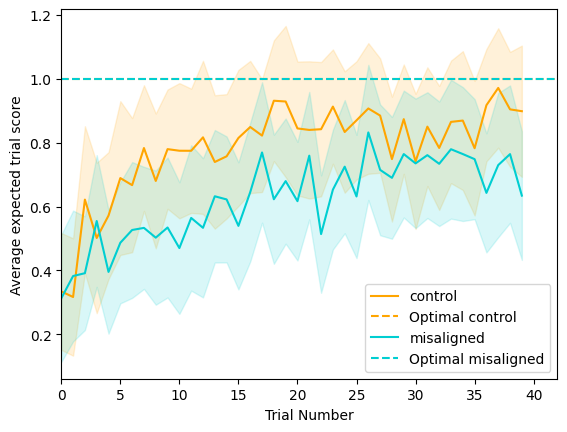

In [292]:
# Plotting mean expected score vs. trial number for each condition

data_to_copy = filtered_data.copy() # all_trials_df, outliers_excluded, or outliers_excluded_part

conditions = {
    0: "control",
    1: "misaligned"
}

# Which metric to use for performance
performance_metric = "expectedScores"
optimal_env_score = {
    "control": 55.89,
    "misaligned": 52.14
}

scale_by_optimal = True

scaling_factor = optimal_env_score if scale_by_optimal else {k: 1 for k in optimal_env_score.keys()}

num_parts = {}
performance_data = {}

# For all conditions
# Find the number of participants, mean value of performance metric for each trial, 
#   and the standard error of the mean for each trial
for idx, cond in conditions.items():
    nump = len(data_to_copy.loc[data_to_copy.condition == idx].groupby('workerId'))
    num_parts[cond] = nump
    performance_data[cond] = {
        "mean": np.array(data_to_copy.loc[data_to_copy.condition == idx].groupby('trialNumbers').mean(numeric_only=True)[performance_metric]) / scaling_factor[cond],
        "se": np.array(data_to_copy.loc[data_to_copy.condition == idx].groupby('trialNumbers').std(numeric_only=True)[performance_metric]) / (np.sqrt(nump) * scaling_factor[cond])
    }

plot_se = True

plot_conds = ["control", "misaligned"]

color_list = ["orange", "darkturquoise", "firebrick"]

plt.figure()
#plt.title("Learning Curves over All Trials")

for idx,cond in enumerate(plot_conds):
    plt.plot(list(range(len(performance_data[cond]["mean"]))), performance_data[cond]["mean"], label=cond, color=color_list[idx])
    if plot_se:
        plt.fill_between(list(range(len(performance_data[cond]["mean"]))), performance_data[cond]["mean"] + 1.96*performance_data[cond]["se"], performance_data[cond]["mean"] - 1.96*performance_data[cond]["se"], alpha=0.15, color=color_list[idx])
    plt.axhline(optimal_env_score[cond]/scaling_factor[cond], color=color_list[idx], label=f"Optimal {cond}", linestyle="--")
#plt.axvline(13, linestyle='--', color='darkturquoise')
#plt.axvline(9, linestyle='--', color='firebrick')


plt.legend(loc="lower right")
#plt.ylim([10,60])
plt.xlim([0, 42])
plt.xlabel("Trial Number")
plt.ylabel("Average expected trial score")
plt.show()



## Actual Scores

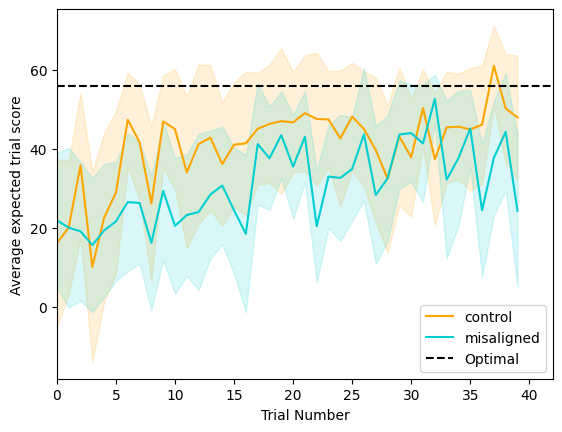

In [293]:
# Plotting mean expected score vs. trial number for each condition

data_to_copy = filtered_data.copy() # all_trials_df, outliers_excluded, or outliers_excluded_part

conditions = {
    0: "control",
    1: "misaligned"
}

# Which metric to use for performance
performance_metric = "trialScores"
optimal_env_score = 55.89

num_parts = {}
performance_data = {}

# For all conditions
# Find the number of participants, mean value of performance metric for each trial, 
#   and the standard error of the mean for each trial
for idx, cond in conditions.items():
    nump = len(data_to_copy.loc[data_to_copy.condition == idx].groupby('workerId'))
    num_parts[cond] = nump
    performance_data[cond] = {
        "mean": np.array(data_to_copy.loc[data_to_copy.condition == idx].groupby('trialNumbers').mean(numeric_only=True)[performance_metric]),
        "se": np.array(data_to_copy.loc[data_to_copy.condition == idx].groupby('trialNumbers').std(numeric_only=True)[performance_metric]) / np.sqrt(nump)
    }

plot_se = True

plot_conds = ["control", "misaligned"]

color_list = ["orange", "darkturquoise", "firebrick"]

plt.figure()
#plt.title("Learning Curves over All Trials")

for idx,cond in enumerate(plot_conds):
    plt.plot(list(range(len(performance_data[cond]["mean"]))), performance_data[cond]["mean"], label=cond, color=color_list[idx])
    if plot_se:
        plt.fill_between(list(range(len(performance_data[cond]["mean"]))), performance_data[cond]["mean"] + 1.96*performance_data[cond]["se"], performance_data[cond]["mean"] - 1.96*performance_data[cond]["se"], alpha=0.15, color=color_list[idx])

#plt.axvline(13, linestyle='--', color='darkturquoise')
#plt.axvline(9, linestyle='--', color='firebrick')
plt.axhline(optimal_env_score, color='k', label='Optimal', linestyle="--")
plt.legend(loc="lower right")
#plt.ylim([10,60])
plt.xlim([0, 42])
plt.xlabel("Trial Number")
plt.ylabel("Average expected trial score")
plt.show()



## Clicks

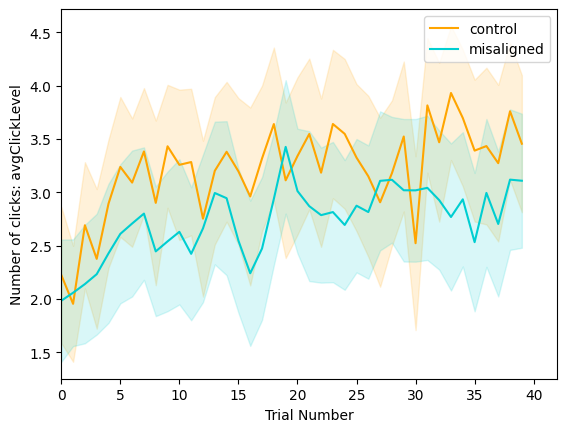

In [294]:
# Plotting mean expected score vs. trial number for each condition

data_to_copy = filtered_data.copy() # all_trials_df, outliers_excluded, or outliers_excluded_part

conditions = {
    0: "control",
    1: "misaligned"
}

# Which metric to use for performance
performance_metric = "avgClickLevel"
optimal_env_score = 5

num_parts = {}
performance_data = {}

# For all conditions
# Find the number of participants, mean value of performance metric for each trial, 
#   and the standard error of the mean for each trial
for idx, cond in conditions.items():
    nump = len(data_to_copy.loc[data_to_copy.condition == idx].groupby('workerId'))
    num_parts[cond] = nump
    performance_data[cond] = {
        "mean": np.array(data_to_copy.loc[data_to_copy.condition == idx].groupby('trialNumbers').mean(numeric_only=True)[performance_metric]),
        "se": np.array(data_to_copy.loc[data_to_copy.condition == idx].groupby('trialNumbers').std(numeric_only=True)[performance_metric]) / np.sqrt(nump)
    }

plot_se = True

plot_conds = ["control", "misaligned"]

color_list = ["orange", "darkturquoise", "firebrick"]

plt.figure()
#plt.title("Learning Curves over All Trials")

for idx,cond in enumerate(plot_conds):
    plt.plot(list(range(len(performance_data[cond]["mean"]))), performance_data[cond]["mean"], label=cond, color=color_list[idx])
    if plot_se:
        plt.fill_between(list(range(len(performance_data[cond]["mean"]))), performance_data[cond]["mean"] + 1.96*performance_data[cond]["se"], performance_data[cond]["mean"] - 1.96*performance_data[cond]["se"], alpha=0.15, color=color_list[idx])

#plt.axvline(13, linestyle='--', color='darkturquoise')
#plt.axvline(9, linestyle='--', color='firebrick')
#plt.axhline(optimal_env_score, color='k', label='Optimal', linestyle="--")
plt.legend()
#plt.ylim([10,60])
plt.xlim([0, 42])
plt.xlabel("Trial Number")
plt.ylabel("Number of clicks: " + performance_metric)
plt.show()



## Strategy Scores

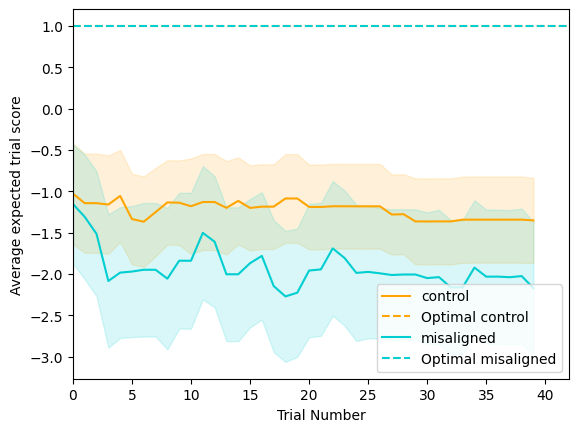

In [295]:
# Plotting mean expected score vs. trial number for each condition

data_to_copy = filtered_data.copy() # all_trials_df, outliers_excluded, or outliers_excluded_part

conditions = {
    0: "control",
    1: "misaligned"
}

# Which metric to use for performance
performance_metric = "strategyScores"
# optimal_env_score = {
#     "control": 55.89,
#     "misaligned": 52.14
# }
optimal_env_score = {
    "control": 31.78,
    "misaligned": 25.29
}

scale_by_optimal = True

scaling_factor = optimal_env_score if scale_by_optimal else {k: 1 for k in optimal_env_score.keys()}

num_parts = {}
performance_data = {}

# For all conditions
# Find the number of participants, mean value of performance metric for each trial, 
#   and the standard error of the mean for each trial
for idx, cond in conditions.items():
    nump = len(data_to_copy.loc[data_to_copy.condition == idx].groupby('workerId'))
    num_parts[cond] = nump
    performance_data[cond] = {
        "mean": np.array(data_to_copy.loc[data_to_copy.condition == idx].groupby('trialNumbers').mean(numeric_only=True)[performance_metric]) / scaling_factor[cond],
        "se": np.array(data_to_copy.loc[data_to_copy.condition == idx].groupby('trialNumbers').std(numeric_only=True)[performance_metric]) / (np.sqrt(nump) * scaling_factor[cond])
    }

plot_se = True

plot_conds = ["control", "misaligned"]

color_list = ["orange", "darkturquoise", "firebrick"]

plt.figure()
#plt.title("Learning Curves over All Trials")

for idx,cond in enumerate(plot_conds):
    plt.plot(list(range(len(performance_data[cond]["mean"]))), performance_data[cond]["mean"], label=cond, color=color_list[idx])
    if plot_se:
        plt.fill_between(list(range(len(performance_data[cond]["mean"]))), performance_data[cond]["mean"] + 1.96*performance_data[cond]["se"], performance_data[cond]["mean"] - 1.96*performance_data[cond]["se"], alpha=0.15, color=color_list[idx])
    plt.axhline(optimal_env_score[cond]/scaling_factor[cond], color=color_list[idx], label=f"Optimal {cond}", linestyle="--")
#plt.axvline(13, linestyle='--', color='darkturquoise')
#plt.axvline(9, linestyle='--', color='firebrick')


plt.legend(loc="lower right")
#plt.ylim([10,60])
plt.xlim([0, 42])
plt.xlabel("Trial Number")
plt.ylabel("Average expected trial score")
plt.show()



# 0.1 - Transforming Response Data

In [340]:
def scale_to_range(arr, lb, ub):
    return ((arr - arr.min()) / (arr.max() - arr.min())) * (ub - lb) + lb

In [348]:
# Selecting the response variable

response_vars = ["expectedScores", "strategyScores", 'expectedScores_scaled', 'avgClickLevel', "clicksL1", "clicksL5", "strategyScores_scaled"]

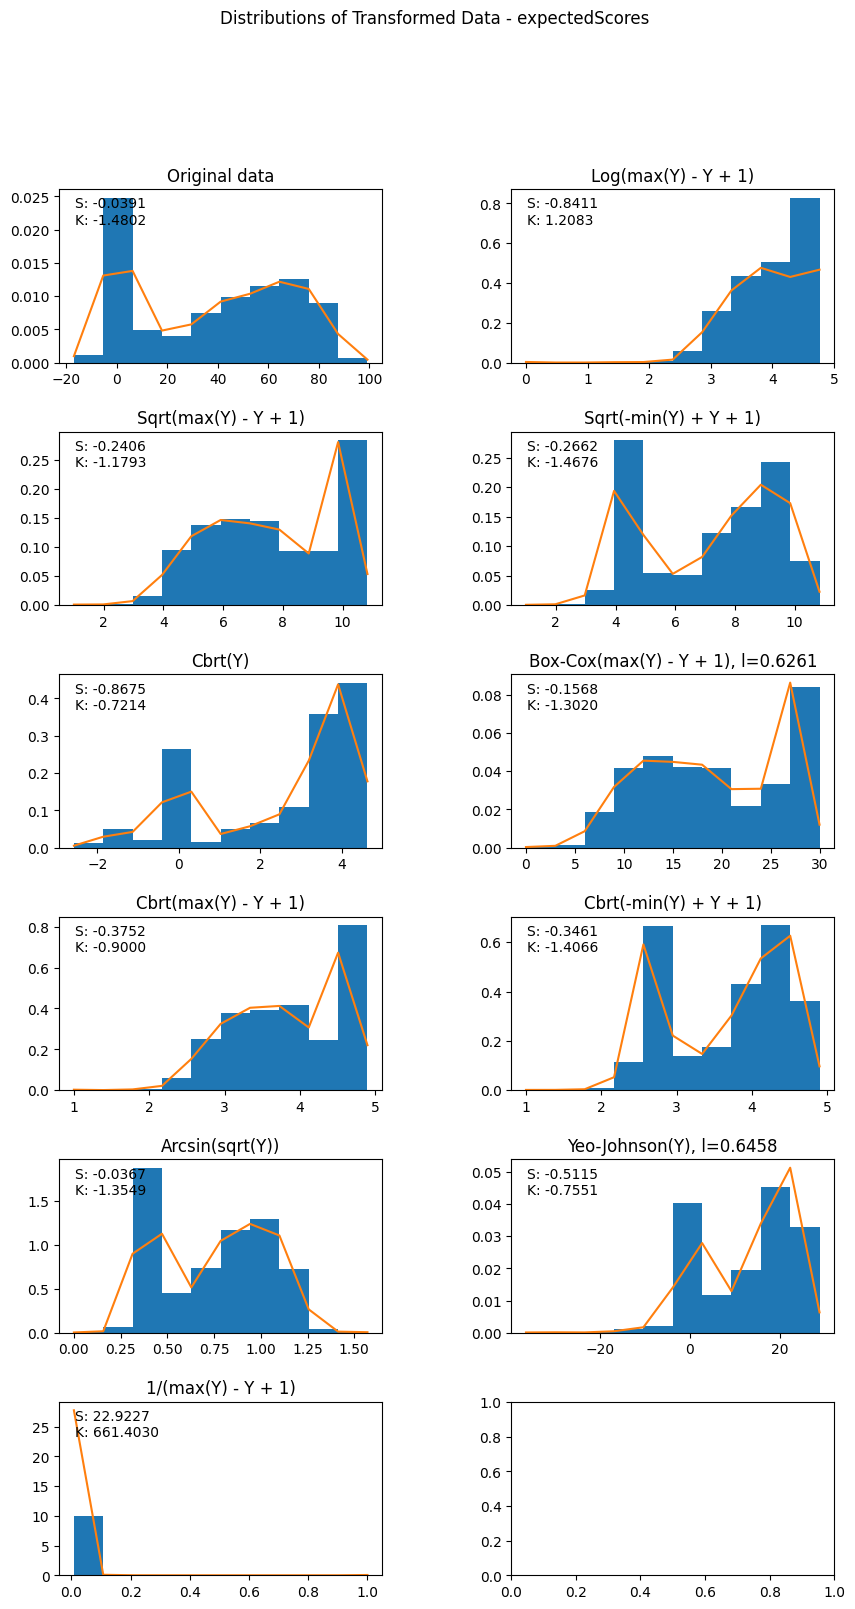

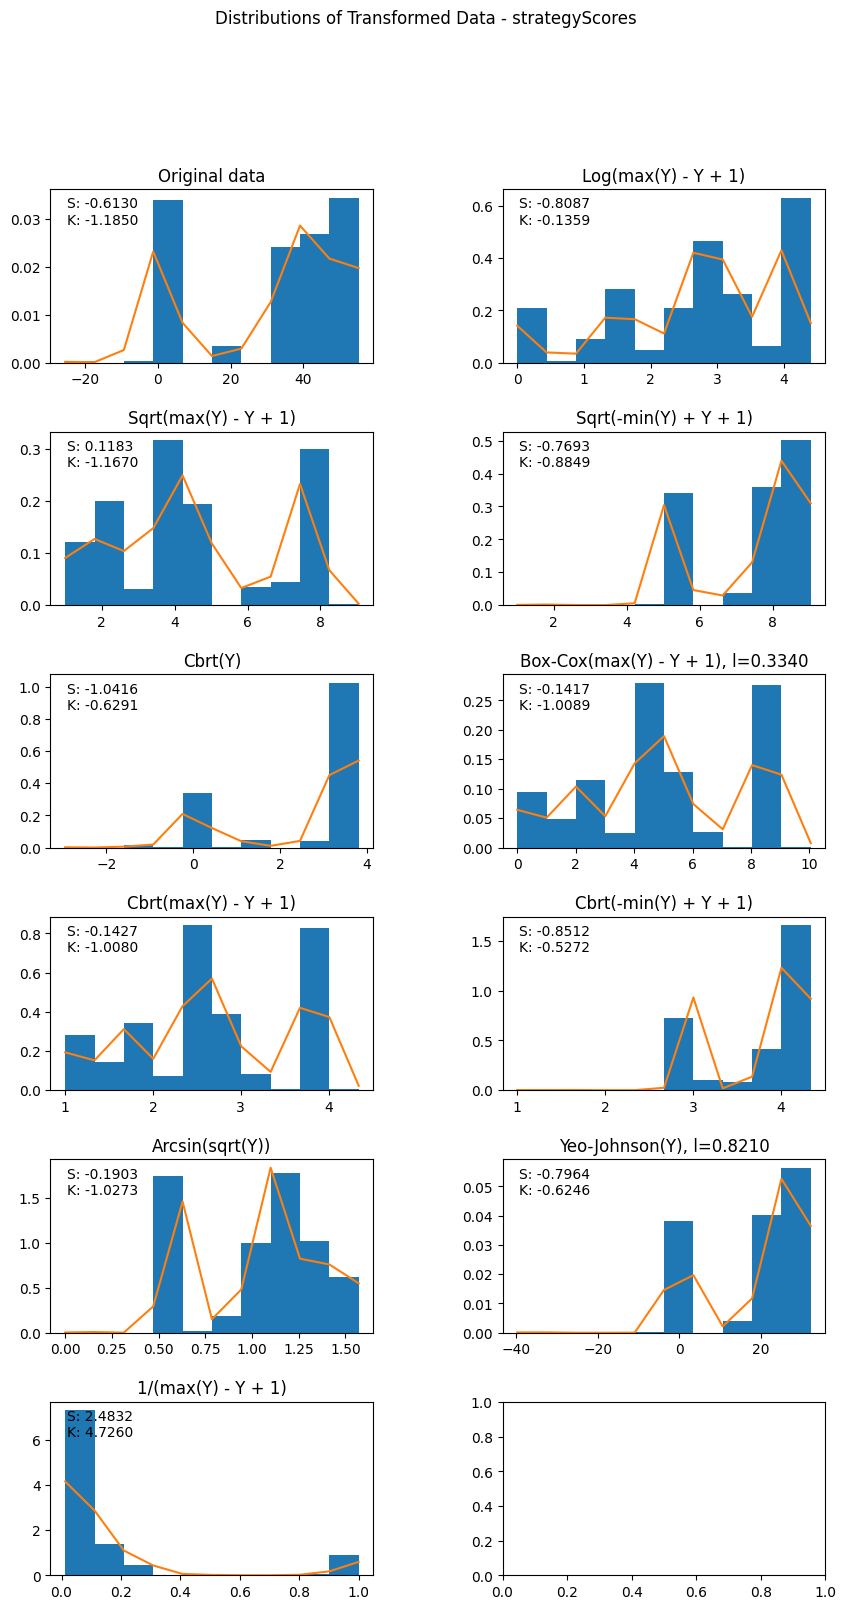

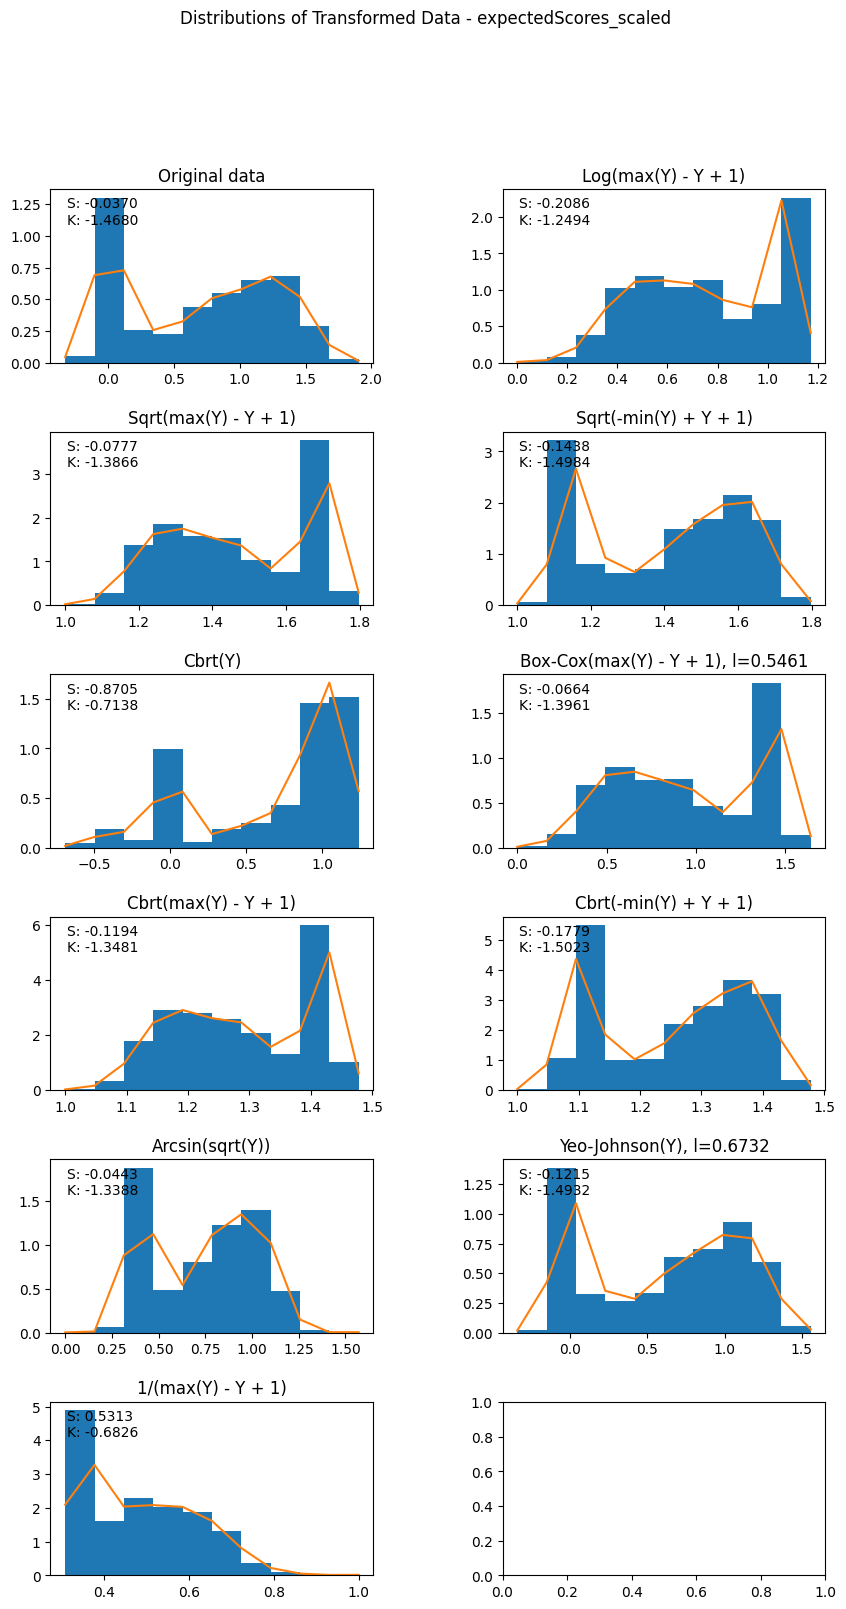

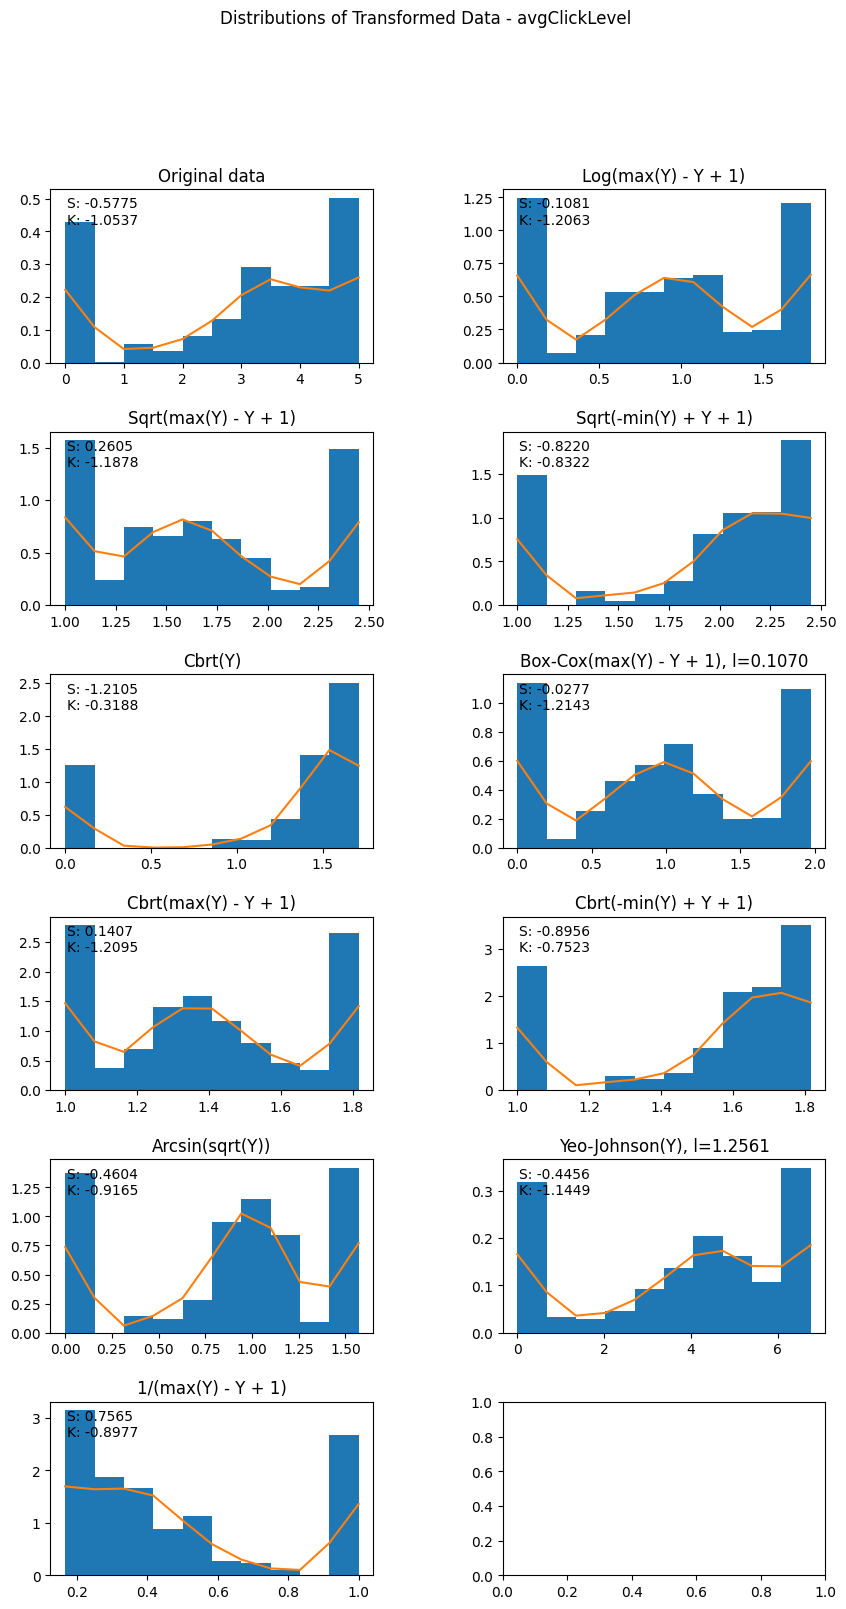

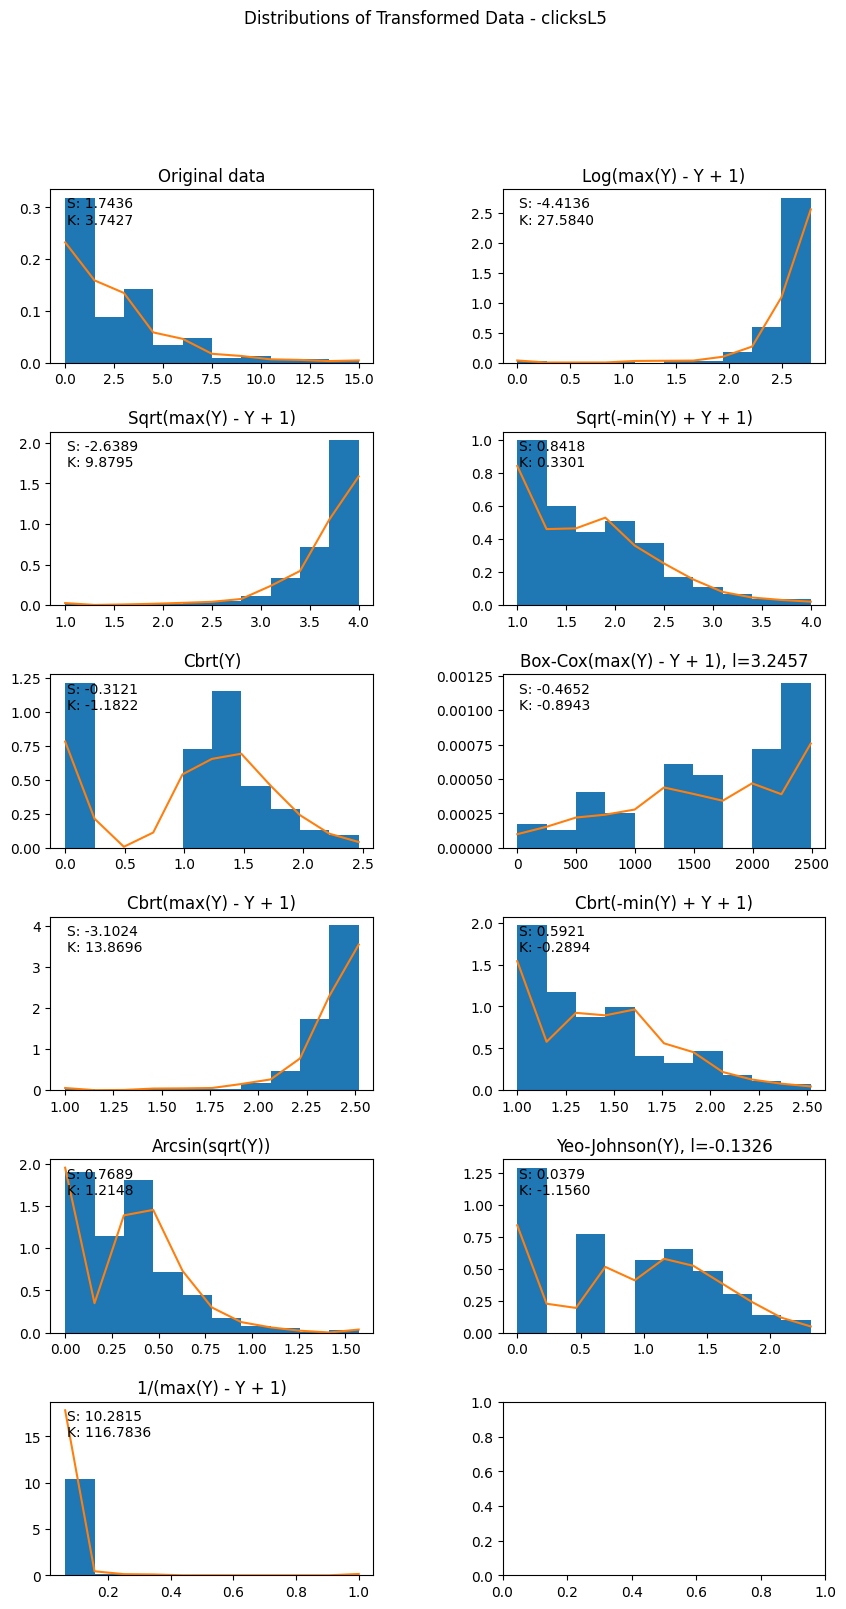

In [349]:
# Transforming the data

data_to_copy = filtered_data.copy() # or outliers_excluded
transformed_trials_df = data_to_copy.copy()
trans_list = {res: [] for res in response_vars}

for response_var in response_vars:
    

    log_transformed_trials_df = data_to_copy.copy()
    sq_transformed_trials_df = data_to_copy.copy()
    sq2_transformed_trials_df = data_to_copy.copy()
    cb_transformed_trials_df = data_to_copy.copy()
    cb2_transformed_trials_df = data_to_copy.copy()
    cb3_transformed_trials_df = data_to_copy.copy()
    arcsin_transformed_trials_df = data_to_copy.copy()
    bc_transformed_trials_df = data_to_copy.copy()
    yj_transformed_trials_df = data_to_copy.copy()
    inverse_transformed_trials_df = data_to_copy.copy()

    # Compute separate dataframes for each transformation
    log_transformed_trials_df[response_var] = np.log(transformed_trials_df[response_var].max() + 1 - transformed_trials_df[response_var])
    sq_transformed_trials_df[response_var] = np.sqrt(transformed_trials_df[response_var].max() + 1 - transformed_trials_df[response_var])
    sq2_transformed_trials_df[response_var] = np.sqrt(-transformed_trials_df[response_var].min() + 1 + transformed_trials_df[response_var])
    cb_transformed_trials_df[response_var] = np.cbrt(transformed_trials_df[response_var])
    cb2_transformed_trials_df[response_var] = np.cbrt(transformed_trials_df[response_var].max() + 1 - transformed_trials_df[response_var])
    cb3_transformed_trials_df[response_var] = np.cbrt(-transformed_trials_df[response_var].min() + 1 + transformed_trials_df[response_var])
    arcsin_transformed_trials_df[response_var] = np.arcsin(np.sqrt(scale_to_range(transformed_trials_df[response_var], 0, 1)))
    bc_transformed_trials_df[response_var],lam = scipy.stats.boxcox(transformed_trials_df[response_var].max() + 1 - transformed_trials_df[response_var])
    #logit_transformed_trials_df[response_var] = scipy.special.logit(scale_to_range(transformed_trials_df[response_var], 0, 1))
    yj_transformed_trials_df[response_var],lam_y = scipy.stats.yeojohnson(transformed_trials_df[response_var])
    inverse_transformed_trials_df[response_var] = 1/(transformed_trials_df[response_var].max() + 1 - transformed_trials_df[response_var])

    # All the transformed data and the corresponding transformation
    trans_list[response_var] = [
        (transformed_trials_df, "Original data"),
        (log_transformed_trials_df, "Log(max(Y) - Y + 1)"),
        (sq_transformed_trials_df, "Sqrt(max(Y) - Y + 1)"),
        (sq2_transformed_trials_df, "Sqrt(-min(Y) + Y + 1)"),
        (cb_transformed_trials_df, "Cbrt(Y)"),
        (bc_transformed_trials_df, "Box-Cox(max(Y) - Y + 1), l={0:0.4f}".format(lam)),
        (cb2_transformed_trials_df, "Cbrt(max(Y) - Y + 1)"),
        (cb3_transformed_trials_df, "Cbrt(-min(Y) + Y + 1)"),
        (arcsin_transformed_trials_df, "Arcsin(sqrt(Y))"),
        (yj_transformed_trials_df, "Yeo-Johnson(Y), l={0:0.4f}".format(lam_y)),
        (inverse_transformed_trials_df, "1/(max(Y) - Y + 1)")
    ]
    
    # Plot all the transformed data
    fig, ax = plt.subplots(nrows=math.ceil(len(trans_list[response_var])/2),ncols=2,figsize=(10, 3 * math.ceil(len(trans_list[response_var])/2)),squeeze=False)
    plt.suptitle("Distributions of Transformed Data - {}".format(response_var))
    ax = ax.flatten()

    for idx, trans in enumerate(trans_list[response_var]):
        data = trans[0][response_var]
        label = trans[1]
        skew = scipy.stats.skew(data)
        density = scipy.stats.gaussian_kde(data)
        kurtosis = scipy.stats.kurtosis(data)
        n, x, _ = ax[idx].hist(data, density=True)
        ax[idx].set_title(label)
        ax[idx].plot(x, density(x))
        ax[idx].text(0.05,0.8, "S: {0:0.4f}\nK: {1:0.4f}".format(skew, kurtosis), transform=ax[idx].transAxes)

    plt.subplots_adjust(
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

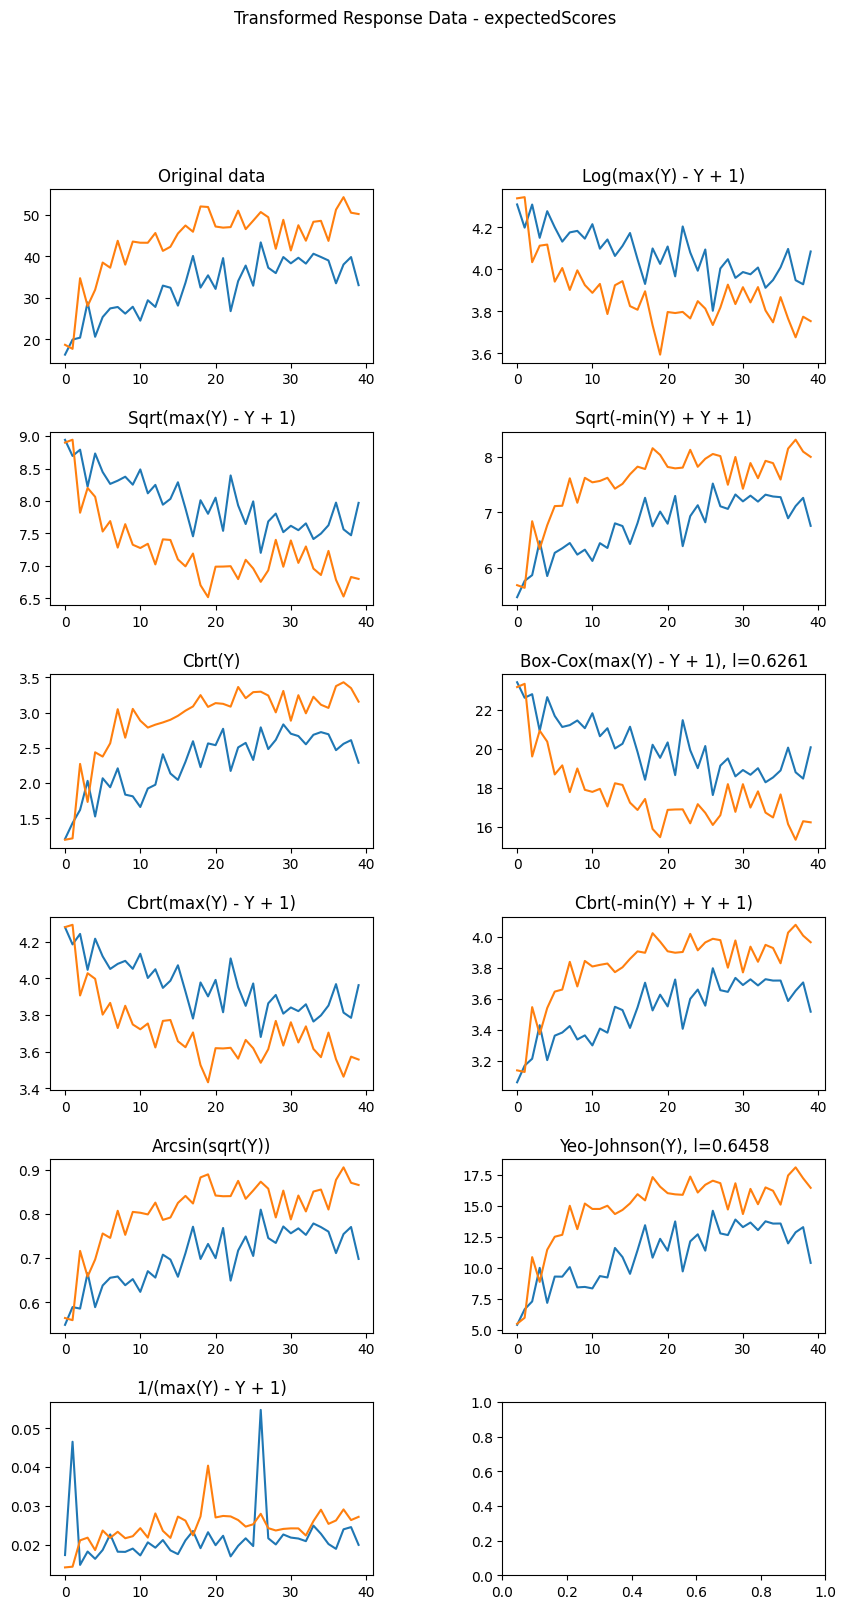

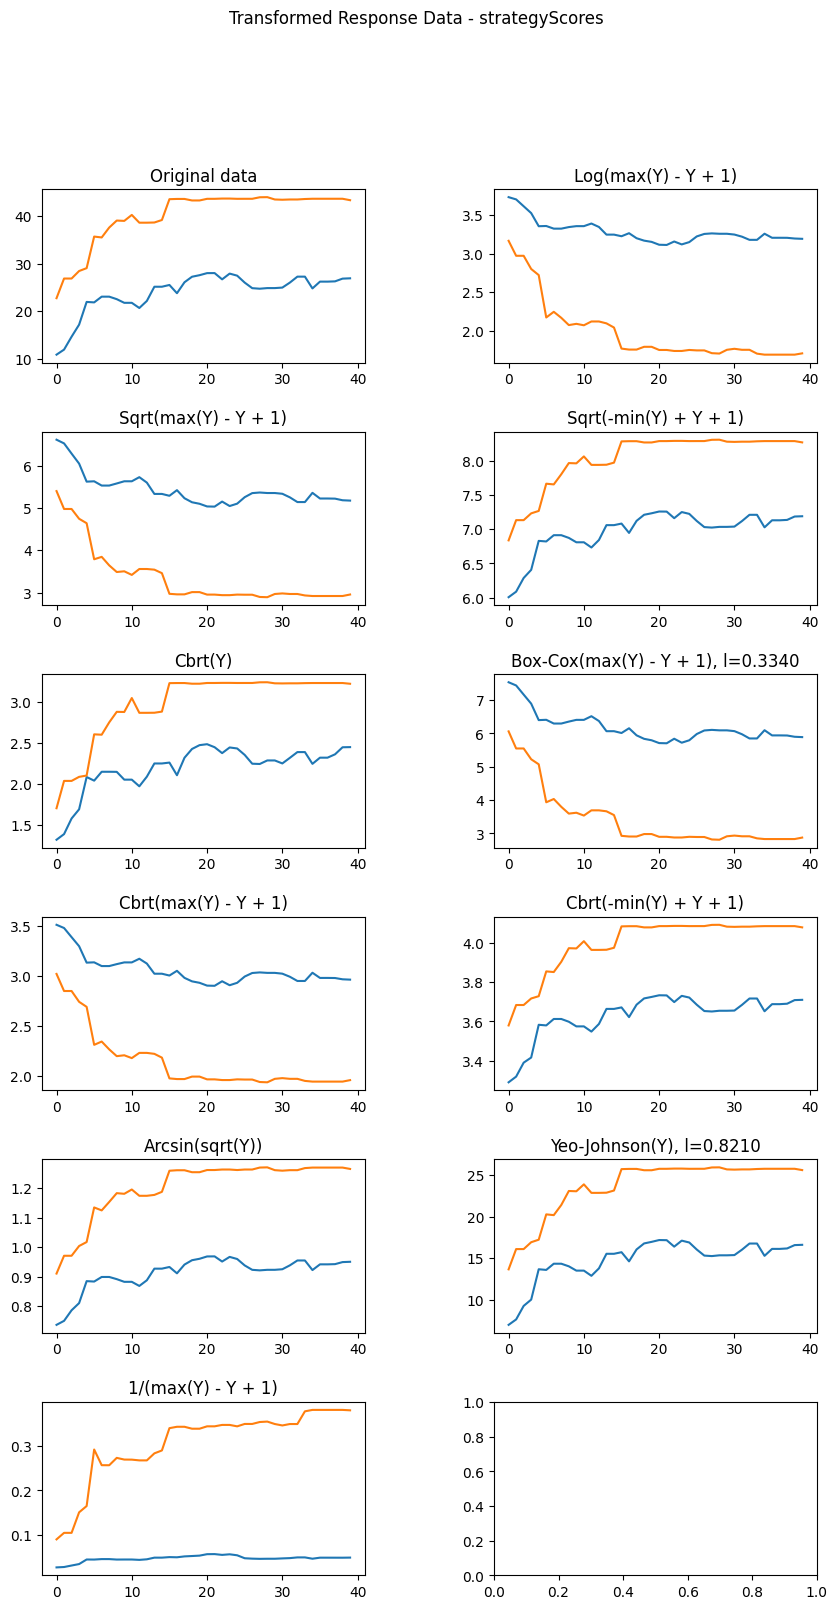

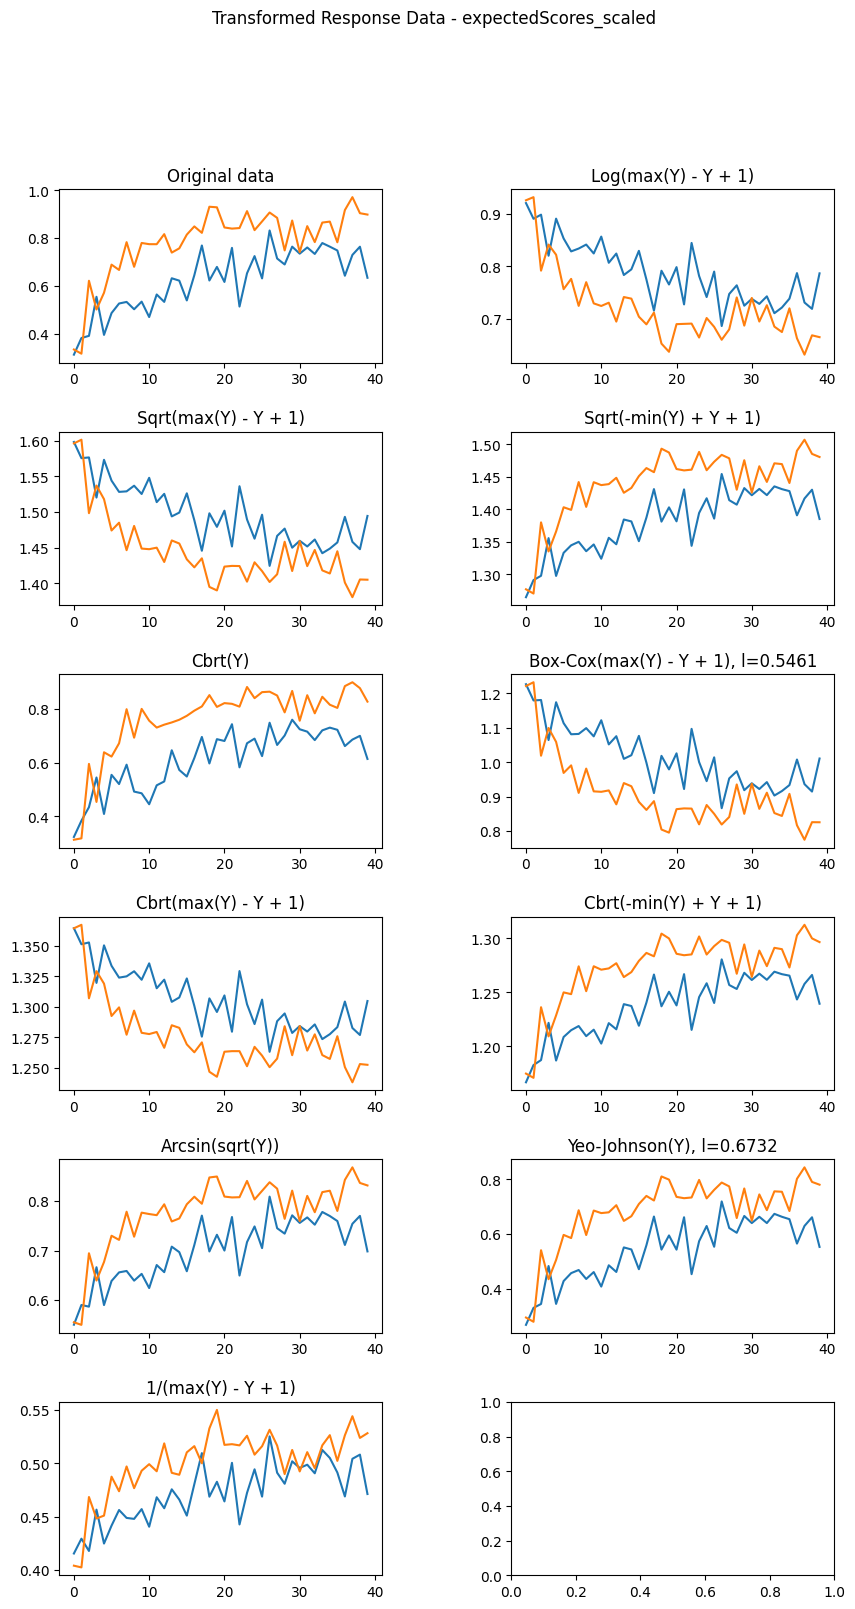

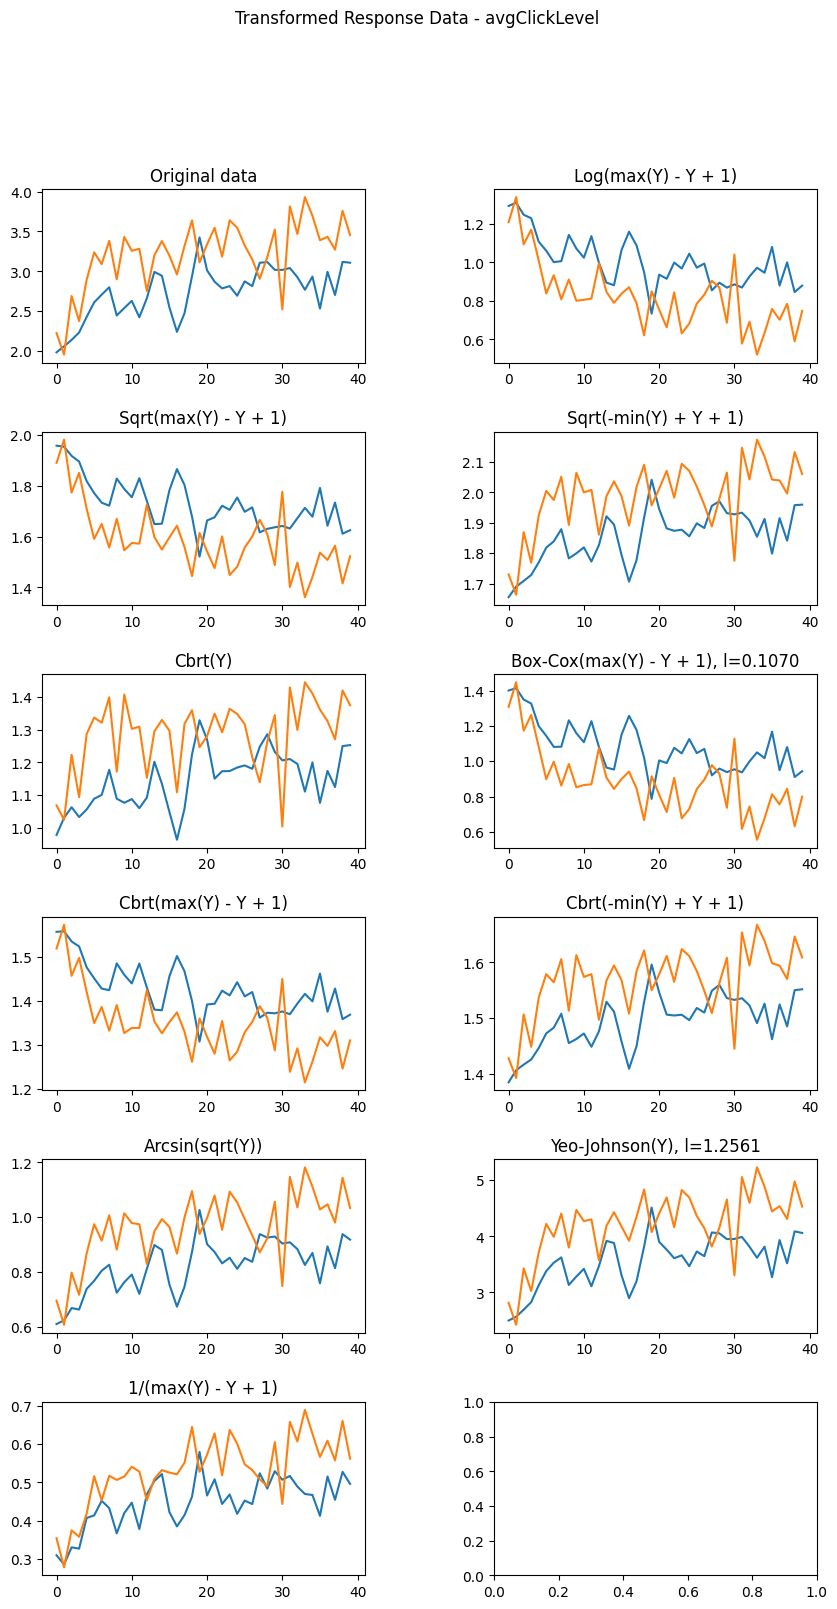

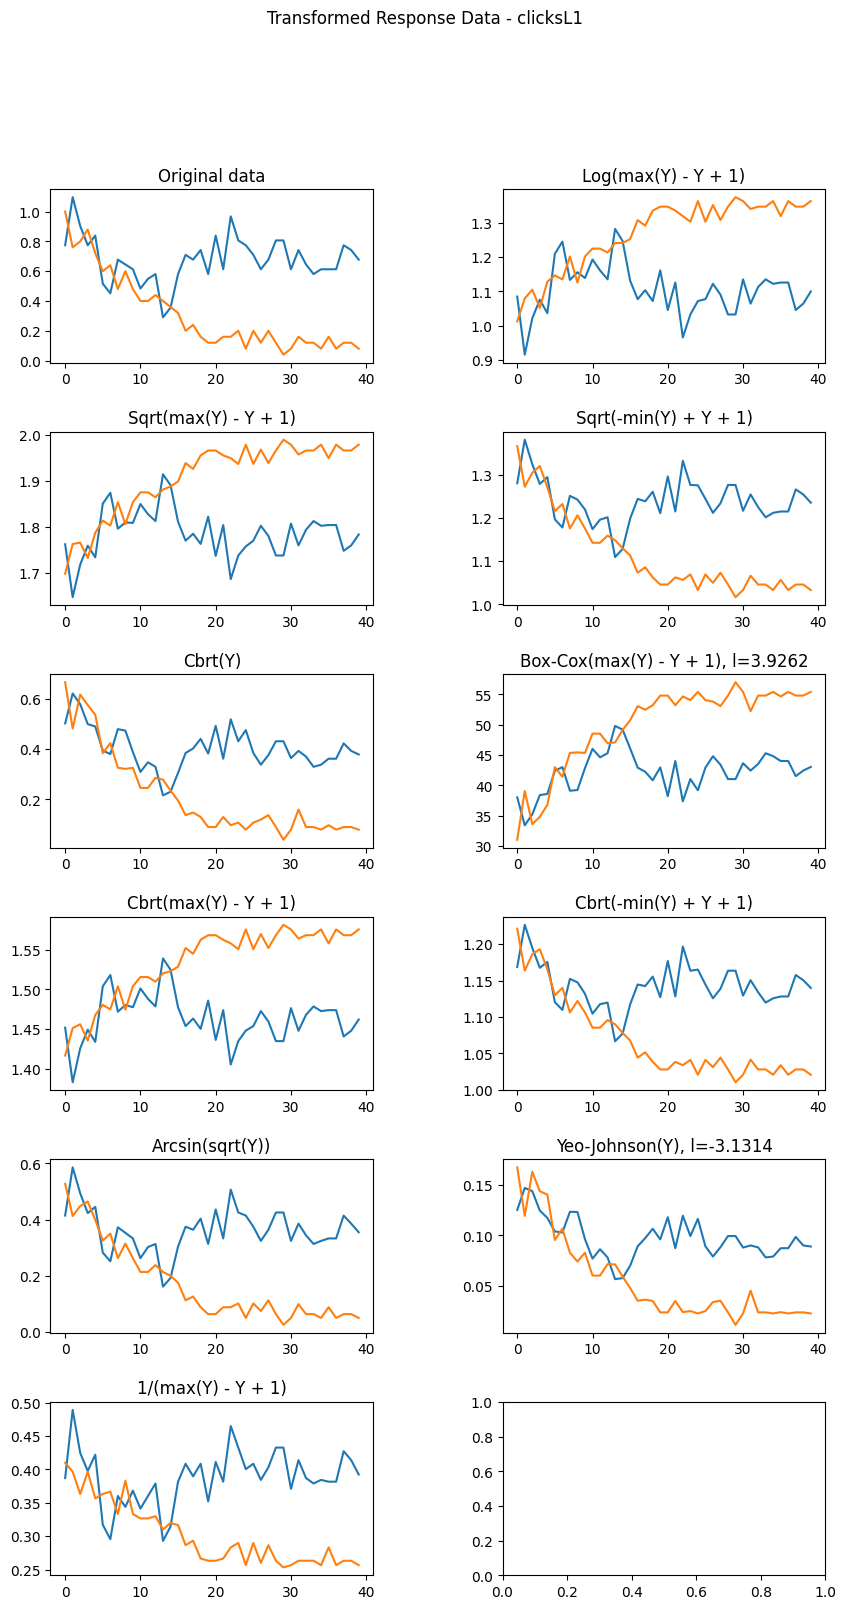

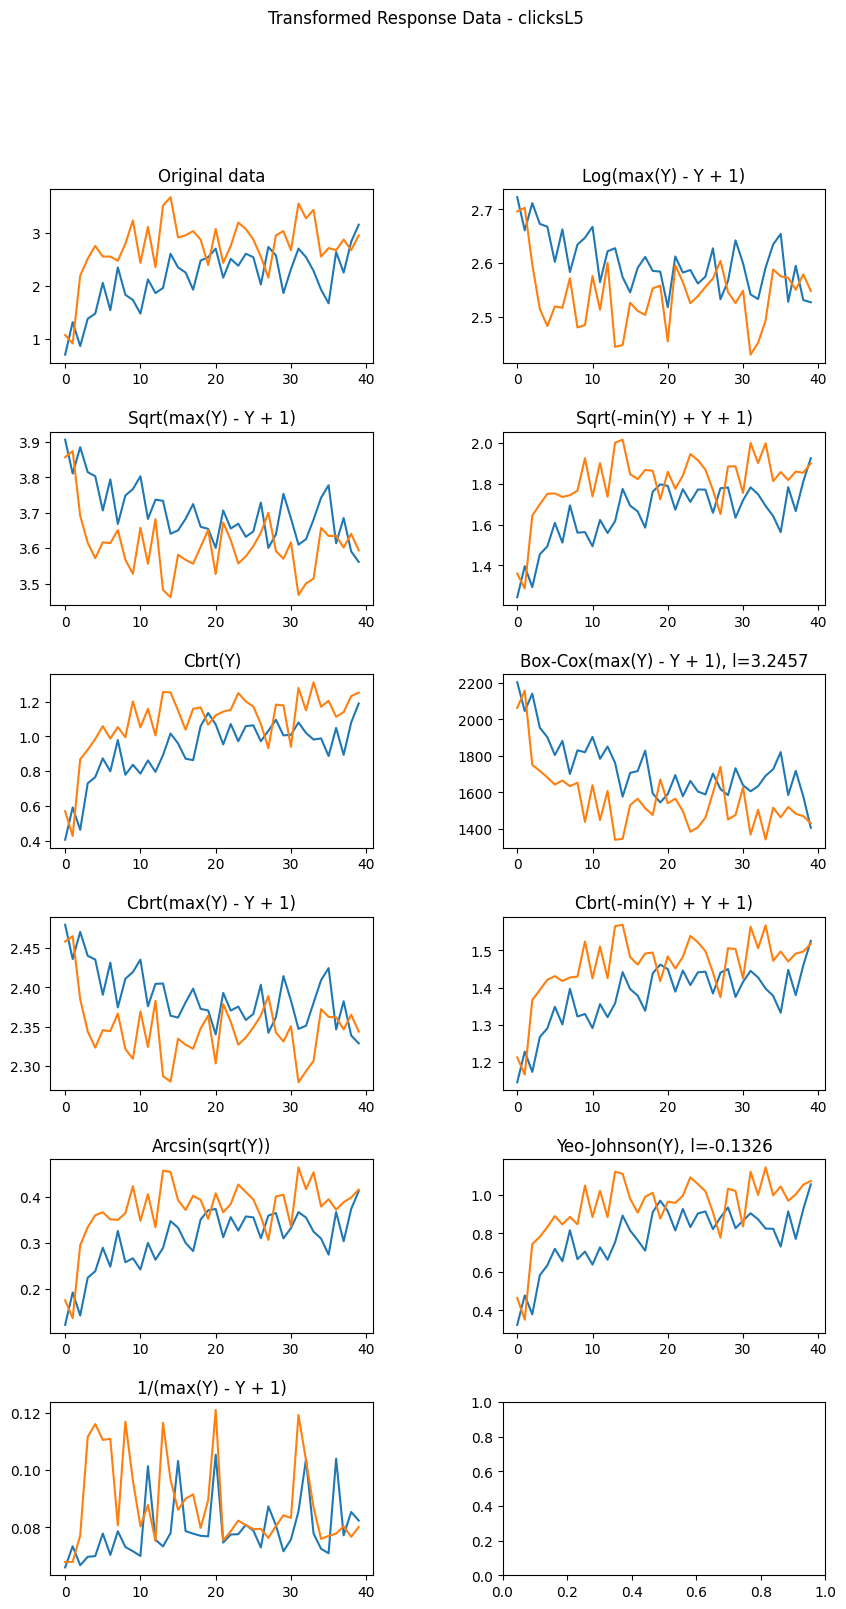

In [351]:
# Plotting the response data

for response_var in response_vars:
    fig, ax = plt.subplots(nrows=math.ceil(len(trans_list[response_var])/2),ncols=2,figsize=(10, 3 * math.ceil(len(trans_list[response_var])/2)),squeeze=False)
    plt.suptitle("Transformed Response Data - {}".format(response_var))
    ax = ax.flatten()

    for idx, trans in enumerate(trans_list[response_var]):
        data = trans[0]
        scarce = data.loc[data.condition == 1]
        control = data.loc[data.condition == 0]
        label = trans[1]

        scarce_mean = np.array(scarce.groupby('trialNumbers').mean(numeric_only=True)[response_var])
        control_mean = np.array(control.groupby('trialNumbers').mean(numeric_only=True)[response_var])
        ax[idx].plot(list(range(len(scarce_mean))), scarce_mean, label="Exp")
        ax[idx].plot(list(range(len(control_mean))), control_mean, label="Control")
        ax[idx].set_title(label)

    plt.subplots_adjust(
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

## Linear Regression: Expected Score vs. Trial Number x Condition

In [352]:
# formula = "expectedScores ~ trialNumbers + C(scarce) + trialNumbers:C(scarce)"

In [353]:
# GLM Model 1 - Expected score vs. Trial number & Condition - all possible transformations

# Creating the list of data to subplot all residuals

all_residuals = {res: [] for res in response_vars}
mixed = True

for response_var in response_vars:
    formula = '{} ~ C(trialNumbers) + C(condition)'.format(response_var);

    # Perform regression on each transformed dataset
    for idx, trans in enumerate(trans_list[response_var]):
        if mixed:
            glm = smf.mixedlm(formula=formula, data=trans[0], groups=trans[0]['workerId'])
        else:
            glm = smf.glm(formula=formula, data=trans[0])

        results = glm.fit()

        print("\n{} - {}:".format(response_var, trans[1]))
        print(results.summary())

        resids = results.resid_response if not mixed else results.resid
        normaltest = scipy.stats.normaltest(resids)
        
        # Save the results of the regression for plotting
        all_residuals[response_var].append((
            resids,
            trans[0][response_var],
            trans[1],
            normaltest
        ))



expectedScores - Original data:
              Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   expectedScores
No. Observations:   2240      Method:               REML          
No. Groups:         56        Scale:                485.7941      
Min. group size:    40        Log-Likelihood:       -10099.2374   
Max. group size:    40        Converged:            Yes           
Mean group size:    40.0                                          
------------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
------------------------------------------------------------------
Intercept              23.602    4.928  4.790 0.000  13.944 33.260
C(trialNumbers)[T.2]    1.576    4.165  0.378 0.705  -6.588  9.740
C(trialNumbers)[T.3]    9.444    4.165  2.267 0.023   1.280 17.608
C(trialNumbers)[T.4]   11.161    4.165  2.679 0.007   2.997 19.325
C(trialNumbers)[T.5]    8.311    4.165  1.99

             Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  expectedScores
No. Observations:   2240     Method:              REML          
No. Groups:         56       Scale:               2.3967        
Min. group size:    40       Log-Likelihood:      -4263.0405    
Max. group size:    40       Converged:           Yes           
Mean group size:    40.0                                        
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              6.028    0.364 16.572 0.000  5.315  6.740
C(trialNumbers)[T.2]   0.141    0.293  0.482 0.630 -0.432  0.714
C(trialNumbers)[T.3]   0.734    0.293  2.509 0.012  0.161  1.307
C(trialNumbers)[T.4]   0.850    0.293  2.904 0.004  0.276  1.423
C(trialNumbers)[T.5]   0.693    0.293  2.367 0.018  0.119  1.266
C(trialNumbers)[T.6]   1.078    0.293  


expectedScores - Cbrt(max(Y) - Y + 1):
             Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  expectedScores
No. Observations:   2240     Method:              REML          
No. Groups:         56       Scale:               0.2960        
Min. group size:    40       Log-Likelihood:      -1952.0307    
Max. group size:    40       Converged:           Yes           
Mean group size:    40.0                                        
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              4.140    0.112 37.064 0.000  3.921  4.359
C(trialNumbers)[T.2]  -0.046    0.103 -0.448 0.654 -0.248  0.155
C(trialNumbers)[T.3]  -0.186    0.103 -1.813 0.070 -0.388  0.015
C(trialNumbers)[T.4]  -0.241    0.103 -2.341 0.019 -0.442 -0.039
C(trialNumbers)[T.5]  -0.160    0.103 -1.559 0.119 -0.362  0.041


expectedScores - Yeo-Johnson(Y), l=0.6458:
             Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  expectedScores
No. Observations:   2240     Method:              REML          
No. Groups:         56       Scale:               52.3217       
Min. group size:    40       Log-Likelihood:      -7651.1142    
Max. group size:    40       Converged:           Yes           
Mean group size:    40.0                                        
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              7.484    1.657  4.517 0.000  4.237 10.731
C(trialNumbers)[T.2]   0.911    1.367  0.667 0.505 -1.768  3.591
C(trialNumbers)[T.3]   3.455    1.367  2.527 0.011  0.775  6.134
C(trialNumbers)[T.4]   4.065    1.367  2.974 0.003  1.386  6.744
C(trialNumbers)[T.5]   3.657    1.367  2.675 0.007  0.978  6

/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



expectedScores - 1/(max(Y) - Y + 1):
             Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  expectedScores
No. Observations:   2240     Method:              REML          
No. Groups:         56       Scale:               0.0011        
Min. group size:    40       Log-Likelihood:      4305.7755     
Max. group size:    40       Converged:           Yes           
Mean group size:    40.0                                        
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              0.017    0.005  3.757 0.000  0.008  0.027
C(trialNumbers)[T.2]   0.016    0.006  2.653 0.008  0.004  0.028
C(trialNumbers)[T.3]   0.002    0.006  0.279 0.780 -0.010  0.014
C(trialNumbers)[T.4]   0.004    0.006  0.641 0.522 -0.008  0.016
C(trialNumbers)[T.5]   0.001    0.006  0.238 0.812 -0.011  0.013
C


strategyScores - Sqrt(max(Y) - Y + 1):
              Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  strategyScores
No. Observations:    2240     Method:              REML          
No. Groups:          56       Scale:               0.9710        
Min. group size:     40       Log-Likelihood:      -3298.6125    
Max. group size:     40       Converged:           Yes           
Mean group size:     40.0                                        
-----------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              4.926    0.353  13.970 0.000  4.235  5.617
C(trialNumbers)[T.2]  -0.237    0.186  -1.275 0.202 -0.602  0.128
C(trialNumbers)[T.3]  -0.371    0.186  -1.992 0.046 -0.736 -0.006
C(trialNumbers)[T.4]  -0.606    0.186  -3.253 0.001 -0.971 -0.241
C(trialNumbers)[T.5]  -0.889    0.186  -4.773 0.00


strategyScores - Box-Cox(max(Y) - Y + 1), l=0.3340:
              Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  strategyScores
No. Observations:    2240     Method:              REML          
No. Groups:          56       Scale:               1.4711        
Min. group size:     40       Log-Likelihood:      -3755.6405    
Max. group size:     40       Converged:           Yes           
Mean group size:     40.0                                        
-----------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              5.351    0.436  12.287 0.000  4.498  6.205
C(trialNumbers)[T.2]  -0.282    0.229  -1.232 0.218 -0.732  0.167
C(trialNumbers)[T.3]  -0.434    0.229  -1.893 0.058 -0.883  0.015
C(trialNumbers)[T.4]  -0.729    0.229  -3.181 0.001 -1.178 -0.280
C(trialNumbers)[T.5]  -1.069    0.229


strategyScores - Arcsin(sqrt(Y)):
             Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  strategyScores
No. Observations:   2240     Method:              REML          
No. Groups:         56       Scale:               0.0212        
Min. group size:    40       Log-Likelihood:      905.5954      
Max. group size:    40       Converged:           Yes           
Mean group size:    40.0                                        
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              0.976    0.052 18.710 0.000  0.874  1.078
C(trialNumbers)[T.2]   0.034    0.028  1.251 0.211 -0.020  0.088
C(trialNumbers)[T.3]   0.054    0.028  1.972 0.049  0.000  0.108
C(trialNumbers)[T.4]   0.083    0.028  2.998 0.003  0.029  0.136
C(trialNumbers)[T.5]   0.130    0.028  4.713 0.000  0.076  0.184
C(tr


expectedScores_scaled - Original data:
               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: expectedScores_scaled
No. Observations: 2240    Method:             REML                 
No. Groups:       56      Scale:              0.1684               
Min. group size:  40      Log-Likelihood:     -1339.3718           
Max. group size:  40      Converged:          Yes                  
Mean group size:  40.0                                             
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.411    0.092  4.470 0.000  0.231  0.591
C(trialNumbers)[T.2]      0.031    0.078  0.397 0.691 -0.121  0.183
C(trialNumbers)[T.3]      0.172    0.078  2.217 0.027  0.020  0.324
C(trialNumbers)[T.4]      0.209    0.078  2.691 0.007  0.057  0.361
C(trialNumbers)[T.5]   


expectedScores_scaled - Cbrt(Y):
               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: expectedScores_scaled
No. Observations: 2240    Method:             REML                 
No. Groups:       56      Scale:              0.1099               
Min. group size:  40      Log-Likelihood:     -877.6562            
Max. group size:  40      Converged:          Yes                  
Mean group size:  40.0                                             
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.402    0.082  4.909 0.000  0.242  0.563
C(trialNumbers)[T.2]      0.036    0.063  0.569 0.569 -0.087  0.158
C(trialNumbers)[T.3]      0.187    0.063  2.981 0.003  0.064  0.309
C(trialNumbers)[T.4]      0.185    0.063  2.949 0.003  0.062  0.307
C(trialNumbers)[T.5]      0.1

/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



expectedScores_scaled - Cbrt(max(Y) - Y + 1):
               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: expectedScores_scaled
No. Observations: 2240    Method:             REML                 
No. Groups:       56      Scale:              0.0071               
Min. group size:  40      Log-Likelihood:     2141.3968            
Max. group size:  40      Converged:          Yes                  
Mean group size:  40.0                                             
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 1.348    0.018 73.883 0.000  1.312  1.384
C(trialNumbers)[T.2]     -0.006    0.016 -0.375 0.708 -0.037  0.025
C(trialNumbers)[T.3]     -0.032    0.016 -2.012 0.044 -0.063 -0.001
C(trialNumbers)[T.4]     -0.041    0.016 -2.540 0.011 -0.072 -0.009
C(trialNumbers)[

/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



expectedScores_scaled - Cbrt(-min(Y) + Y + 1):
               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: expectedScores_scaled
No. Observations: 2240    Method:             REML                 
No. Groups:       56      Scale:              0.0074               
Min. group size:  40      Log-Likelihood:     2098.1534            
Max. group size:  40      Converged:          Yes                  
Mean group size:  40.0                                             
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 1.190    0.020 59.891 0.000  1.151  1.229
C(trialNumbers)[T.2]      0.007    0.016  0.437 0.662 -0.025  0.039
C(trialNumbers)[T.3]      0.039    0.016  2.393 0.017  0.007  0.071
C(trialNumbers)[T.4]      0.046    0.016  2.826 0.005  0.014  0.078
C(trialNumbers)

/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



expectedScores_scaled - 1/(max(Y) - Y + 1):
               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: expectedScores_scaled
No. Observations: 2240    Method:             REML                 
No. Groups:       56      Scale:              0.0108               
Min. group size:  40      Log-Likelihood:     1693.1557            
Max. group size:  40      Converged:          Yes                  
Mean group size:  40.0                                             
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.426    0.021 20.588 0.000  0.385  0.467
C(trialNumbers)[T.2]      0.007    0.020  0.356 0.722 -0.031  0.045
C(trialNumbers)[T.3]      0.030    0.020  1.536 0.125 -0.008  0.069
C(trialNumbers)[T.4]      0.043    0.020  2.172 0.030  0.004  0.081
C(trialNumbers)[T.

             Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  avgClickLevel
No. Observations:    2240     Method:              REML         
No. Groups:          56       Scale:               0.1340       
Min. group size:     40       Log-Likelihood:      -1092.7220   
Max. group size:     40       Converged:           Yes          
Mean group size:     40.0                                       
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              1.851    0.087 21.312 0.000  1.680  2.021
C(trialNumbers)[T.2]   0.038    0.069  0.556 0.578 -0.097  0.174
C(trialNumbers)[T.3]  -0.075    0.069 -1.078 0.281 -0.210  0.061
C(trialNumbers)[T.4]  -0.052    0.069 -0.758 0.448 -0.188  0.083
C(trialNumbers)[T.5]  -0.158    0.069 -2.281 0.023 -0.293 -0.022
C(trialNumbers)[T.6]  -0.237    0.069 -

             Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  avgClickLevel
No. Observations:    2240     Method:              REML         
No. Groups:          56       Scale:               0.2636       
Min. group size:     40       Log-Likelihood:      -1832.7576   
Max. group size:     40       Converged:           Yes          
Mean group size:     40.0                                       
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              1.251    0.116 10.799 0.000  1.024  1.478
C(trialNumbers)[T.2]   0.070    0.097  0.718 0.473 -0.121  0.260
C(trialNumbers)[T.3]  -0.088    0.097 -0.910 0.363 -0.279  0.102
C(trialNumbers)[T.4]  -0.061    0.097 -0.631 0.528 -0.251  0.129
C(trialNumbers)[T.5]  -0.212    0.097 -2.189 0.029 -0.403 -0.022
C(trialNumbers)[T.6]  -0.325    0.097 -

             Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  avgClickLevel
No. Observations:    2240     Method:              REML         
No. Groups:          56       Scale:               0.1407       
Min. group size:     40       Log-Likelihood:      -1149.9153   
Max. group size:     40       Converged:           Yes          
Mean group size:     40.0                                       
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              0.727    0.093  7.843 0.000  0.545  0.908
C(trialNumbers)[T.2]  -0.032    0.071 -0.452 0.651 -0.171  0.107
C(trialNumbers)[T.3]   0.078    0.071  1.097 0.272 -0.061  0.217
C(trialNumbers)[T.4]   0.039    0.071  0.546 0.585 -0.100  0.178
C(trialNumbers)[T.5]   0.148    0.071  2.083 0.037  0.009  0.287
C(trialNumbers)[T.6]   0.212    0.071  


clicksL1 - Log(max(Y) - Y + 1):
             Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    clicksL1 
No. Observations:    2240       Method:                REML     
No. Groups:          56         Scale:                 0.0942   
Min. group size:     40         Log-Likelihood:        -705.8372
Max. group size:     40         Converged:             Yes      
Mean group size:     40.0                                       
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              1.143    0.073 15.557 0.000  0.999  1.287
C(trialNumbers)[T.2]  -0.064    0.058 -1.103 0.270 -0.178  0.050
C(trialNumbers)[T.3]   0.006    0.058  0.109 0.913 -0.107  0.120
C(trialNumbers)[T.4]   0.012    0.058  0.213 0.831 -0.101  0.126
C(trialNumbers)[T.5]   0.025    0.058  0.427 0.670 -0.089  0.138
C(tria


clicksL1 - Cbrt(Y):
             Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   clicksL1  
No. Observations:     2240      Method:               REML      
No. Groups:           56        Scale:                0.1281    
Min. group size:      40        Log-Likelihood:       -1050.3676
Max. group size:      40        Converged:            Yes       
Mean group size:      40.0                                      
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              0.471    0.093  5.041 0.000  0.288  0.654
C(trialNumbers)[T.2]  -0.016    0.068 -0.239 0.811 -0.149  0.116
C(trialNumbers)[T.3]   0.020    0.068  0.302 0.763 -0.112  0.153
C(trialNumbers)[T.4]  -0.042    0.068 -0.617 0.537 -0.174  0.091
C(trialNumbers)[T.5]  -0.064    0.068 -0.950 0.342 -0.197  0.068
C(trialNumbers)[T.


clicksL1 - Cbrt(-min(Y) + Y + 1):
             Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    clicksL1 
No. Observations:    2240       Method:                REML     
No. Groups:          56         Scale:                 0.0181   
Min. group size:     40         Log-Likelihood:        1104.7922
Max. group size:     40         Converged:             Yes      
Mean group size:     40.0                                       
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              1.152    0.034 33.720 0.000  1.085  1.219
C(trialNumbers)[T.2]   0.006    0.025  0.247 0.805 -0.044  0.056
C(trialNumbers)[T.3]  -0.001    0.025 -0.045 0.964 -0.051  0.049
C(trialNumbers)[T.4]  -0.013    0.025 -0.520 0.603 -0.063  0.037
C(trialNumbers)[T.5]  -0.021    0.025 -0.831 0.406 -0.071  0.029
C(tr

/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



clicksL1 - Yeo-Johnson(Y), l=-3.1314:
             Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    clicksL1 
No. Observations:    2240       Method:                REML     
No. Groups:          56         Scale:                 0.0075   
Min. group size:     40         Log-Likelihood:        2074.0752
Max. group size:     40         Converged:             Yes      
Mean group size:     40.0                                       
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              0.121    0.023  5.346 0.000  0.076  0.165
C(trialNumbers)[T.2]  -0.009    0.016 -0.579 0.563 -0.041  0.023
C(trialNumbers)[T.3]   0.008    0.016  0.511 0.610 -0.024  0.040
C(trialNumbers)[T.4]  -0.011    0.016 -0.669 0.503 -0.043  0.021
C(trialNumbers)[T.5]  -0.016    0.016 -1.007 0.314 -0.048  0.016



clicksL5 - Log(max(Y) - Y + 1):
             Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    clicksL5 
No. Observations:    2240       Method:                REML     
No. Groups:          56         Scale:                 0.0695   
Min. group size:     40         Log-Likelihood:        -351.4039
Max. group size:     40         Converged:             Yes      
Mean group size:     40.0                                       
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              2.677    0.050 53.593 0.000  2.579  2.775
C(trialNumbers)[T.2]  -0.031    0.050 -0.629 0.530 -0.129  0.066
C(trialNumbers)[T.3]  -0.050    0.050 -1.011 0.312 -0.148  0.047
C(trialNumbers)[T.4]  -0.109    0.050 -2.184 0.029 -0.207 -0.011
C(trialNumbers)[T.5]  -0.126    0.050 -2.530 0.011 -0.224 -0.028
C(tria


clicksL5 - Cbrt(Y):
             Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   clicksL5  
No. Observations:     2240      Method:               REML      
No. Groups:           56        Scale:                0.2245    
Min. group size:      40        Log-Likelihood:       -1666.5373
Max. group size:      40        Converged:            Yes       
Mean group size:      40.0                                      
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              0.570    0.122  4.671 0.000  0.331  0.810
C(trialNumbers)[T.2]   0.039    0.090  0.441 0.659 -0.136  0.215
C(trialNumbers)[T.3]   0.165    0.090  1.844 0.065 -0.010  0.341
C(trialNumbers)[T.4]   0.338    0.090  3.778 0.000  0.163  0.514
C(trialNumbers)[T.5]   0.385    0.090  4.305 0.000  0.210  0.561
C(trialNumbers)[T.

             Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    clicksL5 
No. Observations:    2240       Method:                REML     
No. Groups:          56         Scale:                 0.0675   
Min. group size:     40         Log-Likelihood:        -336.8746
Max. group size:     40         Converged:             Yes      
Mean group size:     40.0                                       
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              1.222    0.061 20.161 0.000  1.103  1.341
C(trialNumbers)[T.2]   0.025    0.049  0.515 0.607 -0.071  0.121
C(trialNumbers)[T.3]   0.085    0.049  1.722 0.085 -0.012  0.181
C(trialNumbers)[T.4]   0.148    0.049  3.025 0.002  0.052  0.245
C(trialNumbers)[T.5]   0.174    0.049  3.538 0.000  0.077  0.270
C(trialNumbers)[T.6]   0.210    0.049  

/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/Volumes/DataDrive/mcl-misalignme


clicksL5 - 1/(max(Y) - Y + 1):
             Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    clicksL5 
No. Observations:    2240       Method:                REML     
No. Groups:          56         Scale:                 0.0049   
Min. group size:     40         Log-Likelihood:        2567.2722
Max. group size:     40         Converged:             No       
Mean group size:     40.0                                       
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              0.072    0.013  5.760 0.000  0.048  0.097
C(trialNumbers)[T.2]   0.004    0.013  0.309 0.757 -0.022  0.030
C(trialNumbers)[T.3]   0.005    0.013  0.344 0.731 -0.021  0.031
C(trialNumbers)[T.4]   0.022    0.013  1.629 0.103 -0.004  0.048
C(trialNumbers)[T.5]   0.024    0.013  1.790 0.073 -0.002  0.050
C(trial


strategyScores_scaled - Sqrt(max(Y) - Y + 1):
               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: strategyScores_scaled
No. Observations: 2240    Method:             REML                 
No. Groups:       56      Scale:              0.0055               
Min. group size:  40      Log-Likelihood:     2386.7594            
Max. group size:  40      Converged:          Yes                  
Mean group size:  40.0                                             
-------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                1.237    0.026  47.163 0.000  1.185  1.288
C(trialNumbers)[T.2]    -0.018    0.014  -1.270 0.204 -0.045  0.010
C(trialNumbers)[T.3]    -0.029    0.014  -2.089 0.037 -0.057 -0.002
C(trialNumbers)[T.4]    -0.046    0.014  -3.277 0.001 -0.074 -0.018
C(trialNumbers)[


strategyScores_scaled - Box-Cox(max(Y) - Y + 1), l=-1.5412:
               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: strategyScores_scaled
No. Observations: 2240    Method:             REML                 
No. Groups:       56      Scale:              0.0047               
Min. group size:  40      Log-Likelihood:     2552.7021            
Max. group size:  40      Converged:          Yes                  
Mean group size:  40.0                                             
-------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                0.265    0.024  10.967 0.000  0.218  0.312
C(trialNumbers)[T.2]    -0.016    0.013  -1.220 0.222 -0.041  0.010
C(trialNumbers)[T.3]    -0.026    0.013  -1.969 0.049 -0.051 -0.000
C(trialNumbers)[T.4]    -0.042    0.013  -3.263 0.001 -0.068 -0.017
C(

/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



strategyScores_scaled - Cbrt(max(Y) - Y + 1):
               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: strategyScores_scaled
No. Observations: 2240    Method:             REML                 
No. Groups:       56      Scale:              0.0021               
Min. group size:  40      Log-Likelihood:     3431.4666            
Max. group size:  40      Converged:          Yes                  
Mean group size:  40.0                                             
-------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                1.150    0.016  70.490 0.000  1.118  1.181
C(trialNumbers)[T.2]    -0.011    0.009  -1.269 0.205 -0.028  0.006
C(trialNumbers)[T.3]    -0.018    0.009  -2.085 0.037 -0.035 -0.001
C(trialNumbers)[T.4]    -0.029    0.009  -3.288 0.001 -0.046 -0.012
C(trialNumbers)[

/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



strategyScores_scaled - Cbrt(-min(Y) + Y + 1):
               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: strategyScores_scaled
No. Observations: 2240    Method:             REML                 
No. Groups:       56      Scale:              0.0016               
Min. group size:  40      Log-Likelihood:     3728.2468            
Max. group size:  40      Converged:          Yes                  
Mean group size:  40.0                                             
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 1.238    0.014 87.282 0.000  1.210  1.266
C(trialNumbers)[T.2]      0.010    0.008  1.265 0.206 -0.005  0.025
C(trialNumbers)[T.3]      0.016    0.008  2.091 0.036  0.001  0.031
C(trialNumbers)[T.4]      0.024    0.008  3.126 0.002  0.009  0.039
C(trialNumbers)


strategyScores_scaled - 1/(max(Y) - Y + 1):
               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: strategyScores_scaled
No. Observations: 2240    Method:             REML                 
No. Groups:       56      Scale:              0.0069               
Min. group size:  40      Log-Likelihood:     2145.0157            
Max. group size:  40      Converged:          Yes                  
Mean group size:  40.0                                             
-------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                 0.696    0.029 23.841 0.000  0.639  0.753
C(trialNumbers)[T.2]      0.019    0.016  1.241 0.214 -0.011  0.050
C(trialNumbers)[T.3]      0.032    0.016  2.016 0.044  0.001  0.062
C(trialNumbers)[T.4]      0.052    0.016  3.298 0.001  0.021  0.082
C(trialNumbers)[T.

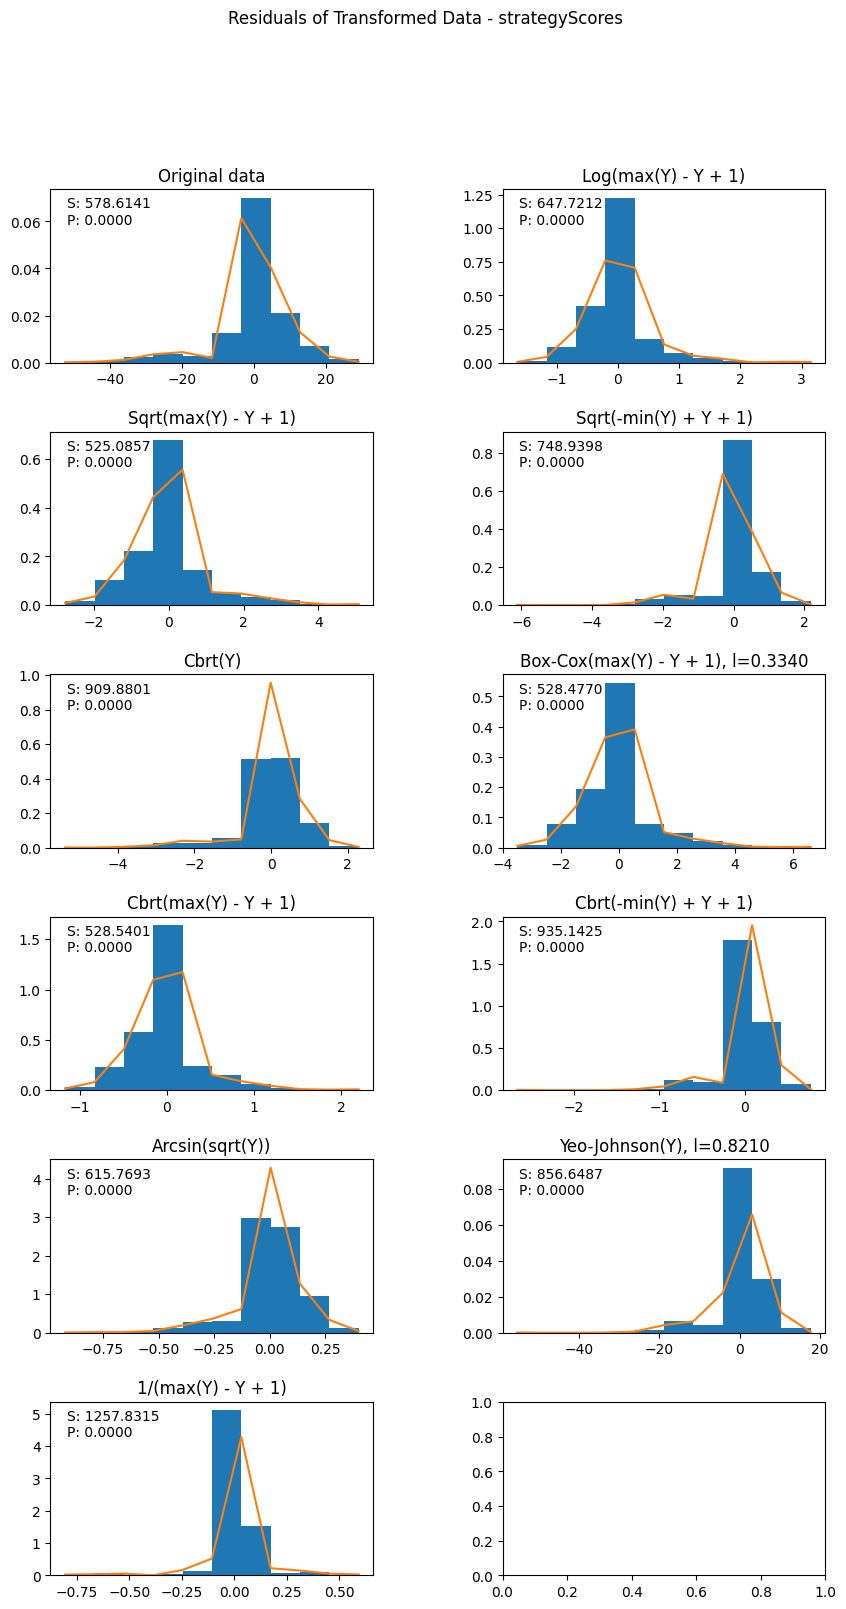

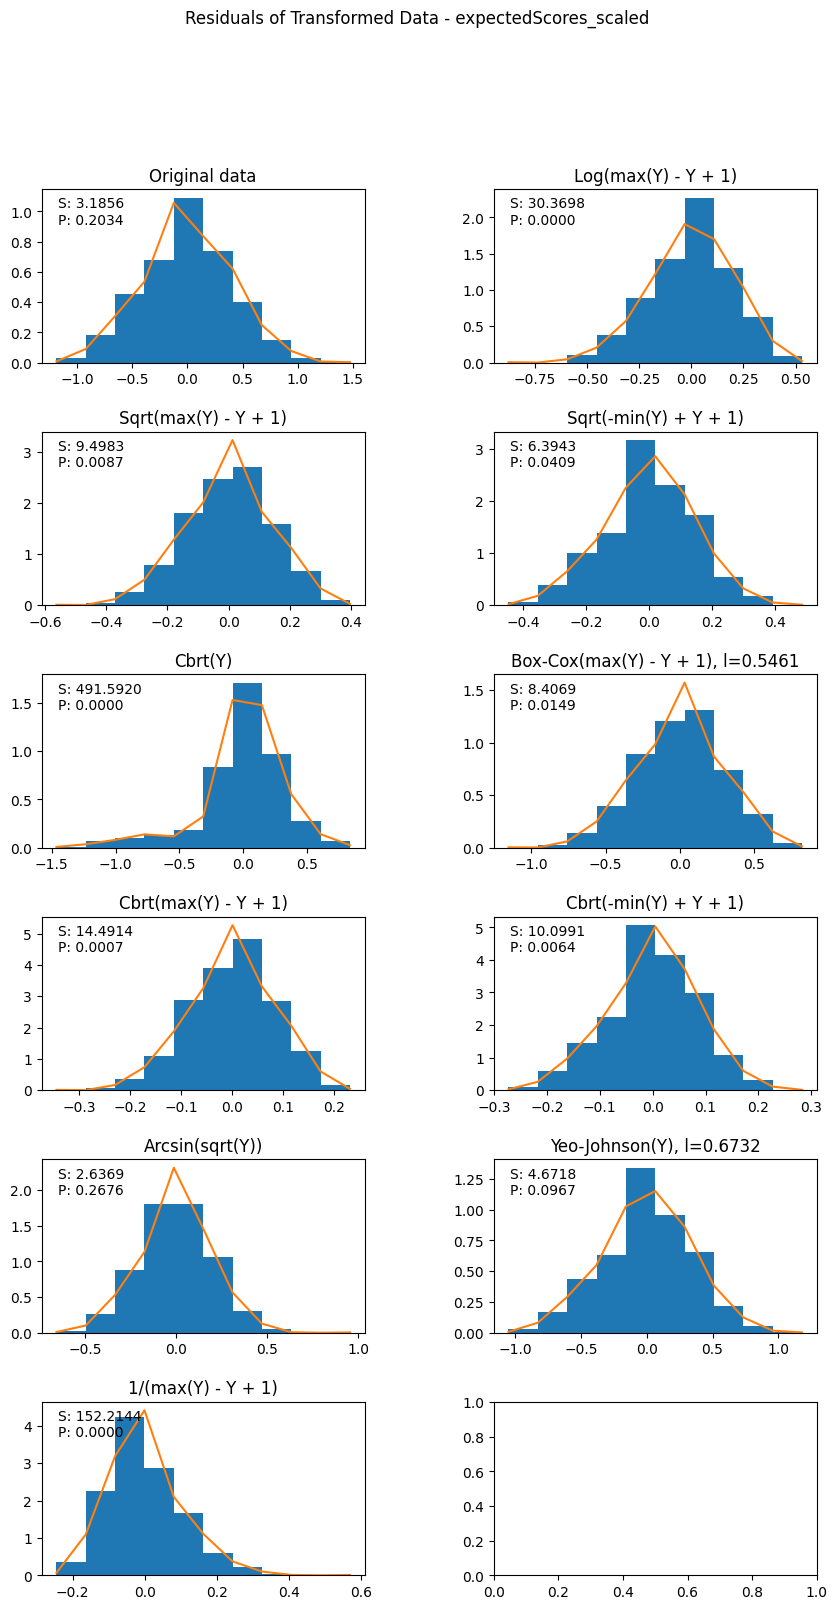

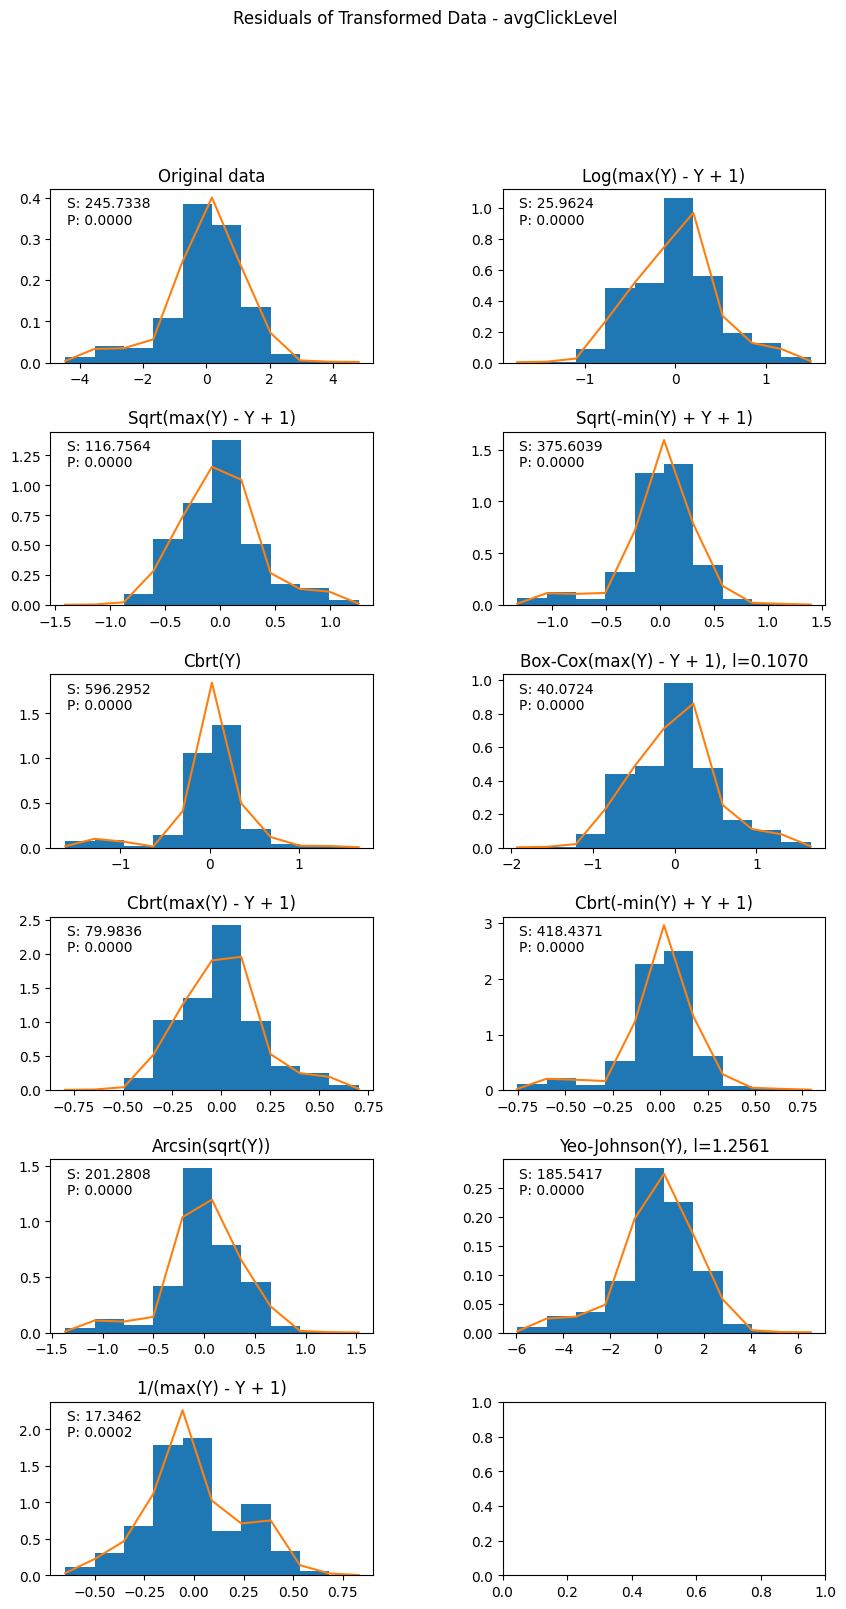

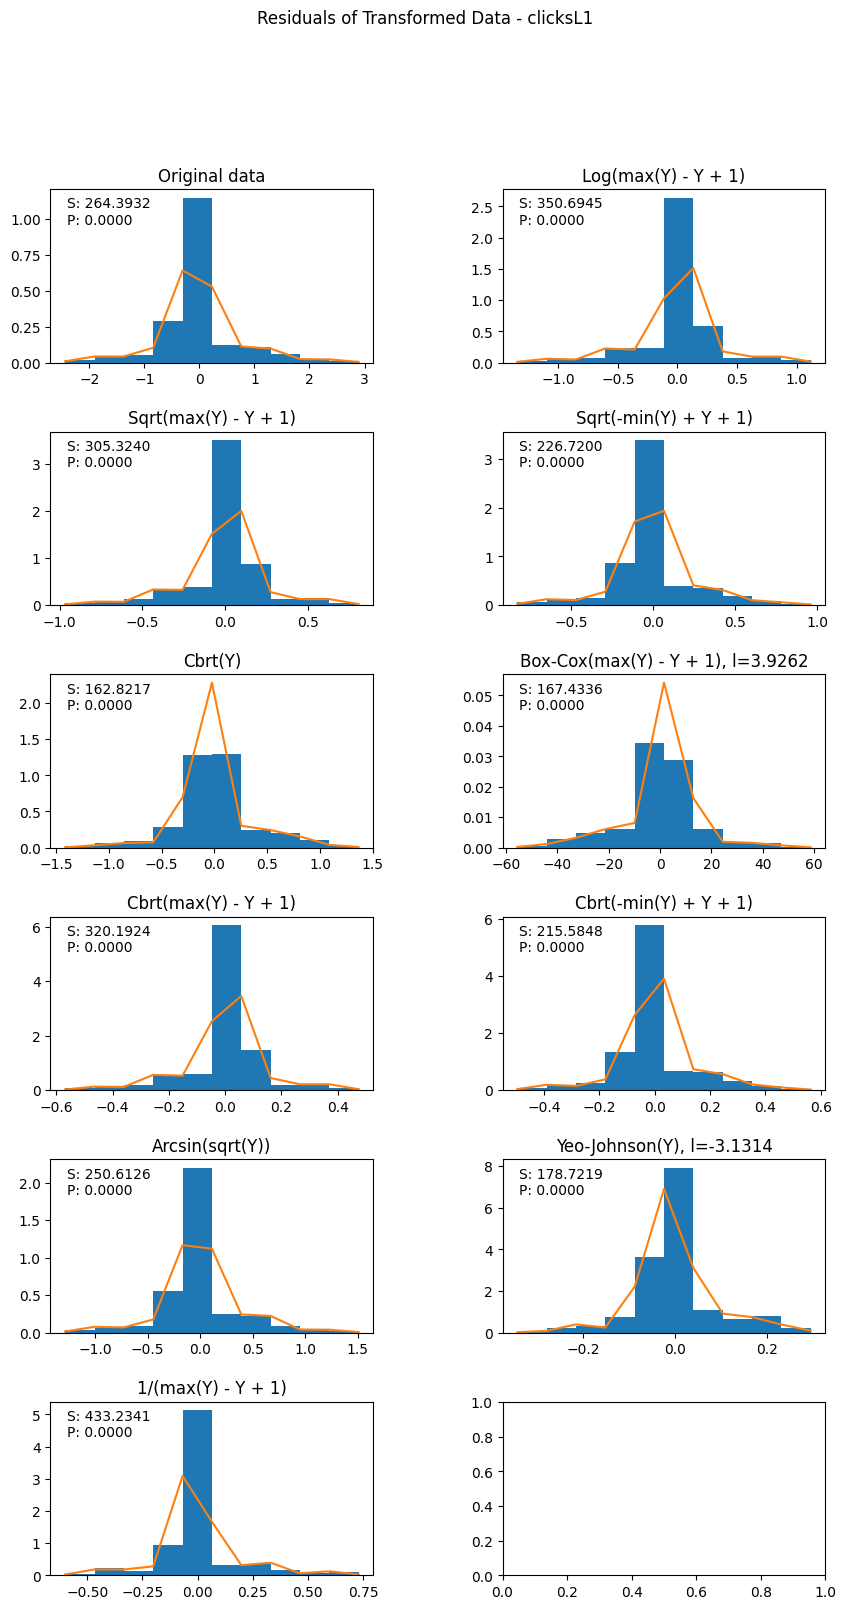

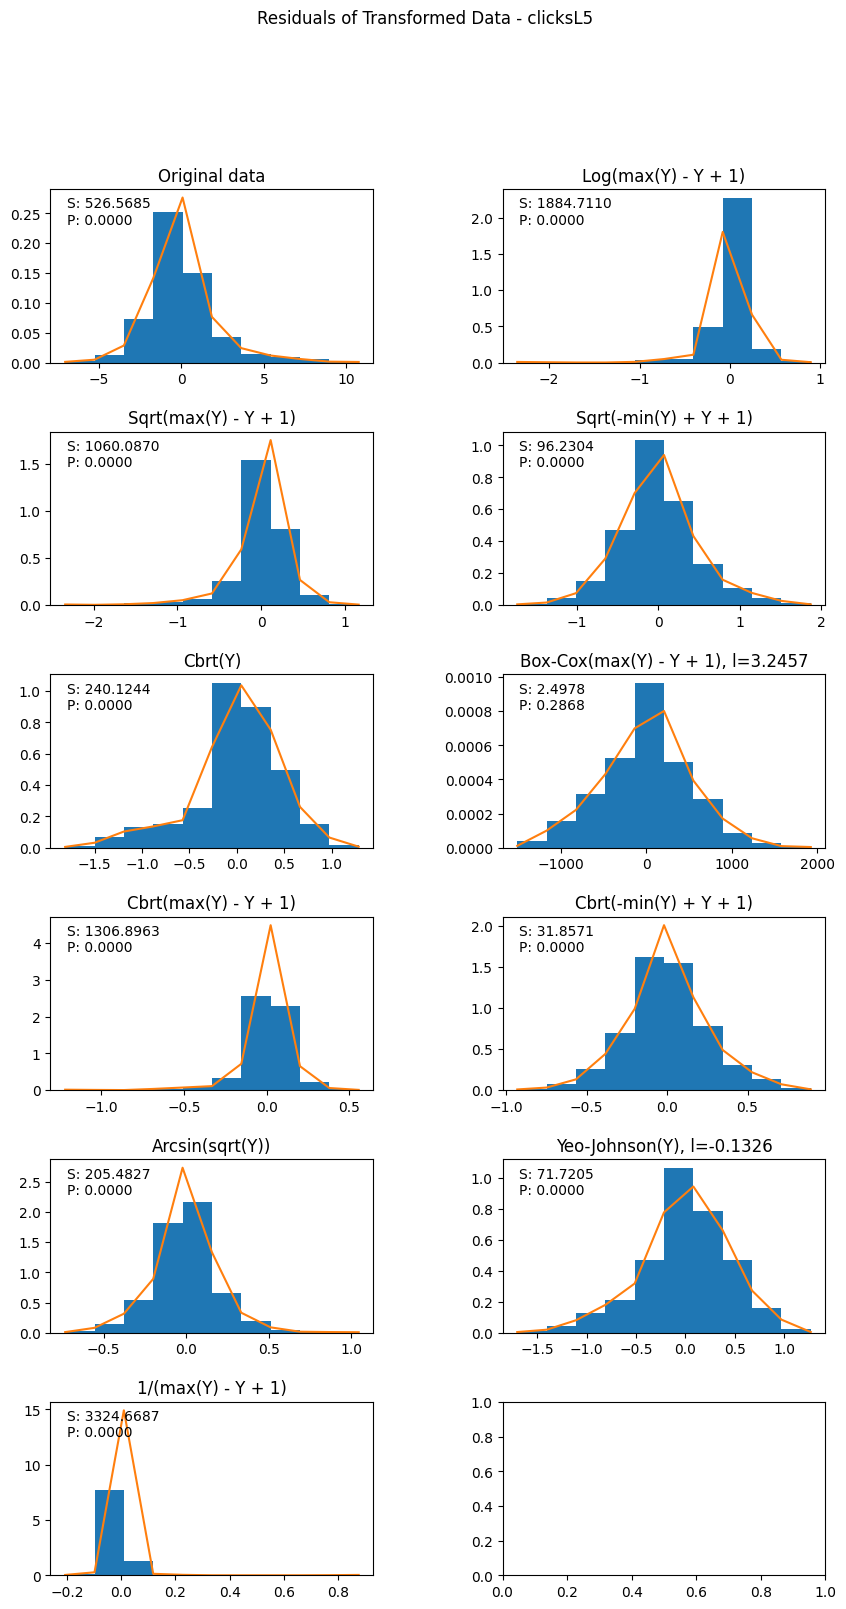

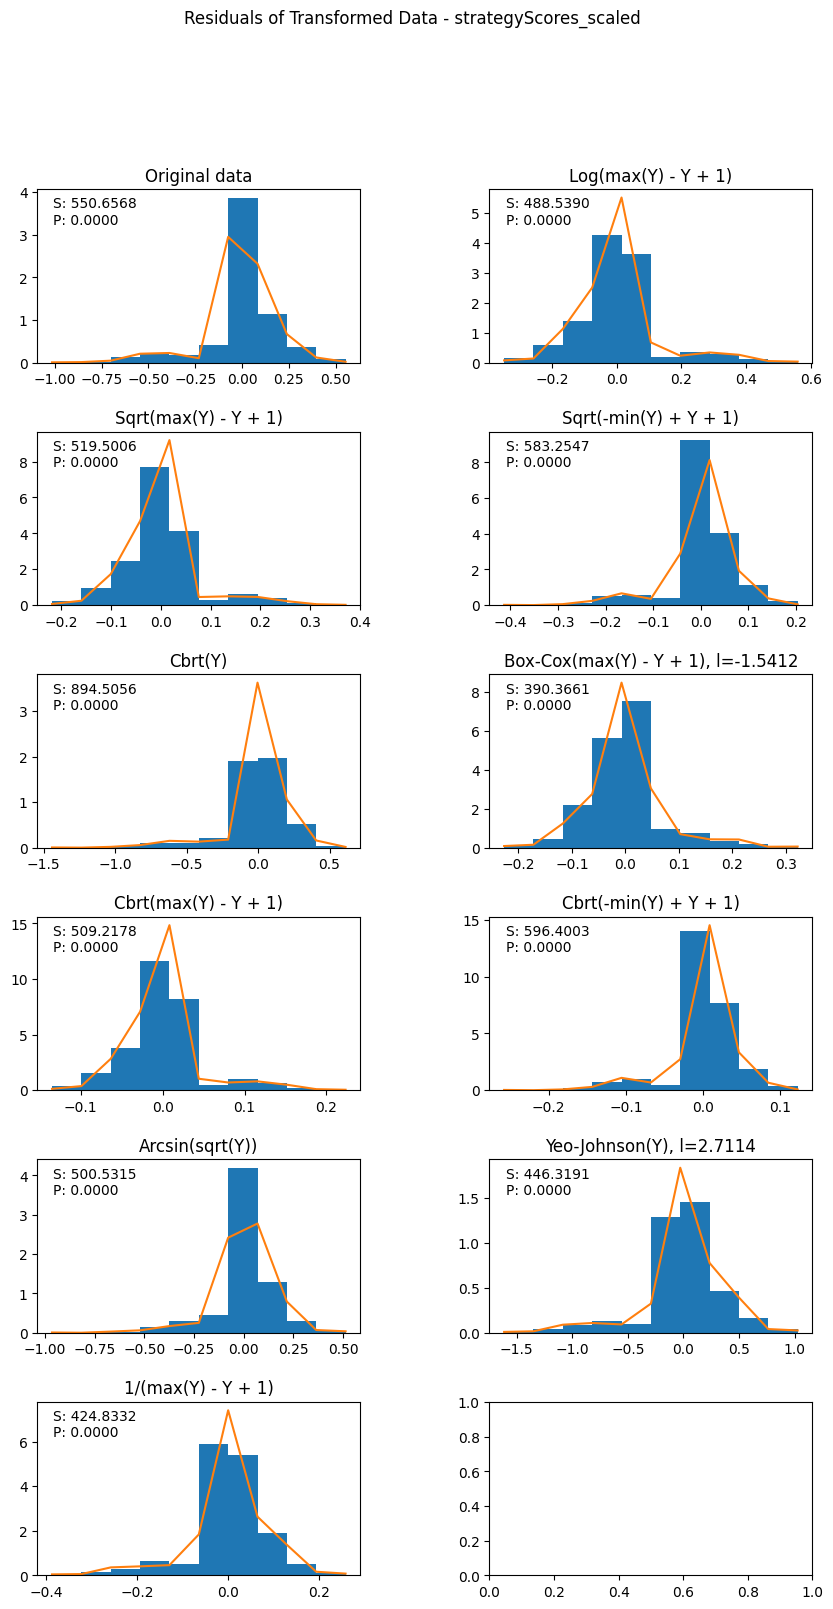

In [354]:
# Plotting residuals for all GLM Models

analysis_cols = {res: [] for res in response_vars}
highest_normality_trans = {res: "" for res in response_vars}

for response_var in response_vars:
    fig, ax = plt.subplots(nrows=math.ceil(len(all_residuals[response_var])/2),ncols=2,figsize=(10, 3 * math.ceil(len(all_residuals[response_var])/2)),squeeze=False)
    plt.suptitle("Residuals of Transformed Data - {}".format(response_var))
    ax = ax.flatten()

    lowest_normality_stat = float("inf")
    for idx, trans in enumerate(all_residuals[response_var]):
        resids = trans[0]
        response_data = trans[1]
        label = trans[2]
        normaltest = trans[3]
        if normaltest.statistic < lowest_normality_stat:
            analysis_cols[response_var] = response_data
            highest_normality_trans[response_var] = label
            lowest_normality_stat = normaltest.statistic
        density = scipy.stats.gaussian_kde(resids)
        n, x, _ = ax[idx].hist(resids, density=True)
        ax[idx].set_title(label)
        ax[idx].plot(x, density(x))
        ax[idx].text(0.05,0.8, "S: {0:0.4f}\nP: {1:0.4f}".format(normaltest.statistic, normaltest.pvalue), transform=ax[idx].transAxes)

    plt.subplots_adjust(
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

In [355]:
# data which is to be used for the remainder of the analysis

# Displaying which of the data has the most normal residuals 
analysis_data = transformed_trials_df.copy()
for response_var in response_vars:
    print("{} - {}".format(response_var, highest_normality_trans[response_var]))
    analysis_data[response_var] = analysis_cols[response_var]
    

expectedScores - Arcsin(sqrt(Y))
strategyScores - Sqrt(max(Y) - Y + 1)
expectedScores_scaled - Arcsin(sqrt(Y))
avgClickLevel - 1/(max(Y) - Y + 1)
clicksL1 - Cbrt(Y)
clicksL5 - Box-Cox(max(Y) - Y + 1), l=3.2457
strategyScores_scaled - Box-Cox(max(Y) - Y + 1), l=-1.5412


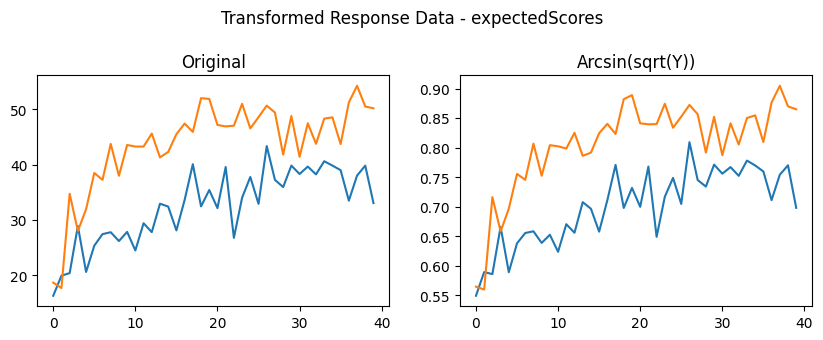

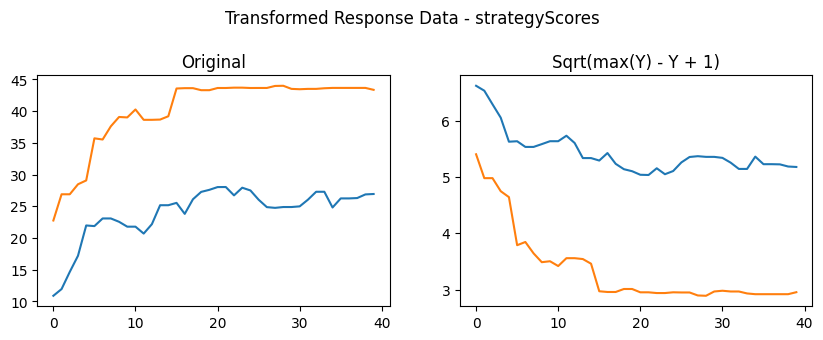

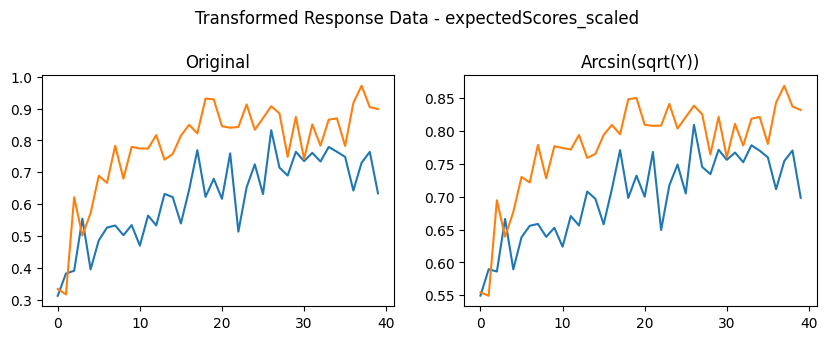

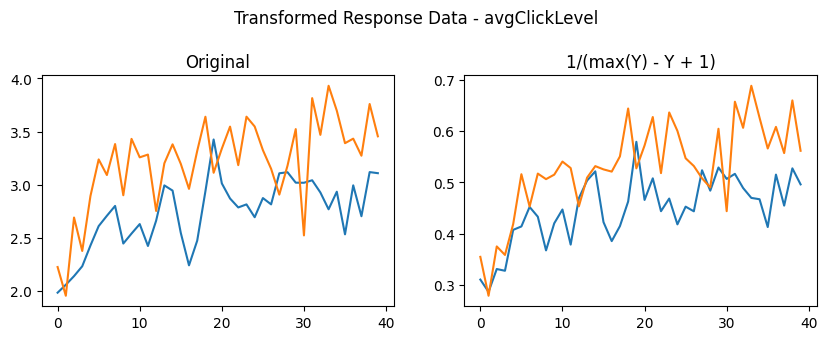

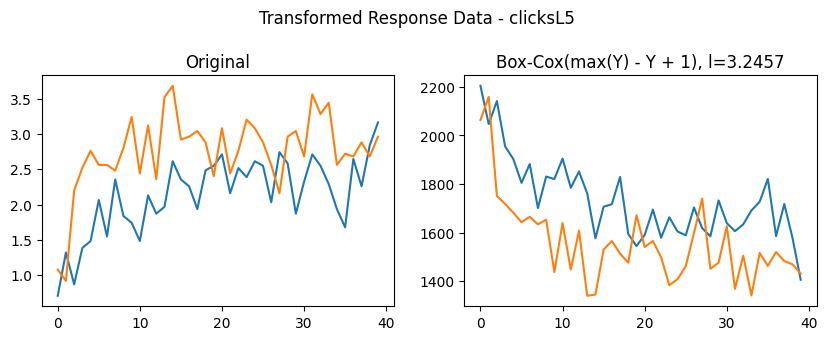

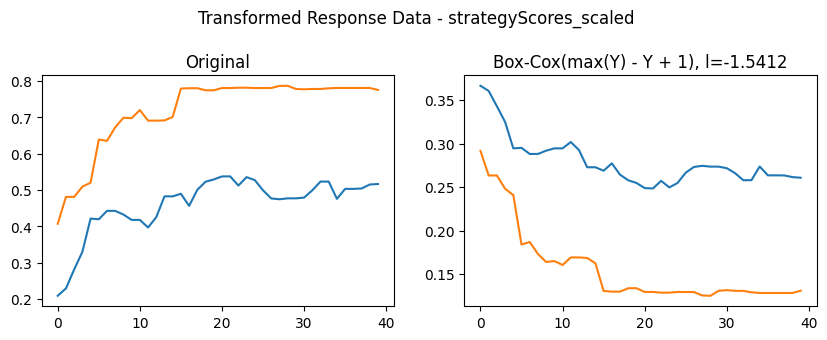

In [356]:
# Visualize transformed data for each response variable

for response_var in response_vars:
    fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10, 3),squeeze=True)
    plt.suptitle("Transformed Response Data - {}".format(response_var),y=1.1)
    ax = ax.flatten()

    for idx, trans in enumerate([transformed_trials_df, analysis_data]):
        data = trans
        scarce = data.loc[data.condition == 1]
        control = data.loc[data.condition == 0]
        label = "Original" if idx == 0 else highest_normality_trans[response_var]

        scarce_mean = np.array(scarce.groupby('trialNumbers').mean(numeric_only=True)[response_var])
        control_mean = np.array(control.groupby('trialNumbers').mean(numeric_only=True)[response_var])
        ax[idx].plot(list(range(len(scarce_mean))), scarce_mean, label="Scarce")
        ax[idx].plot(list(range(len(control_mean))), control_mean, label="Control")
        ax[idx].set_title(label)

plt.show()

# 1.1.1 - Linear Regression: Finding Best Model of Learning vs. Performance

### Finding Best Model for Scarce Condition

In [365]:


test_df = analysis_data

mixed = False
    
# For scarce trials
relevant_trials = test_df.loc[test_df.condition == 1].copy()

all_trials_mean_scarce = relevant_trials.groupby("trialNumbers").mean(numeric_only=True)["expectedScores_scaled"]
all_trial_nos_scarce = list(range(1,len(all_trials_mean_scarce)+1))

sig_bic_scores_scarce = []
scarce_plot_data = []
scarce_glm_results = []

# Check all possible data splits for both conditions
for trialNum in range(2,40,1):
    isPerformanceTrial = [int(trial > trialNum) for trial in relevant_trials.trialNumbers]
    relevant_trials['isPerformanceTrial'] = isPerformanceTrial
    
    partition_1_df = relevant_trials.loc[relevant_trials.isPerformanceTrial == 0]
    partition_2_df = relevant_trials.loc[relevant_trials.isPerformanceTrial == 1]
    partition_1_mean_scores = partition_1_df.groupby("trialNumbers").mean(numeric_only=True)["expectedScores_scaled"]
    partition_2_mean_scores = partition_2_df.groupby("trialNumbers").mean(numeric_only=True)["expectedScores_scaled"]
    
    two_slope_formula = "expectedScores_scaled ~ trialNumbers + trialNumbers:C(isPerformanceTrial) + C(isPerformanceTrial)"
    one_slope_formula = "expectedScores_scaled ~ trialNumbers"
    
    # Fitting a single-slope model and a two-slope model to see which is better
    if mixed:
        glm_1 = smf.mixedlm(formula=two_slope_formula, data=relevant_trials, groups=relevant_trials['workerId'])
        glm_2 = smf.mixedlm(formula=one_slope_formula, data=relevant_trials, groups=relevant_trials['workerId'])
    else:
        glm_1 = smf.glm(formula=two_slope_formula, data=relevant_trials)
        glm_2 = smf.glm(formula=one_slope_formula, data=relevant_trials)

    try:
        results_1 = glm_1.fit()
        results_2 = glm_2.fit()
    except:
        continue
        
    bic1 = results_1.bic_llf
    bic2 = results_2.bic_llf
        
    # Saving the slopes and the single intercept of both phases from the two-slope model
    b1 = results_1.params['trialNumbers']
    b2 = results_1.params['trialNumbers'] + results_1.params['trialNumbers:C(isPerformanceTrial)[T.1]']
    i1 = results_1.params['Intercept']
    i2 = results_1.params['Intercept'] + results_1.params['C(isPerformanceTrial)[T.1]']
    
    b3 = results_2.params['trialNumbers']
    i3 = results_2.params['Intercept']
    
    if(bic1 < bic2):
        # Save data about significant partitions, where the bic of the two-slope model is higher than one-slope
        sig_bic_scores_scarce.append((trialNum, bic1))
        
    x1 = all_trial_nos_scarce[0:len(partition_1_mean_scores)]
    x2 = all_trial_nos_scarce[len(partition_1_mean_scores):len(partition_1_mean_scores)+len(partition_2_mean_scores)]
    scarce_plot_data.append((
        trialNum,
        x1,
        x2,
        partition_1_mean_scores,
        partition_2_mean_scores,
        b1,
        b2,
        i1,
        i2,
        b3,
        i3,
        partition_1_df,
        partition_2_df
    ))
    scarce_glm_results.append((trialNum, results_1, results_2))

In [367]:
# Finding the best partition of all significant ones 

mis_partition_exists = len(sig_bic_scores_scarce) > 0

if use_model_data:
    partition_candidates = [13] # Use partition from human dataset
elif mis_partition_exists:
    sig_bic_scores_scarce = np.array(sig_bic_scores_scarce)

    g_range = np.arange(0, 1, 0.0001)
    best_partitions = []

    for gamma in g_range:
        # Minimum bic
        partition_scores = sig_bic_scores_scarce[:,1]
        best_partition = sig_bic_scores_scarce[np.argmin(partition_scores),0]
        best_partitions.append(best_partition)

    partition_candidates = np.unique(best_partitions)



    print("Partition candidates: ")
    print(partition_candidates)
    plt.plot(g_range, best_partitions)
    plt.xlabel("Gamma (Decay Factor)")
    plt.ylabel("Best Partition")
    plt.show()


In [368]:
# Showing GLM results - scarce

if mis_partition_exists:
    candidate_glm_results_scarce = [data for data in scarce_glm_results if float(data[0]) in partition_candidates]

    for trialNum, results_1, results_2 in candidate_glm_results_scarce:
        print("Trial Num: {}".format(trialNum))
        print("\nTwo-Slope Model:\nBIC LLF: {0:0.4f}\n\nBIC Deviance: {1:0.4f}\n\nAIC: {2:0.4f}\n"
              .format(results_1.bic_llf,results_1.bic_deviance, results_1.aic))
        print(results_1.summary())

        print("\nOne-Slope Model:\nBIC LLF: {0:0.4f}\n\nBIC Deviance: {1:0.4f}\n\nAIC: {2:0.4f}\n"
              .format(results_2.bic_llf,results_2.bic_deviance, results_2.aic))
        print(results_2.summary())


In [369]:
# Plotting candidate partitions - scarce
if mis_partition_exists:
    candidate_plot_data_scarce = [data for data in scarce_plot_data if float(data[0]) in partition_candidates]
    #significant_plot_data_scarce = [data for data in scarce_plot_data if float(data[0]) in sig_bic_scores_scarce[:,0]]

    which_plot = "candidates" #all, significant, candidates

    if which_plot == "candidates":
        plot_data = candidate_plot_data_scarce
    elif which_plot == "significant":
        plot_data = significant_plot_data_scarce
    else:
        plot_data = scarce_plot_data

    plot_single_slope = False
    plot_two_slope = True
    scatter = False
    error = False

    for trialNum, x1, x2, y1, y2, b1, b2, i1, i2,b3, i3, df_1, df_2 in plot_data:
        plt.figure()
        # Expected Score curves
        plt.plot(all_trial_nos_scarce, all_trials_mean_scarce, alpha=0.2, color='k')
        plt.plot(x1, y1, alpha=0.5)
        plt.plot(x2, y2, alpha=0.5)

        # Scatter points
        if scatter:
            plt.scatter(df_1['trialNumbers'], df_1['expectedScores'], color='b', marker='o', alpha=0.1,s=0.8)
            plt.scatter(df_2['trialNumbers'], df_2['expectedScores'], color='orange', marker='o', alpha=0.1,s=0.8)

        # Partition line
        plt.axvline(trialNum, linestyle="--", color='k',alpha=0.5)

        # Slope lines of one-slope model
        if plot_single_slope:
            x3 = np.concatenate([x1,x2],axis=0)
            plt.plot(x3, np.array(x3) * b3 + i3, color='g', alpha=0.5)

        if plot_two_slope:
            # Slope lines of two-slope model
            plt.plot(x1, np.array(x1) * b1 + i1, color='b')
            plt.plot(x2, np.array(x2) * b2 + i2, color='orange')

        if error:
            plt.fill_between(x1, scarce_data_all + scarce_data_all_sd, scarce_data_all - scarce_data_all_sd, alpha=0.1)

        plt.title("Trial: {}".format(trialNum))

    plt.show()

In [370]:
if mis_partition_exists:
    scarce_partition = partition_candidates[0] # Somehow choose based on possible candidates

    # Separating into learning and performance phase
    scarce_learning_data = analysis_data.loc[(analysis_data.scarce == 1) & (analysis_data.trialNumbers <= scarce_partition)]
    scarce_performance_data = analysis_data.loc[(analysis_data.scarce ==1) & (analysis_data.trialNumbers > scarce_partition)]

    # Without transformation
    scarce_learning_data_orig = filtered_data.loc[(filtered_data.scarce == 1) & (filtered_data.trialNumbers <= scarce_partition)]
    scarce_performance_data_orig = filtered_data.loc[(filtered_data.scarce ==1) & (filtered_data.trialNumbers > scarce_partition)]

    # Store the slope, intercept, etc. of the best partition
    scarce_partition_plot_data = [data for data in candidate_plot_data_scarce if data[0] == scarce_partition][0]

### Finding Best Model for Control Condition

In [377]:
# GLM 3 - finding cut off point of learning phase

test_df = analysis_data

mixed = False
    
# For control trials
relevant_trials = test_df.loc[test_df.condition == 0].copy()

all_trials_mean_control = relevant_trials.groupby("trialNumbers").mean(numeric_only=True)["expectedScores_scaled"]
all_trial_nos_control = list(range(1,len(all_trials_mean_control)+1))

sig_bic_scores_control = []
control_plot_data = []
control_glm_results = []
for trialNum in range(2,40,1):
    isPerformanceTrial = [int(trial > trialNum) for trial in relevant_trials.trialNumbers]
    relevant_trials['isPerformanceTrial'] = isPerformanceTrial
    
    partition_1_df = relevant_trials.loc[relevant_trials.isPerformanceTrial == 0]
    partition_2_df = relevant_trials.loc[relevant_trials.isPerformanceTrial == 1]
    partition_1_mean_scores = partition_1_df.groupby("trialNumbers").mean(numeric_only=True)["expectedScores_scaled"]
    partition_2_mean_scores = partition_2_df.groupby("trialNumbers").mean(numeric_only=True)["expectedScores_scaled"]
    
#     two_slope_formula = "expectedScores ~ trialNumbers + C(condition) + C(isPerformanceTrial) + trialNumbers:C(isPerformanceTrial)"
#     one_slope_formula = "expectedScores ~ trialNumbers + C(condition)"
    two_slope_formula = "expectedScores_scaled ~ trialNumbers + trialNumbers:C(isPerformanceTrial) + C(isPerformanceTrial)"
    one_slope_formula = "expectedScores_scaled ~ trialNumbers"
    
    # Fitting a single-slope model and a two-slope model to see which is better
    if mixed:
        glm_1 = smf.mixedlm(formula=two_slope_formula, data=relevant_trials, groups=relevant_trials['workerId'])
        glm_2 = smf.mixedlm(formula=one_slope_formula, data=relevant_trials, groups=relevant_trials['workerId'])
    else:
        glm_1 = smf.glm(formula=two_slope_formula, data=relevant_trials)
        glm_2 = smf.glm(formula=one_slope_formula, data=relevant_trials)

    try:
        results_1 = glm_1.fit()
        results_2 = glm_2.fit()
    except:
        continue
        
    bic1 = results_1.bic_llf
    bic2 = results_2.bic_llf
    
    # print(results_1.summary())
    
    # Saving the slopes and the single intercept of both phases from the two-slope model
    b1 = results_1.params['trialNumbers']
    b2 = results_1.params['trialNumbers'] + results_1.params['trialNumbers:C(isPerformanceTrial)[T.1]']
    i1 = results_1.params['Intercept']
    i2 = results_1.params['Intercept'] + results_1.params['C(isPerformanceTrial)[T.1]']
    
    b3 = results_2.params['trialNumbers']
    i3 = results_2.params['Intercept']
    if(bic1 < bic2):
        # Save data about significant partitions, where the bic of the two-slope model is higher than one-slope
        sig_bic_scores_control.append((trialNum, bic1))
        
    x1 = all_trial_nos_control[0:len(partition_1_mean_scores)]
    x2 = all_trial_nos_control[len(partition_1_mean_scores):len(partition_1_mean_scores)+len(partition_2_mean_scores)]
    control_plot_data.append((
        trialNum,
        x1,
        x2,
        partition_1_mean_scores,
        partition_2_mean_scores,
        b1,
        b2,
        i1,
        i2,
        b3, 
        i3,
        partition_1_df,
        partition_2_df
    ))
    control_glm_results.append((trialNum, results_1, results_2))

In [378]:
sig_bic_scores_control

[(2, 74.60534160299144),
 (3, 75.57494194618003),
 (4, 72.44856646182048),
 (5, 70.1040536977048),
 (6, 69.64431123503999),
 (7, 68.99763300460096),
 (8, 69.00085741287506),
 (9, 69.43992672625595),
 (10, 69.57899788116464),
 (11, 70.01868379867886),
 (12, 70.6875957331155),
 (13, 71.07307657373218),
 (14, 72.34439672638999),
 (15, 73.15523763071006),
 (16, 73.50550996184803),
 (17, 73.76149533365592),
 (18, 74.3945011578903),
 (19, 73.95017632369415),
 (20, 73.27484272265028),
 (21, 74.52188562398456),
 (22, 75.88923368427898),
 (23, 77.24749543872875),
 (24, 76.92660421778702),
 (25, 78.7427221620753),
 (26, 79.48905049966845),
 (27, 78.9584801540727),
 (28, 79.04288458356874)]

Partition candidates: 
[7.]


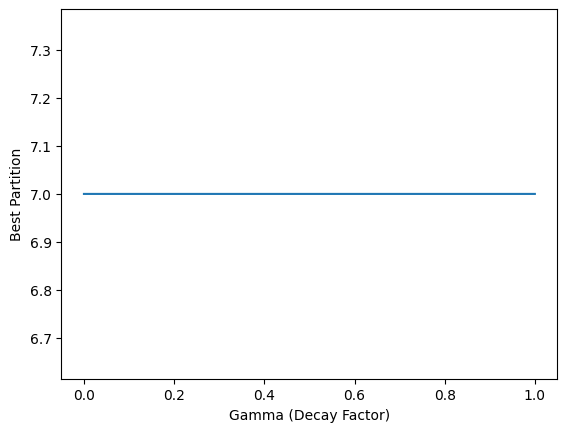

In [379]:
# Finding the best partition of all significant ones 

if use_model_data:
    partition_candidates = [9] # Use partition from human data
else:
    sig_bic_scores_control = np.array(sig_bic_scores_control)

    g_range = np.arange(0, 1, 0.0001)
    best_partitions = []

    for gamma in g_range:
        # Minimum bic
        partition_scores = sig_bic_scores_control[:,1]
        best_partition = sig_bic_scores_control[np.argmin(partition_scores),0]
        best_partitions.append(best_partition)

    partition_candidates = np.unique(best_partitions)
    print("Partition candidates: ")
    print(partition_candidates)
    plt.plot(g_range, best_partitions)
    plt.xlabel("Gamma (Decay Factor)")
    plt.ylabel("Best Partition")
    plt.show()


In [380]:
# Showing GLM results - control
candidate_glm_results_control = [data for data in control_glm_results if float(data[0]) in partition_candidates]

for trialNum, results_1, results_2 in candidate_glm_results_control:
    print("Trial Num: {}".format(trialNum))
    print("\nTwo-Slope Model:\nBIC LLF: {0:0.4f}\n\nBIC Deviance: {1:0.4f}\n\nAIC: {2:0.4f}\n"
          .format(results_1.bic_llf,results_1.bic_deviance, results_1.aic))
    print(results_1.summary())
    
    print("\nOne-Slope Model:\nBIC LLF: {0:0.4f}\n\nBIC Deviance: {1:0.4f}\n\nAIC: {2:0.4f}\n"
          .format(results_2.bic_llf,results_2.bic_deviance, results_2.aic))
    print(results_2.summary())


Trial Num: 7

Two-Slope Model:
BIC LLF: 68.9976

BIC Deviance: -6819.1016

AIC: 49.3666

                   Generalized Linear Model Regression Results                   
Dep. Variable:     expectedScores_scaled   No. Observations:                 1000
Model:                               GLM   Df Residuals:                      996
Model Family:                   Gaussian   Df Model:                            3
Link Function:                  identity   Scale:                        0.061268
Method:                             IRLS   Log-Likelihood:                -20.683
Date:                   Fri, 28 Jul 2023   Deviance:                       61.023
Time:                           15:28:26   Pearson chi2:                     61.0
No. Iterations:                        3   Pseudo R-squ. (CS):            0.06639
Covariance Type:               nonrobust                                         
                                              coef    std err          z      P>|z|      [0

In [381]:
# Plotting candidate partitions - control
candidate_plot_data_control = [data for data in control_plot_data if float(data[0]) in partition_candidates]
#significant_plot_data_control = [data for data in control_plot_data if float(data[0]) in sig_bic_scores_control[:,0]]

which_plot = "candidates" #all, significant, candidates

if which_plot == "candidates":
    plot_data = candidate_plot_data_control
elif which_plot == "significant":
    plot_data = significant_plot_data_control
else:
    plot_data = control_plot_data
    
plot_single_slope = False
plot_two_slope = True
scatter = False

for trialNum, x1, x2, y1, y2, b1, b2, i1, i2,b3, i3, df_1, df_2 in plot_data:
    plt.figure()
    # Expected Score curves
    plt.plot(all_trial_nos_control, all_trials_mean_control, alpha=0.2, color='k')
    plt.plot(x1, y1, alpha=0.5)
    plt.plot(x2, y2, alpha=0.5)

    # Partition line
    plt.axvline(trialNum, linestyle="--", color='k',alpha=0.5)
    
    # Scatter points
    if scatter:
        plt.scatter(df_1['trialNumbers'], df_1['expectedScores'], color='b', marker='o', alpha=0.1,s=0.8)
        plt.scatter(df_2['trialNumbers'], df_2['expectedScores'], color='orange', marker='o', alpha=0.1,s=0.8)

    # Slope lines of one-slope model
    if plot_single_slope:
        x3 = np.concatenate([x1,x2],axis=0)
        plt.plot(x3, np.array(x3) * b3 + i3, color='g', alpha=0.5)
    
    if plot_two_slope:
        # Slope lines of two-slope model
        plt.plot(x1, np.array(x1) * b1 + i1, color='b')
        plt.plot(x2, np.array(x2) * b2 + i2, color='orange')
    
    plt.title("Trial: {}".format(trialNum))
    
plt.show()

In [384]:
control_partition = partition_candidates[0] # Somehow choose based on possible candidates

# Separating into learning and performance phase
control_learning_data = analysis_data.loc[(analysis_data.condition == 0) & (analysis_data.trialNumbers <= control_partition)]
control_performance_data = analysis_data.loc[(analysis_data.condition == 0) & (analysis_data.trialNumbers > control_partition)]

# Without transformation
control_learning_data_orig = filtered_data.loc[(filtered_data.condition == 0) & (filtered_data.trialNumbers <= control_partition)]
control_performance_data_orig = filtered_data.loc[(filtered_data.condition == 0) & (filtered_data.trialNumbers > control_partition)]

# Store the slope, intercept, etc. of the best partition
control_partition_plot_data = [data for data in candidate_plot_data_control if data[0] == control_partition][0]

if not mis_partition_exists:
    scarce_partition = control_partition # Somehow choose based on possible candidates

    # Separating into learning and performance phase
    scarce_learning_data = analysis_data.loc[(analysis_data.condition == 1) & (analysis_data.trialNumbers <= scarce_partition)]
    scarce_performance_data = analysis_data.loc[(analysis_data.condition ==1) & (analysis_data.trialNumbers > scarce_partition)]

    # Without transformation
    scarce_learning_data_orig = filtered_data.loc[(filtered_data.condition == 1) & (filtered_data.trialNumbers <= scarce_partition)]
    scarce_performance_data_orig = filtered_data.loc[(filtered_data.condition ==1) & (filtered_data.trialNumbers > scarce_partition)]

    # Store the slope, intercept, etc. of the best partition
    scarce_partition_plot_data = [data for data in scarce_plot_data if data[0] == scarce_partition][0]

# 1.1 - Linear Regression: Expected Score vs. Trial Number x Condition

In [385]:
# Select the response variable for this analysis

response_var = "expectedScores_scaled"
assert (response_var in response_vars), "{} is not a valid response variable".format(response_var)

In [387]:
# Learning Phase

use_orig = True

if use_orig:
    learning_df = pd.concat([scarce_learning_data_orig, control_learning_data_orig]).reset_index(drop=True)
else: 
    learning_df = pd.concat([scarce_learning_data, control_learning_data]).reset_index(drop=True)

formula = '{} ~ trialNumbers + C(condition) + trialNumbers:C(condition)'.format(response_var)

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=learning_df, groups=learning_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=learning_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

                  Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   expectedScores_scaled
No. Observations:   392       Method:               REML                 
No. Groups:         56        Scale:                0.1683               
Min. group size:    7         Log-Likelihood:       -268.3589            
Max. group size:    7         Converged:            Yes                  
Mean group size:    7.0                                                  
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       0.287    0.102  2.822 0.005  0.088  0.486
C(condition)[T.1]               0.027    0.137  0.195 0.845 -0.241  0.294
trialNumbers                    0.060    0.016  3.899 0.000  0.030  0.091
trialNumbers:C(condition)[T.1] -0.030    0.021 -1.438 0.

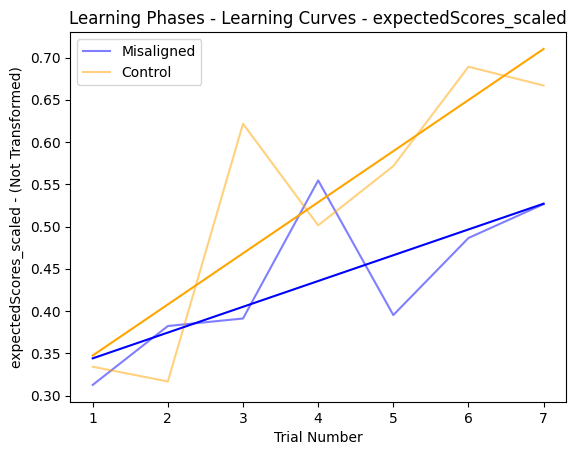

In [390]:
# Plotting the data of both learning phases

x1 = control_partition_plot_data[1]
x2 = scarce_partition_plot_data[1]
y1 = learning_df[learning_df.condition==0].groupby("trialNumbers").mean(numeric_only=True)[response_var]
y2 = learning_df[learning_df.condition==1].groupby("trialNumbers").mean(numeric_only=True)[response_var]
b1 = results.params['trialNumbers']
b2 = results.params['trialNumbers'] + results.params['trialNumbers:C(condition)[T.1]']
i1 = results.params['Intercept']
i2 = results.params['Intercept'] + results.params['C(condition)[T.1]']

plt.plot(x2, y2, color='b', alpha=0.5, label="Misaligned")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Learning Phases - Learning Curves - {}".format(response_var))
plt.xlabel("Trial Number")
plt.ylabel("{} - {}".format(response_var, "(Not Transformed)" if use_orig else "(Transformed)"))
plt.legend()


plt.show()



                  Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   expectedScores_scaled
No. Observations:   1848      Method:               REML                 
No. Groups:         56        Scale:                0.1553               
Min. group size:    33        Log-Likelihood:       -1011.0619           
Max. group size:    33        Converged:            Yes                  
Mean group size:    33.0                                                 
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       0.749    0.085  8.835 0.000  0.583  0.915
C(condition)[T.1]              -0.257    0.114 -2.256 0.024 -0.480 -0.034
trialNumbers                    0.004    0.001  2.528 0.011  0.001  0.006
trialNumbers:C(condition)[T.1]  0.003    0.002  1.778 0.

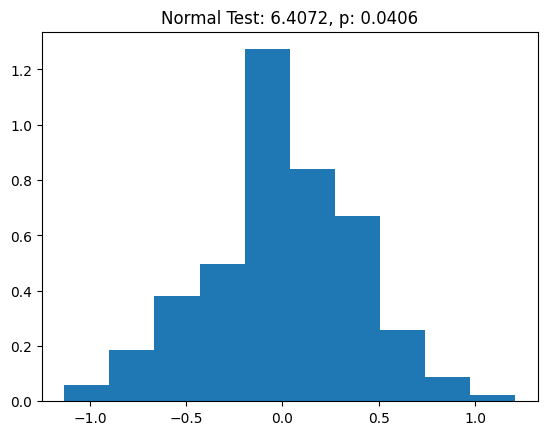

In [392]:
# Performance Phase

use_orig = True

if use_orig:
    performance_df = pd.concat([scarce_performance_data_orig, control_performance_data_orig]).reset_index(drop=True)
else: 
    performance_df = pd.concat([scarce_performance_data, control_performance_data]).reset_index(drop=True)
    
formula = '{} ~ trialNumbers + C(condition) + trialNumbers:C(condition)'.format(response_var)

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=performance_df, groups=performance_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=performance_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

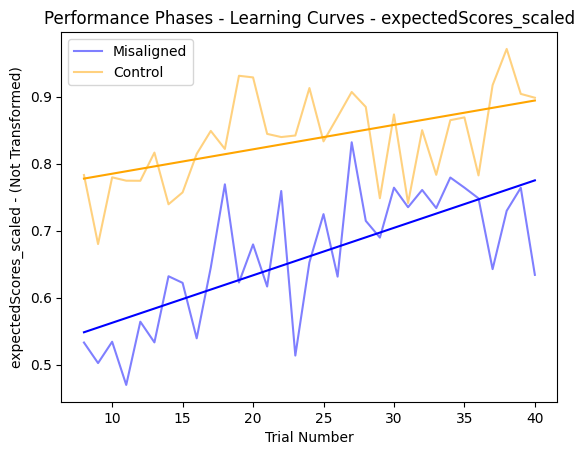

In [395]:
# Plotting the data of both performance phases together

x1 = control_partition_plot_data[2]
x2 = scarce_partition_plot_data[2]
y1 = performance_df[performance_df.condition==0].groupby("trialNumbers").mean(numeric_only=True)[response_var]
y2 = performance_df[performance_df.condition==1].groupby("trialNumbers").mean(numeric_only=True)[response_var]
b1 = results.params['trialNumbers']
b2 = results.params['trialNumbers'] + results.params['trialNumbers:C(condition)[T.1]']
i1 = results.params['Intercept']
i2 = results.params['Intercept'] + results.params['C(condition)[T.1]']
        

plt.plot(x2, y2, color='b', alpha=0.5, label="Misaligned")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Performance Phases - Learning Curves - {}".format(response_var))
plt.xlabel("Trial Number")
plt.ylabel("{} - {}".format(response_var, "(Not Transformed)" if use_orig else "(Transformed)"))
plt.legend()

plt.show()

# 1.2 - Independent Samples T-test

In [397]:
# Select the response variable for this analysis

response_var = "expectedScores_scaled"
assert (response_var in response_vars), "{} is not a valid response variable".format(response_var)

In [400]:
use_transformed = False

if use_transformed:
    # Using the transformed data divided into phases
    control_averages = control_performance_data.groupby('workerId').mean(numeric_only=True)
    scarce_averages = scarce_performance_data.groupby('workerId').mean(numeric_only=True)
else:
    # Using the original data divided into phases
    control_averages = control_performance_data_orig.groupby('workerId').mean(numeric_only=True)
    scarce_averages = scarce_performance_data_orig.groupby('workerId').mean(numeric_only=True)
    

In [402]:
plt.figure()
plt.plot(np.sort(np.unique(control_performance_data.trialNumbers)), control_performance_data.groupby('trialNumbers').mean(numeric_only=True)[response_var], color='orange')
plt.plot(np.sort(np.unique(scarce_performance_data.trialNumbers)), scarce_performance_data.groupby('trialNumbers').mean(numeric_only=True)[response_var], color='b')
plt.show()

0.836062178413225 0.34844766823598766
0.661777581299464 0.4149387661073851


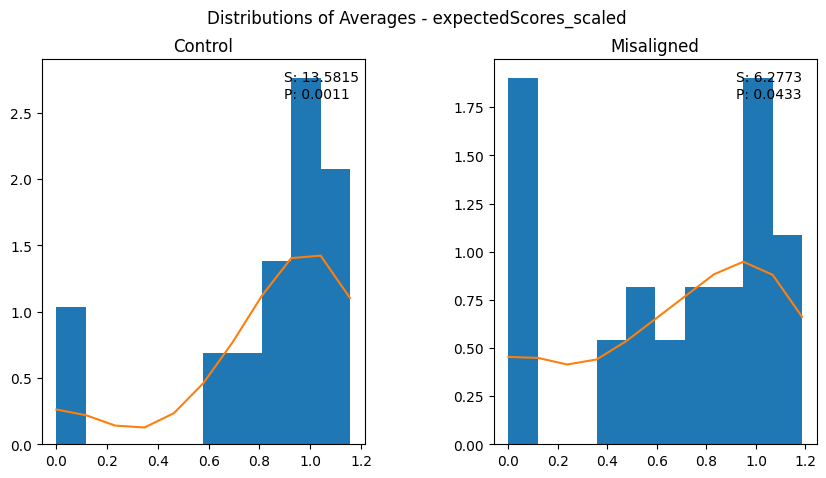

In [403]:

# Plotting normality for both groups

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10, 5),squeeze=False)
plt.suptitle("Distributions of Averages - {}".format(response_var))
ax = ax.flatten()

for idx, group in enumerate([(control_averages, "Control"), (scarce_averages, "Misaligned")]):
    data = group[0][response_var]
    label = group[1]
    print(data.mean(), data.std())
    normaltest = scipy.stats.normaltest(data)
    density = scipy.stats.gaussian_kde(data)
    n, x, _ = ax[idx].hist(data, density=True)
    ax[idx].set_title(label)
    ax[idx].plot(x, density(x))
    ax[idx].text(0.75,0.9, "S: {0:0.4f}\nP: {1:0.4f}".format(normaltest.statistic, normaltest.pvalue), transform=ax[idx].transAxes)

plt.subplots_adjust(
                wspace=0.4, 
                hspace=0.4)
plt.show()

In [404]:
# Perform independent T-test if data is normal


two = scipy.stats.ttest_ind(scarce_averages[response_var], control_averages[response_var], equal_var=True, alternative='two-sided')
less = scipy.stats.ttest_ind(scarce_averages[response_var], control_averages[response_var], equal_var=True, alternative='less')
greater = scipy.stats.ttest_ind(scarce_averages[response_var], control_averages[response_var], equal_var=True, alternative='greater')

print("Response Variable: {}".format(response_var))
print("Two-Sided:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(two.statistic, two.pvalue))
print("Scarce < Control:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(less.statistic, less.pvalue))
print("Scarce > Control:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(greater.statistic, greater.pvalue))

Response Variable: expectedScores_scaled
Two-Sided:
	Statistic: -1.676
	P-value: 0.09947817828656223
Scarce < Control:
	Statistic: -1.676
	P-value: 0.049739089143281116
Scarce > Control:
	Statistic: -1.676
	P-value: 0.9502609108567188


In [405]:
# Perform Mann-Whitney U test if data is not normal

two = scipy.stats.mannwhitneyu(scarce_averages[response_var], control_averages[response_var], alternative='two-sided')
less = scipy.stats.mannwhitneyu(scarce_averages[response_var], control_averages[response_var], alternative='less')
greater = scipy.stats.mannwhitneyu(scarce_averages[response_var], control_averages[response_var], alternative='greater')

print("Two-Sided:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(two.statistic, two.pvalue))
print("Scarce < Control:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(less.statistic, less.pvalue))
print("Scarce > Control:")
print("\tStatistic: {0:0.3f}\n\tP-value: {1}".format(greater.statistic, greater.pvalue))

Two-Sided:
	Statistic: 296.000
	P-value: 0.13359051302903008
Scarce < Control:
	Statistic: 296.000
	P-value: 0.06679525651451504
Scarce > Control:
	Statistic: 296.000
	P-value: 0.9353132118562986


# 2.1 - Linear Regression: AvgClickDepth vs. Trial Number x Condition

In [409]:
# Select the response variable for this analysis

response_var = "avgClickLevel"
assert (response_var in response_vars), "{} is not a valid response variable".format(response_var)

                  Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     avgClickLevel
No. Observations:       392         Method:                 REML         
No. Groups:             56          Scale:                  1.2771       
Min. group size:        7           Log-Likelihood:         -668.4828    
Max. group size:        7           Converged:              Yes          
Mean group size:        7.0                                              
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       1.872    0.305  6.139 0.000  1.274  2.470
C(condition)[T.1]              -0.072    0.410 -0.176 0.860 -0.876  0.731
trialNumbers                    0.192    0.043  4.485 0.000  0.108  0.275
trialNumbers:C(condition)[T.1] -0.064    0.057 -1.122 0.

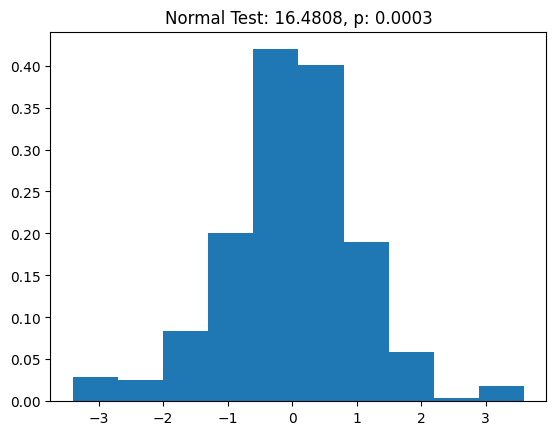

In [410]:
# Learning Phase

use_orig = True

if use_orig:
    learning_df = pd.concat([scarce_learning_data_orig, control_learning_data_orig]).reset_index(drop=True)
else: 
    learning_df = pd.concat([scarce_learning_data, control_learning_data]).reset_index(drop=True)

formula = '{} ~ trialNumbers + C(condition) + trialNumbers:C(condition)'.format(response_var)

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=learning_df, groups=learning_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=learning_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

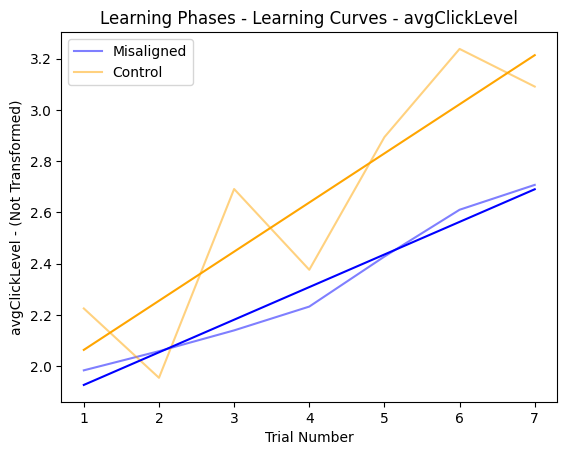

In [411]:
# Plotting the data of both learning phases

x1 = control_partition_plot_data[1]
x2 = scarce_partition_plot_data[1]
y1 = learning_df[learning_df.condition==0].groupby("trialNumbers").mean(numeric_only=True)[response_var]
y2 = learning_df[learning_df.condition==1].groupby("trialNumbers").mean(numeric_only=True)[response_var]
b1 = results.params['trialNumbers']
b2 = results.params['trialNumbers'] + results.params['trialNumbers:C(condition)[T.1]']
i1 = results.params['Intercept']
i2 = results.params['Intercept'] + results.params['C(condition)[T.1]']

plt.plot(x2, y2, color='b', alpha=0.5, label="Misaligned")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Learning Phases - Learning Curves - {}".format(response_var))
plt.xlabel("Trial Number")
plt.ylabel("{} - {}".format(response_var, "(Not Transformed)" if use_orig else "(Transformed)"))
plt.legend()


plt.show()



                  Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     avgClickLevel
No. Observations:       1848        Method:                 REML         
No. Groups:             56          Scale:                  1.4810       
Min. group size:        33          Log-Likelihood:         -3097.9930   
Max. group size:        33          Converged:              Yes          
Mean group size:        33.0                                             
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       3.064    0.296 10.341 0.000  2.483  3.644
C(condition)[T.1]              -0.521    0.398 -1.309 0.191 -1.302  0.259
trialNumbers                    0.011    0.004  2.494 0.013  0.002  0.020
trialNumbers:C(condition)[T.1]  0.001    0.006  0.131 0.

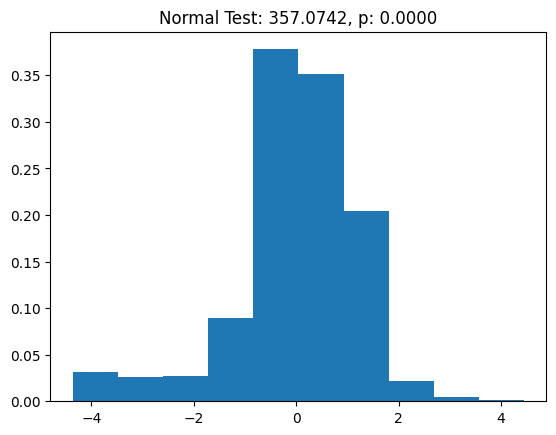

In [412]:
# Performance Phase

use_orig = True

if use_orig:
    performance_df = pd.concat([scarce_performance_data_orig, control_performance_data_orig]).reset_index(drop=True)
else: 
    performance_df = pd.concat([scarce_performance_data, control_performance_data]).reset_index(drop=True)
    
formula = '{} ~ trialNumbers + C(condition) + trialNumbers:C(condition)'.format(response_var)

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=performance_df, groups=performance_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=performance_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

In [413]:
# Plotting the data of both performance phases together

x1 = control_partition_plot_data[2]
x2 = scarce_partition_plot_data[2]
y1 = performance_df[performance_df.condition==0].groupby("trialNumbers").mean(numeric_only=True)[response_var]
y2 = performance_df[performance_df.condition==1].groupby("trialNumbers").mean(numeric_only=True)[response_var]
b1 = results.params['trialNumbers']
b2 = results.params['trialNumbers'] + results.params['trialNumbers:C(condition)[T.1]']
i1 = results.params['Intercept']
i2 = results.params['Intercept'] + results.params['C(condition)[T.1]']
        

plt.plot(x2, y2, color='b', alpha=0.5, label="Misaligned")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Performance Phases - Learning Curves - {}".format(response_var))
plt.xlabel("Trial Number")
plt.ylabel("{} - {}".format(response_var, "(Not Transformed)" if use_orig else "(Transformed)"))
plt.legend()

plt.show()

# 2.2 - Linear Regression: Expected Score vs. Trial Number x Condition

In [414]:
# Select the response variable for this analysis

response_var = "clicksL5"
assert (response_var in response_vars), "{} is not a valid response variable".format(response_var)

In [415]:
# Learning Phase

use_orig = True

if use_orig:
    learning_df = pd.concat([scarce_learning_data_orig, control_learning_data_orig]).reset_index(drop=True)
else: 
    learning_df = pd.concat([scarce_learning_data, control_learning_data]).reset_index(drop=True)

formula = '{} ~ trialNumbers + C(condition) + trialNumbers:C(condition)'.format(response_var)

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=learning_df, groups=learning_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=learning_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

                  Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       clicksL5 
No. Observations:       392           Method:                   REML     
No. Groups:             56            Scale:                    2.4844   
Min. group size:        7             Log-Likelihood:           -806.4533
Max. group size:        7             Converged:                Yes      
Mean group size:        7.0                                              
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       0.903    0.479  1.886 0.059 -0.036  1.841
C(condition)[T.1]              -0.221    0.644 -0.343 0.731 -1.482  1.041
trialNumbers                    0.296    0.060  4.964 0.000  0.179  0.412
trialNumbers:C(condition)[T.1] -0.131    0.080 -1.636 0.

In [416]:
# Plotting the data of both learning phases

x1 = control_partition_plot_data[1]
x2 = scarce_partition_plot_data[1]
y1 = learning_df[learning_df.condition==0].groupby("trialNumbers").mean(numeric_only=True)[response_var]
y2 = learning_df[learning_df.condition==1].groupby("trialNumbers").mean(numeric_only=True)[response_var]
b1 = results.params['trialNumbers']
b2 = results.params['trialNumbers'] + results.params['trialNumbers:C(condition)[T.1]']
i1 = results.params['Intercept']
i2 = results.params['Intercept'] + results.params['C(condition)[T.1]']

plt.plot(x2, y2, color='b', alpha=0.5, label="Misaligned")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Learning Phases - Learning Curves - {}".format(response_var))
plt.xlabel("Trial Number")
plt.ylabel("{} - {}".format(response_var, "(Not Transformed)" if use_orig else "(Transformed)"))
plt.legend()


plt.show()



                  Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      clicksL5  
No. Observations:        1848         Method:                  REML      
No. Groups:              56           Scale:                   4.5625    
Min. group size:         33           Log-Likelihood:          -4118.7937
Max. group size:         33           Converged:               Yes       
Mean group size:         33.0                                            
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       2.899    0.403  7.195 0.000  2.109  3.688
C(condition)[T.1]              -1.002    0.541 -1.851 0.064 -2.063  0.059
trialNumbers                   -0.000    0.008 -0.034 0.973 -0.016  0.015
trialNumbers:C(condition)[T.1]  0.017    0.010  1.654 0.

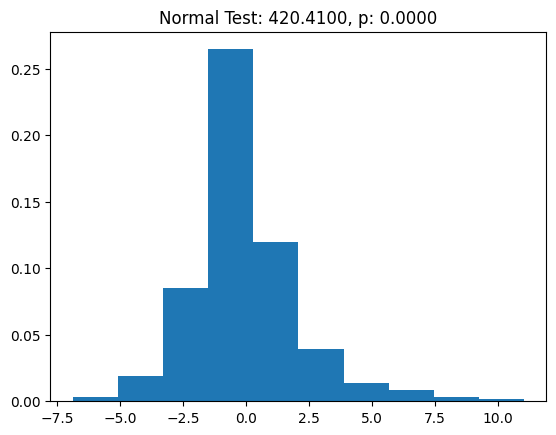

In [417]:
# Performance Phase

use_orig = True

if use_orig:
    performance_df = pd.concat([scarce_performance_data_orig, control_performance_data_orig]).reset_index(drop=True)
else: 
    performance_df = pd.concat([scarce_performance_data, control_performance_data]).reset_index(drop=True)
    
formula = '{} ~ trialNumbers + C(condition) + trialNumbers:C(condition)'.format(response_var)

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=performance_df, groups=performance_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=performance_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

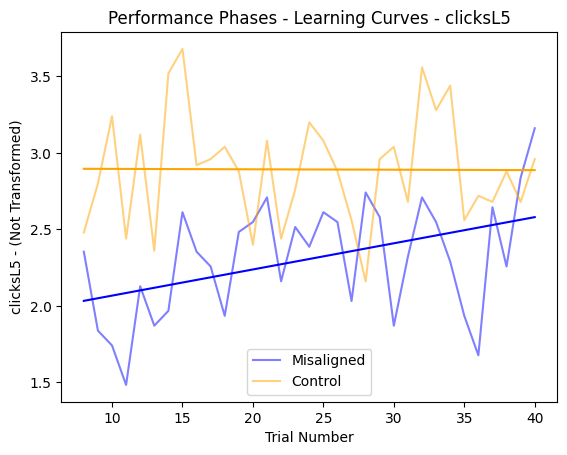

In [418]:
# Plotting the data of both performance phases together

x1 = control_partition_plot_data[2]
x2 = scarce_partition_plot_data[2]
y1 = performance_df[performance_df.condition==0].groupby("trialNumbers").mean(numeric_only=True)[response_var]
y2 = performance_df[performance_df.condition==1].groupby("trialNumbers").mean(numeric_only=True)[response_var]
b1 = results.params['trialNumbers']
b2 = results.params['trialNumbers'] + results.params['trialNumbers:C(condition)[T.1]']
i1 = results.params['Intercept']
i2 = results.params['Intercept'] + results.params['C(condition)[T.1]']
        

plt.plot(x2, y2, color='b', alpha=0.5, label="Misaligned")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Performance Phases - Learning Curves - {}".format(response_var))
plt.xlabel("Trial Number")
plt.ylabel("{} - {}".format(response_var, "(Not Transformed)" if use_orig else "(Transformed)"))
plt.legend()

plt.show()

# 2.3 - Linear Regression: Expected Score vs. Trial Number x Condition

In [421]:
# Select the response variable for this analysis

response_var = "clicksL1"
assert (response_var in response_vars), "{} is not a valid response variable".format(response_var)

                  Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       clicksL1 
No. Observations:       392           Method:                   REML     
No. Groups:             56            Scale:                    0.4418   
Min. group size:        7             Log-Likelihood:           -470.6063
Max. group size:        7             Converged:                Yes      
Mean group size:        7.0                                              
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       0.983    0.200  4.924 0.000  0.592  1.374
C(condition)[T.1]               0.095    0.268  0.356 0.722 -0.430  0.621
trialNumbers                   -0.053    0.025 -2.104 0.035 -0.102 -0.004
trialNumbers:C(condition)[T.1] -0.025    0.034 -0.755 0.

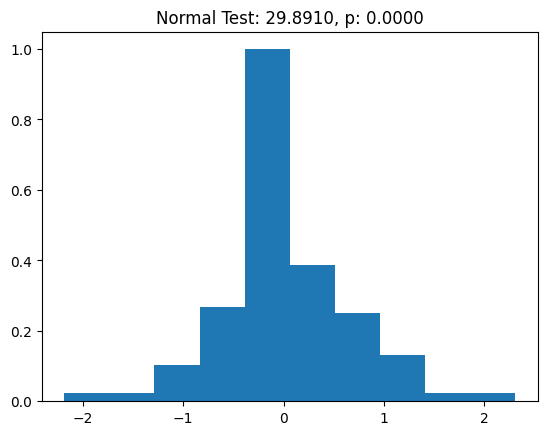

In [422]:
# Learning Phase

use_orig = True

if use_orig:
    learning_df = pd.concat([scarce_learning_data_orig, control_learning_data_orig]).reset_index(drop=True)
else: 
    learning_df = pd.concat([scarce_learning_data, control_learning_data]).reset_index(drop=True)

formula = '{} ~ trialNumbers + C(condition) + trialNumbers:C(condition)'.format(response_var)

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=learning_df, groups=learning_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=learning_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

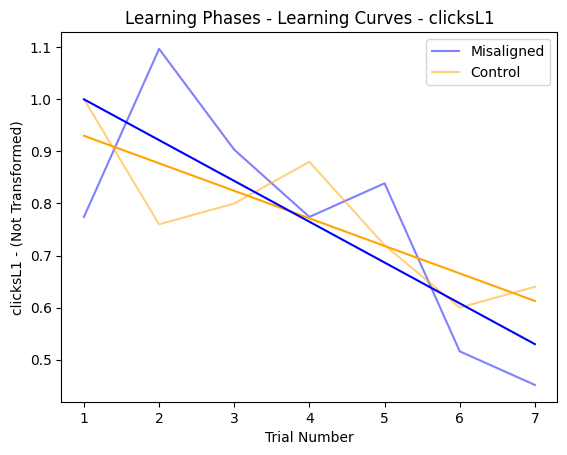

In [423]:
# Plotting the data of both learning phases

x1 = control_partition_plot_data[1]
x2 = scarce_partition_plot_data[1]
y1 = learning_df[learning_df.condition==0].groupby("trialNumbers").mean(numeric_only=True)[response_var]
y2 = learning_df[learning_df.condition==1].groupby("trialNumbers").mean(numeric_only=True)[response_var]
b1 = results.params['trialNumbers']
b2 = results.params['trialNumbers'] + results.params['trialNumbers:C(condition)[T.1]']
i1 = results.params['Intercept']
i2 = results.params['Intercept'] + results.params['C(condition)[T.1]']

plt.plot(x2, y2, color='b', alpha=0.5, label="Misaligned")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Learning Phases - Learning Curves - {}".format(response_var))
plt.xlabel("Trial Number")
plt.ylabel("{} - {}".format(response_var, "(Not Transformed)" if use_orig else "(Transformed)"))
plt.legend()


plt.show()



                  Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      clicksL1  
No. Observations:        1848         Method:                  REML      
No. Groups:              56           Scale:                   0.3652    
Min. group size:         33           Log-Likelihood:          -1810.4745
Max. group size:         33           Converged:               Yes       
Mean group size:         33.0                                            
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       0.519    0.155  3.340 0.001  0.214  0.824
C(condition)[T.1]               0.031    0.209  0.148 0.882 -0.378  0.440
trialNumbers                   -0.013    0.002 -5.718 0.000 -0.017 -0.008
trialNumbers:C(condition)[T.1]  0.017    0.003  5.768 0.

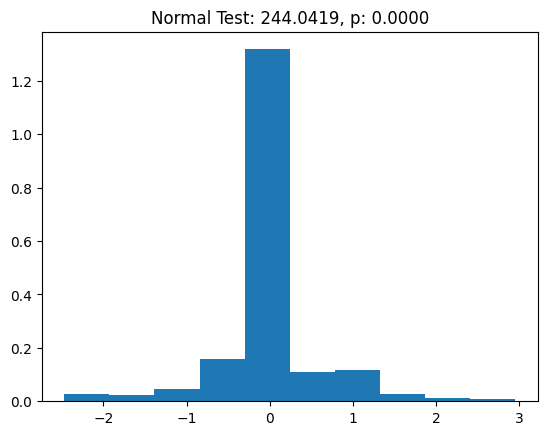

In [424]:
# Performance Phase

use_orig = True

if use_orig:
    performance_df = pd.concat([scarce_performance_data_orig, control_performance_data_orig]).reset_index(drop=True)
else: 
    performance_df = pd.concat([scarce_performance_data, control_performance_data]).reset_index(drop=True)
    
formula = '{} ~ trialNumbers + C(condition) + trialNumbers:C(condition)'.format(response_var)

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=performance_df, groups=performance_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=performance_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

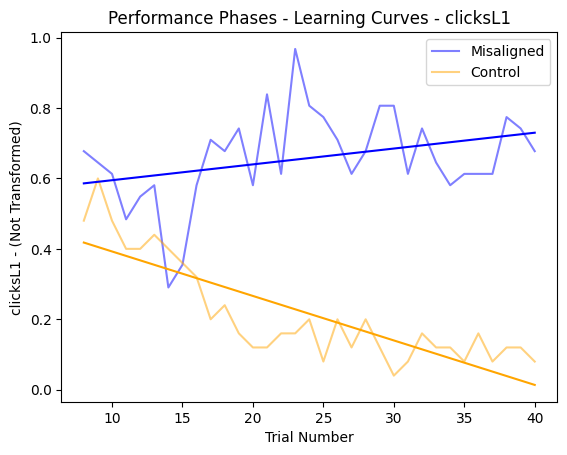

In [425]:
# Plotting the data of both performance phases together

x1 = control_partition_plot_data[2]
x2 = scarce_partition_plot_data[2]
y1 = performance_df[performance_df.condition==0].groupby("trialNumbers").mean(numeric_only=True)[response_var]
y2 = performance_df[performance_df.condition==1].groupby("trialNumbers").mean(numeric_only=True)[response_var]
b1 = results.params['trialNumbers']
b2 = results.params['trialNumbers'] + results.params['trialNumbers:C(condition)[T.1]']
i1 = results.params['Intercept']
i2 = results.params['Intercept'] + results.params['C(condition)[T.1]']
        

plt.plot(x2, y2, color='b', alpha=0.5, label="Misaligned")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Performance Phases - Learning Curves - {}".format(response_var))
plt.xlabel("Trial Number")
plt.ylabel("{} - {}".format(response_var, "(Not Transformed)" if use_orig else "(Transformed)"))
plt.legend()

plt.show()

# 2.4 - Linear Regression: Expected Score vs. Trial Number x Condition

In [426]:
# Select the response variable for this analysis

response_var = "strategyScores_scaled"
assert (response_var in response_vars), "{} is not a valid response variable".format(response_var)

                  Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   strategyScores_scaled
No. Observations:   392       Method:               REML                 
No. Groups:         56        Scale:                0.0379               
Min. group size:    7         Log-Likelihood:       -8.3837              
Max. group size:    7         Converged:            Yes                  
Mean group size:    7.0                                                  
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       0.376    0.072  5.235 0.000  0.235  0.517
C(condition)[T.1]              -0.218    0.097 -2.254 0.024 -0.407 -0.028
trialNumbers                    0.037    0.007  5.045 0.000  0.023  0.052
trialNumbers:C(condition)[T.1]  0.007    0.010  0.658 0.

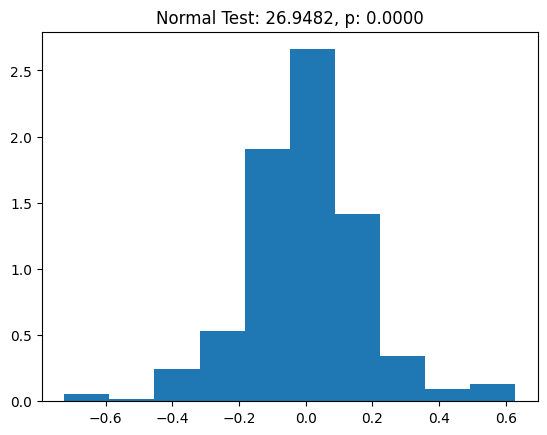

In [427]:
# Learning Phase

use_orig = True

if use_orig:
    learning_df = pd.concat([scarce_learning_data_orig, control_learning_data_orig]).reset_index(drop=True)
else: 
    learning_df = pd.concat([scarce_learning_data, control_learning_data]).reset_index(drop=True)

formula = '{} ~ trialNumbers + C(condition) + trialNumbers:C(condition)'.format(response_var)

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=learning_df, groups=learning_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=learning_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

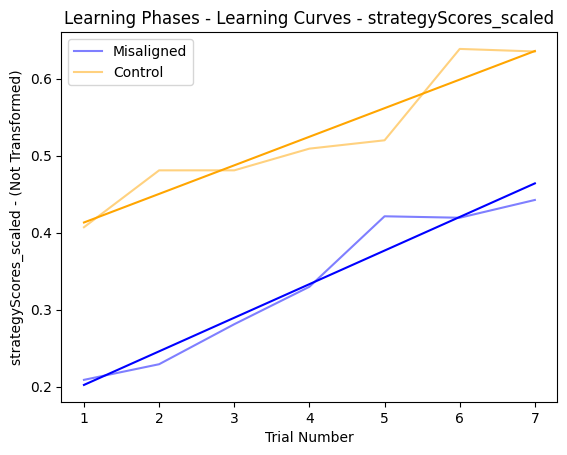

In [428]:
# Plotting the data of both learning phases

x1 = control_partition_plot_data[1]
x2 = scarce_partition_plot_data[1]
y1 = learning_df[learning_df.condition==0].groupby("trialNumbers").mean(numeric_only=True)[response_var]
y2 = learning_df[learning_df.condition==1].groupby("trialNumbers").mean(numeric_only=True)[response_var]
b1 = results.params['trialNumbers']
b2 = results.params['trialNumbers'] + results.params['trialNumbers:C(condition)[T.1]']
i1 = results.params['Intercept']
i2 = results.params['Intercept'] + results.params['C(condition)[T.1]']

plt.plot(x2, y2, color='b', alpha=0.5, label="Misaligned")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Learning Phases - Learning Curves - {}".format(response_var))
plt.xlabel("Trial Number")
plt.ylabel("{} - {}".format(response_var, "(Not Transformed)" if use_orig else "(Transformed)"))
plt.legend()


plt.show()



                  Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   strategyScores_scaled
No. Observations:   1848      Method:               REML                 
No. Groups:         56        Scale:                0.0232               
Min. group size:    33        Log-Likelihood:       700.9521             
Max. group size:    33        Converged:            Yes                  
Mean group size:    33.0                                                 
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       0.691    0.064 10.789 0.000  0.566  0.817
C(condition)[T.1]              -0.258    0.086 -2.992 0.003 -0.426 -0.089
trialNumbers                    0.003    0.001  5.126 0.000  0.002  0.004
trialNumbers:C(condition)[T.1] -0.001    0.001 -0.800 0.

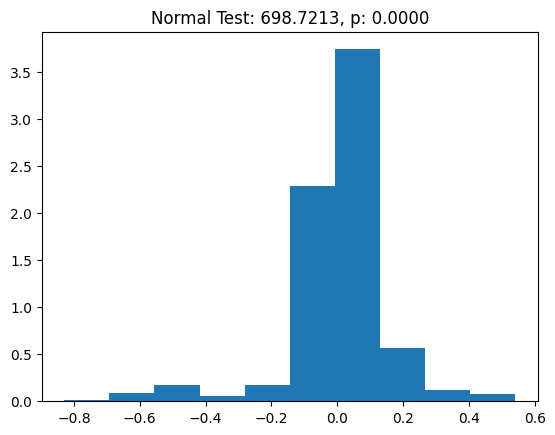

In [429]:
# Performance Phase

use_orig = True

if use_orig:
    performance_df = pd.concat([scarce_performance_data_orig, control_performance_data_orig]).reset_index(drop=True)
else: 
    performance_df = pd.concat([scarce_performance_data, control_performance_data]).reset_index(drop=True)
    
formula = '{} ~ trialNumbers + C(condition) + trialNumbers:C(condition)'.format(response_var)

mixed = True

if mixed:
    glm = smf.mixedlm(formula=formula, data=performance_df, groups=performance_df['workerId'])
else:
    glm = smf.glm(formula=formula, data=performance_df)

results = glm.fit()

print(results.summary())
resids = results.resid_response if not mixed else results.resid
normaltest = scipy.stats.normaltest(resids)
plt.hist(resids, density=True)
plt.title("Normal Test: {0:0.4f}, p: {1:0.4f}".format(normaltest[0], normaltest[1]))
plt.show()

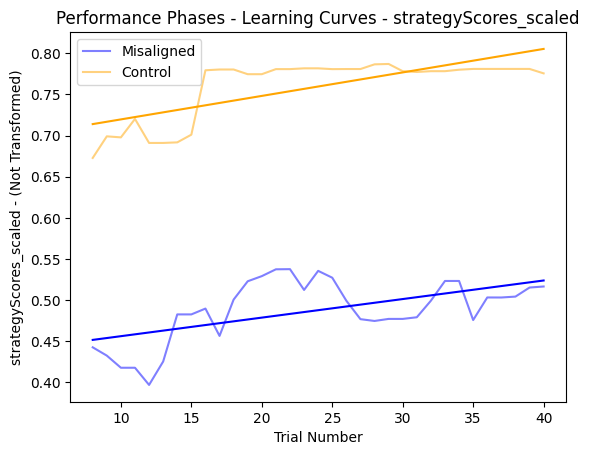

In [431]:
# Plotting the data of both performance phases together

x1 = control_partition_plot_data[2]
x2 = scarce_partition_plot_data[2]
y1 = performance_df[performance_df.condition==0].groupby("trialNumbers").mean(numeric_only=True)[response_var]
y2 = performance_df[performance_df.condition==1].groupby("trialNumbers").mean(numeric_only=True)[response_var]
b1 = results.params['trialNumbers']
b2 = results.params['trialNumbers'] + results.params['trialNumbers:C(condition)[T.1]']
i1 = results.params['Intercept']
i2 = results.params['Intercept'] + results.params['C(condition)[T.1]']
        

plt.plot(x2, y2, color='b', alpha=0.5, label="Misaligned")
plt.plot(x1, y1, color='orange', alpha=0.5, label="Control")


# Slope lines
plt.plot(x1, np.array(x1) * b1 + i1, color='orange')
plt.plot(x2, np.array(x2) * b2 + i2, color='b')
plt.title("Performance Phases - Learning Curves - {}".format(response_var))
plt.xlabel("Trial Number")
plt.ylabel("{} - {}".format(response_var, "(Not Transformed)" if use_orig else "(Transformed)"))
plt.legend()

plt.show()

# Appendix

# 1.5 - GLM Strategy Proportions

Observing how the strategies of the participants (as inferred by the Computational Microscope) change over time in each condition

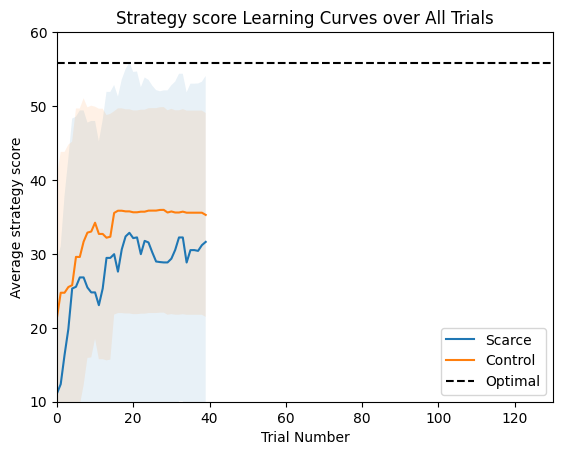

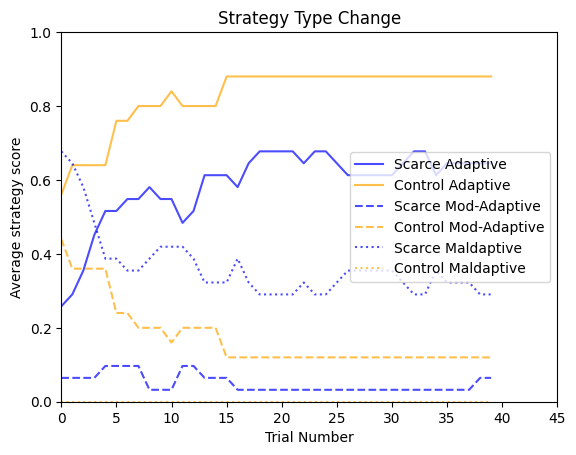

In [151]:
# Plotting mean expected score vs. trial number for each condition

data_to_copy = filtered_data.copy() # all_trials_df, outliers_excluded, or outliers_excluded_part

scarce_trial_group = data_to_copy.loc[data_to_copy.condition == 1].groupby('trialNumbers')
control_trial_group = data_to_copy.loc[data_to_copy.condition == 0].groupby('trialNumbers')

# Taking the mean expected score over all trials 
scarce_data_all = np.array(scarce_trial_group.mean(numeric_only=True)["strategyScores"])
scarce_data_all_sd = np.array(scarce_trial_group.std(numeric_only=True)["strategyScores"])
control_data = np.array(control_trial_group.mean(numeric_only=True)["strategyScores"])
control_data_sd = np.array(control_trial_group.std(numeric_only=True)["strategyScores"])

# Getting the proportions of clusters
scarce_data_adaptive = np.array(scarce_trial_group["cluster"].apply(lambda x: (x==0).sum()) / scarce_trial_group["cluster"].count())
control_data_adaptive = np.array(control_trial_group["cluster"].apply(lambda x: (x==0).sum()) / control_trial_group["cluster"].count())
scarce_data_modadaptive = np.array(scarce_trial_group["cluster"].apply(lambda x: (x==1).sum()) / scarce_trial_group["cluster"].count())
control_data_modadaptive = np.array(control_trial_group["cluster"].apply(lambda x: (x==1).sum()) / control_trial_group["cluster"].count())
scarce_data_maladaptive = np.array(scarce_trial_group["cluster"].apply(lambda x: (x==2).sum()) / scarce_trial_group["cluster"].count())
control_data_maladaptive = np.array(control_trial_group["cluster"].apply(lambda x: (x==2).sum()) / control_trial_group["cluster"].count())


plt.figure()
plt.title("Strategy score Learning Curves over All Trials")
plt.plot(list(range(len(scarce_data_all))), scarce_data_all, label="Scarce")
plt.fill_between(list(range(len(scarce_data_all))), scarce_data_all + scarce_data_all_sd, scarce_data_all - scarce_data_all_sd, alpha=0.1)
plt.plot(list(range(len(control_data))), control_data, label="Control")
plt.fill_between(list(range(len(control_data))), control_data + control_data_sd, control_data - control_data_sd, alpha=0.1)
plt.axhline(np.max(np.array(strategy_scores_control_list)[:,1], axis=0), color='k', label='Optimal', linestyle="--")
plt.legend()
plt.ylim([10,60])
plt.xlim([0, 130])
plt.xlabel("Trial Number")
plt.ylabel("Average strategy score")
plt.show()

plt.figure()
plt.title("Strategy Type Change")
alpha = 0.7
plt.plot(list(range(len(scarce_data_all))), scarce_data_adaptive, label="Scarce Adaptive", color='b',alpha=alpha)
plt.plot(list(range(len(control_data))), control_data_adaptive, label="Control Adaptive",color='orange',alpha=alpha)
plt.plot(list(range(len(scarce_data_all))), scarce_data_modadaptive, label="Scarce Mod-Adaptive", color='b',alpha=alpha, linestyle="--")
plt.plot(list(range(len(control_data))), control_data_modadaptive, label="Control Mod-Adaptive",color='orange',alpha=alpha, linestyle="--")
plt.plot(list(range(len(scarce_data_all))), scarce_data_maladaptive, label="Scarce Maldaptive", color='b',alpha=alpha, linestyle=":")
plt.plot(list(range(len(control_data))), control_data_maladaptive, label="Control Maldaptive",color='orange',alpha=alpha, linestyle=":")
plt.legend()
plt.ylim([0,1])
plt.xlim([0, 45])
plt.xlabel("Trial Number")
plt.ylabel("Average strategy score")
plt.show()


In [294]:
# Setting up logistic regression

data_to_copy = analysis_data.copy()
data_to_copy["cluster"] = data_to_copy["cluster"].astype("int64")

formula = "cluster ~ trialNumbers + C(scarce) + trialNumbers:C(scarce)"

model_1 = statsmodels.discrete.discrete_model.MNLogit.from_formula(formula, data_to_copy)
model_1_fit = model.fit()

endog = analysis_data["cluster"].astype("int64").map(lambda c: ["cat","dog","bear"][c])
exog = analysis_data[["trialNumbers", "scarce"]]
exog["trialNumbers:scarce"] = exog["trialNumbers"] * exog["scarce"]
exog["const"] = [1] * len(exog)

model_2 = statsmodels.discrete.discrete_model.MNLogit(endog, exog)
model_2_fit = model.fit()

print(model_1_fit.summary())
print(model_2_fit.summary())

Optimization terminated successfully.
         Current function value: 0.608218
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.608218
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:                cluster   No. Observations:                15210
Model:                        MNLogit   Df Residuals:                    15202
Method:                           MLE   Df Model:                            6
Date:                Tue, 25 Oct 2022   Pseudo R-squ.:                 0.04896
Time:                        11:32:54   Log-Likelihood:                -9251.0
converged:                       True   LL-Null:                       -9727.3
Covariance Type:            nonrobust   LLR p-value:                1.652e-202
                  cluster=1       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------

/var/folders/8k/zq6x09px4838xflgn88yhgdw0002cw/T/ipykernel_51899/3125500743.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exog["trialNumbers:scarce"] = exog["trialNumbers"] * exog["scarce"]
/var/folders/8k/zq6x09px4838xflgn88yhgdw0002cw/T/ipykernel_51899/3125500743.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exog["const"] = [1] * len(exog)


                          MNLogit Regression Results                          
Dep. Variable:                cluster   No. Observations:                15210
Model:                        MNLogit   Df Residuals:                    15202
Method:                           MLE   Df Model:                            6
Date:                Tue, 25 Oct 2022   Pseudo R-squ.:                 0.04896
Time:                        11:32:54   Log-Likelihood:                -9251.0
converged:                       True   LL-Null:                       -9727.3
Covariance Type:            nonrobust   LLR p-value:                1.652e-202
                  cluster=1       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -1.8616      0.145    -12.815      0.000      -2.146      -1.577
C(scarce)[T.1]                 -0.4777      0.167     -2.858      0.004      -0.

In [295]:
sum(model_2.endog == model_1.endog) / len(model_2.endog)

0.0